<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [1]:
#common libraries
import numpy as np
import os
import math
import random
from collections import OrderedDict

#torch package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss

#to manage OFF files and transform to voxel grid
!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

#to manage with progression and time in train and evaluate phase
import time
from tqdm import tqdm

!pip install Pillow==9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: wid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open3d 0.17.0 requires pillow>=9.3.0, but you have pillow 9.0.0 which is incompatible.


# Download and unzip the dataset ModelNet10

In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-06-14 15:44:39--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-06-14 15:44:40--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  12.6MB/s    in 56s     

2023-06-14 15:45:37 (8.03 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

# Voxelization of the off. files in dataset

In [4]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

rot = 0

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if (rot%8)==0:
              mesh = mesh
              rotat = 0
              rot +=1
            elif (rot%8)==1:
              mesh.rotate(r45)
              rotat = 1
              rot +=1
            elif (rot%8)==2:
              mesh.rotate(r90)
              rotat = 2
              rot +=1
            elif (rot%8)==3:
              mesh.rotate(r135)
              rotat = 3
              rot +=1
            elif (rot%8)==4:
              mesh.rotate(r180)
              rotat = 4
              rot +=1
            elif (rot%8)==5:
              mesh.rotate(r225)
              rotat = 5
              rot +=1
            elif (rot%8)==6:
              mesh.rotate(r270)
              rotat = 6
              rot+=1
            else:
              mesh.rotate(r315)
              rotat = 7
              rot+=1
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)

100%|██████████| 101/101 [00:05<00:00, 20.16it/s]


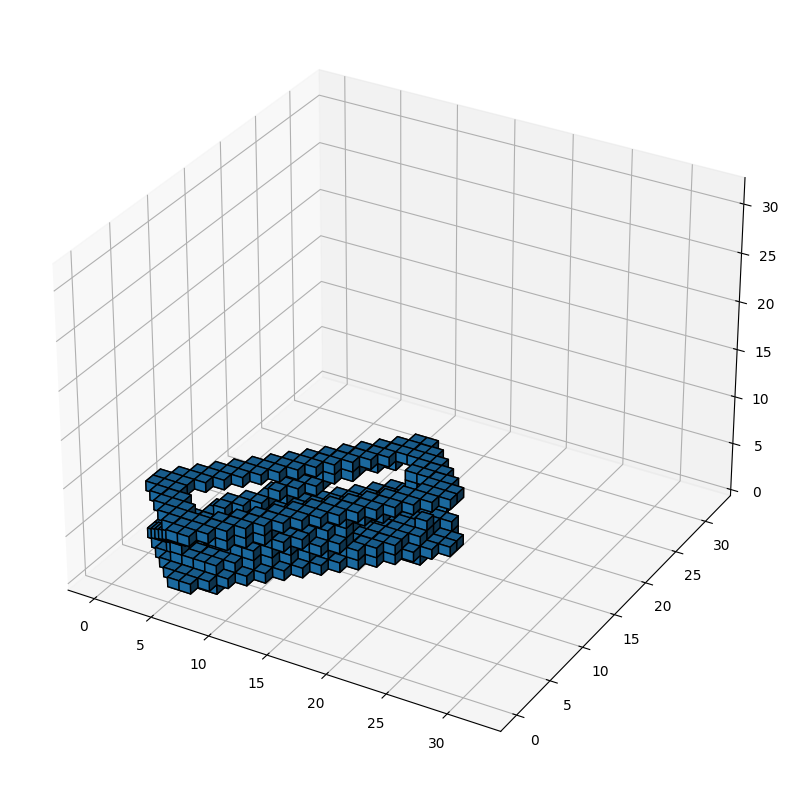

In [ ]:
mesh = o3d.io.read_triangle_mesh('/content/ModelNet10/bathtub/train/bathtub_0003.off')
mesh.rotate(r315)

mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

vox_grid = voxel_grid.get_voxels()
vox_g = np.zeros((32, 32, 32), dtype=np.int32)
for i in range (len(vox_grid)):
  voxel_index = vox_grid[i].grid_index
  vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(vox_g, edgecolor='k')
plt.show()

# VoxNet


In [8]:
class VoxNet_Dataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']

    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):

        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1

In [24]:
class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0

      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()

  def initDataset(self):
      self.train_ds = VoxNet_Dataset(train=True)
      self.test_ds = VoxNet_Dataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "ORION":
          self.model = ORION()
          os.mkdir('/content/'+str(self.name_model))
          print("model ORION was chosen")
      else:
        self.model = DMPORION()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPORION was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)

      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.CrossEntropyLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training loss
          train_loss = []
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1 = data[0], data[1]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)

              self.opt.zero_grad()
              pred1 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.loss_fn(pred1, labels1)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu())

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")

          self.lr_scheduler.step()

          #test phase
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):
                inputs_test, labels_test1 = sample[0], sample[1]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                inputs_test = inputs_test.float()

                pred_test1 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.loss_fn(pred_test1, labels_test1)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu())

                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)


          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()


          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          valid_acc_history1.append(total_valid_accuracy1)

          elapsed_time_epoch = time.time() - t

          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1],
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')


          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1),
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1)}

  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))

      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)

  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))

      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')

      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()

      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]

      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()

  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']

      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)

          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0

          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())

      return test_accuracy.compute()

  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)

      return eps, acc

In [25]:
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))

        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        return self.logsoftmax(x1)

In [26]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

FileExistsError: ignored

KeyError: ignored

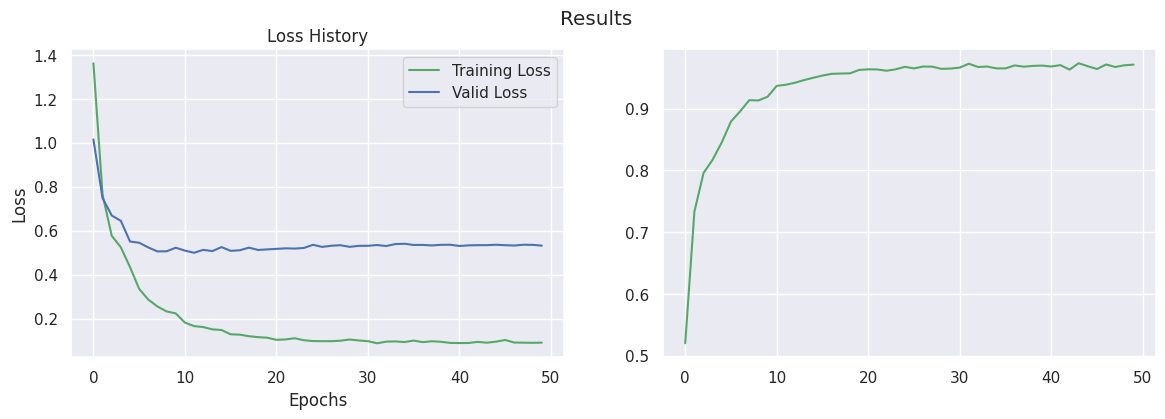

In [27]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

In [ ]:
trainer1.generateConfusionMatrix()

# ORION

In [ ]:
class Network_Dataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']


    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):

        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
class Network_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3

      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()

  def initDataset(self):
      self.train_ds = Network_Dataset(train=True)
      self.test_ds = Network_Dataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "ORION":
          self.model = ORION()
          os.mkdir('/content/'+str(self.name_model))
          print("model ORION was chosen")
      else:
        self.model = DMPORION()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPORION was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)

      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.CrossEntropyLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)


      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training loss
          train_loss = []
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu())
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu())

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")

          self.lr_scheduler.step()

          #test phase
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []
            pred_test2 = []
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()

                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu())

                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)


          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()

          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)


          elapsed_time_epoch = time.time() - t

          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, valid-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1],
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')


          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2),
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}

  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))

      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)

  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))

      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')

      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()

      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]

      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()

  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']

      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)

          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0

          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())

      return test_accuracy.compute()

  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)

      return eps, acc

In [ ]:
class ORION(nn.Module):
    def __init__(self):
        super(ORION, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop4', torch.nn.Dropout(p=0.3))
        ]))

        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

**BatchNormVoxNet** Training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'ORION'
}

trainer2 = Network_Trainer(training_hyperparameters)
trainer2.train()

model ORION was chosen
62.359375


Train loss: 1.3438827991485596: : 62it [00:16,  3.68it/s]
29it [00:03,  8.84it/s]


epoch:  1 / 50
time: 20.16 seconds
train-loss: 1.57, train-acc-object: 45.77%, train-acc-pose: 34.17%
valid-loss: 1.36, valid-acc-object: 53.30%, valid-acc-pose: 51.76%



Train loss: 0.7883669137954712: : 62it [00:16,  3.66it/s]
29it [00:02, 12.90it/s]


epoch:  2 / 50
time: 19.20 seconds
train-loss: 1.06, train-acc-object: 64.14%, train-acc-pose: 53.55%
valid-loss: 0.95, valid-acc-object: 66.41%, valid-acc-pose: 58.04%



Train loss: 0.6702679395675659: : 62it [00:16,  3.72it/s]
29it [00:02, 11.42it/s]


epoch:  3 / 50
time: 19.23 seconds
train-loss: 0.85, train-acc-object: 71.52%, train-acc-pose: 64.21%
valid-loss: 0.79, valid-acc-object: 72.25%, valid-acc-pose: 64.32%



Train loss: 0.5170481204986572: : 62it [00:17,  3.59it/s]
29it [00:02, 12.81it/s]


epoch:  4 / 50
time: 19.55 seconds
train-loss: 0.68, train-acc-object: 77.24%, train-acc-pose: 70.46%
valid-loss: 0.68, valid-acc-object: 75.33%, valid-acc-pose: 68.72%



Train loss: 0.8121242523193359: : 62it [00:16,  3.73it/s]
29it [00:02, 12.93it/s]


epoch:  5 / 50
time: 18.91 seconds
train-loss: 0.58, train-acc-object: 80.75%, train-acc-pose: 73.61%
valid-loss: 0.68, valid-acc-object: 76.32%, valid-acc-pose: 68.39%



Train loss: 0.3910774886608124: : 62it [00:17,  3.53it/s]
29it [00:03,  7.41it/s]


epoch:  6 / 50
time: 21.49 seconds
train-loss: 0.47, train-acc-object: 85.06%, train-acc-pose: 77.70%
valid-loss: 0.56, valid-acc-object: 82.05%, valid-acc-pose: 70.15%



Train loss: 0.36347490549087524: : 62it [00:16,  3.66it/s]
29it [00:02, 12.52it/s]


epoch:  7 / 50
time: 19.27 seconds
train-loss: 0.42, train-acc-object: 86.44%, train-acc-pose: 78.68%
valid-loss: 0.54, valid-acc-object: 83.37%, valid-acc-pose: 72.14%



Train loss: 0.3566417694091797: : 62it [00:17,  3.49it/s]
29it [00:02, 12.85it/s]


epoch:  8 / 50
time: 20.05 seconds
train-loss: 0.38, train-acc-object: 88.33%, train-acc-pose: 78.81%
valid-loss: 0.60, valid-acc-object: 79.52%, valid-acc-pose: 70.81%



Train loss: 0.2750326991081238: : 62it [00:16,  3.74it/s]
29it [00:02, 13.03it/s]


epoch:  9 / 50
time: 18.82 seconds
train-loss: 0.36, train-acc-object: 89.31%, train-acc-pose: 81.12%
valid-loss: 0.51, valid-acc-object: 83.04%, valid-acc-pose: 73.90%



Train loss: 0.46002399921417236: : 62it [00:16,  3.67it/s]
29it [00:03,  8.87it/s]


epoch: 10 / 50
time: 20.17 seconds
train-loss: 0.34, train-acc-object: 89.57%, train-acc-pose: 83.04%
valid-loss: 0.52, valid-acc-object: 83.04%, valid-acc-pose: 73.68%



Train loss: 0.2669674754142761: : 62it [00:16,  3.71it/s]
29it [00:02, 13.00it/s]


epoch: 11 / 50
time: 18.97 seconds
train-loss: 0.30, train-acc-object: 90.57%, train-acc-pose: 83.34%
valid-loss: 0.51, valid-acc-object: 85.57%, valid-acc-pose: 73.24%



Train loss: 0.17303058505058289: : 62it [00:16,  3.72it/s]
29it [00:03,  8.56it/s]


epoch: 12 / 50
time: 20.05 seconds
train-loss: 0.28, train-acc-object: 91.66%, train-acc-pose: 84.30%
valid-loss: 0.51, valid-acc-object: 85.24%, valid-acc-pose: 74.45%



Train loss: 0.2389218807220459: : 62it [00:16,  3.67it/s]
29it [00:02, 12.82it/s]


epoch: 13 / 50
time: 19.15 seconds
train-loss: 0.27, train-acc-object: 92.01%, train-acc-pose: 84.02%
valid-loss: 0.50, valid-acc-object: 85.90%, valid-acc-pose: 74.23%



Train loss: 0.1877809464931488: : 62it [00:16,  3.72it/s]
29it [00:02, 11.37it/s]


epoch: 14 / 50
time: 19.23 seconds
train-loss: 0.25, train-acc-object: 92.52%, train-acc-pose: 85.74%
valid-loss: 0.52, valid-acc-object: 84.36%, valid-acc-pose: 74.01%



Train loss: 0.2522074580192566: : 62it [00:17,  3.57it/s]
29it [00:02, 13.20it/s]


epoch: 15 / 50
time: 19.59 seconds
train-loss: 0.24, train-acc-object: 93.55%, train-acc-pose: 85.56%
valid-loss: 0.50, valid-acc-object: 85.57%, valid-acc-pose: 74.67%



Train loss: 0.1785365641117096: : 62it [00:16,  3.72it/s]
29it [00:02, 12.82it/s]


epoch: 16 / 50
time: 18.93 seconds
train-loss: 0.23, train-acc-object: 93.78%, train-acc-pose: 86.52%
valid-loss: 0.51, valid-acc-object: 85.13%, valid-acc-pose: 76.10%



Train loss: 0.2183203399181366: : 62it [00:18,  3.44it/s]
29it [00:03,  9.26it/s]


epoch: 17 / 50
time: 21.17 seconds
train-loss: 0.22, train-acc-object: 94.00%, train-acc-pose: 86.52%
valid-loss: 0.50, valid-acc-object: 85.13%, valid-acc-pose: 75.11%



Train loss: 0.18739581108093262: : 62it [00:16,  3.72it/s]
29it [00:02, 13.10it/s]


epoch: 18 / 50
time: 18.91 seconds
train-loss: 0.22, train-acc-object: 94.41%, train-acc-pose: 86.11%
valid-loss: 0.52, valid-acc-object: 85.24%, valid-acc-pose: 74.34%



Train loss: 0.19710104167461395: : 62it [00:16,  3.71it/s]
29it [00:03,  8.26it/s]


epoch: 19 / 50
time: 20.26 seconds
train-loss: 0.22, train-acc-object: 93.78%, train-acc-pose: 87.20%
valid-loss: 0.51, valid-acc-object: 85.46%, valid-acc-pose: 74.34%



Train loss: 0.2100079506635666: : 62it [00:16,  3.69it/s]
29it [00:02, 13.04it/s]


epoch: 20 / 50
time: 19.05 seconds
train-loss: 0.20, train-acc-object: 94.96%, train-acc-pose: 87.80%
valid-loss: 0.50, valid-acc-object: 86.12%, valid-acc-pose: 75.66%



Train loss: 0.2678734362125397: : 62it [00:16,  3.72it/s]
29it [00:02, 10.11it/s]


epoch: 21 / 50
time: 19.56 seconds
train-loss: 0.20, train-acc-object: 95.04%, train-acc-pose: 87.32%
valid-loss: 0.50, valid-acc-object: 85.90%, valid-acc-pose: 75.22%



Train loss: 0.24624937772750854: : 62it [00:17,  3.59it/s]
29it [00:02, 12.61it/s]


epoch: 22 / 50
time: 19.60 seconds
train-loss: 0.20, train-acc-object: 94.68%, train-acc-pose: 88.84%
valid-loss: 0.51, valid-acc-object: 85.02%, valid-acc-pose: 75.77%



Train loss: 0.17524994909763336: : 62it [00:16,  3.68it/s]
29it [00:02, 13.01it/s]


epoch: 23 / 50
time: 19.08 seconds
train-loss: 0.19, train-acc-object: 95.26%, train-acc-pose: 88.03%
valid-loss: 0.50, valid-acc-object: 85.57%, valid-acc-pose: 74.89%



Train loss: 0.22703805565834045: : 62it [00:17,  3.49it/s]
29it [00:02, 11.91it/s]


epoch: 24 / 50
time: 20.22 seconds
train-loss: 0.20, train-acc-object: 94.51%, train-acc-pose: 87.63%
valid-loss: 0.51, valid-acc-object: 85.46%, valid-acc-pose: 75.99%



Train loss: 0.224785715341568: : 62it [00:16,  3.65it/s]
29it [00:02, 12.25it/s]


epoch: 25 / 50
time: 19.36 seconds
train-loss: 0.19, train-acc-object: 94.88%, train-acc-pose: 88.56%
valid-loss: 0.50, valid-acc-object: 85.68%, valid-acc-pose: 75.77%



Train loss: 0.17903143167495728: : 62it [00:17,  3.50it/s]
29it [00:03,  8.12it/s]


epoch: 26 / 50
time: 21.33 seconds
train-loss: 0.20, train-acc-object: 94.81%, train-acc-pose: 88.31%
valid-loss: 0.50, valid-acc-object: 85.13%, valid-acc-pose: 75.33%



Train loss: 0.12962128221988678: : 62it [00:17,  3.50it/s]
29it [00:02, 12.44it/s]


epoch: 27 / 50
time: 20.08 seconds
train-loss: 0.18, train-acc-object: 95.39%, train-acc-pose: 87.78%
valid-loss: 0.51, valid-acc-object: 86.01%, valid-acc-pose: 75.22%



Train loss: 0.18478579819202423: : 62it [00:17,  3.45it/s]
29it [00:02, 12.11it/s]


epoch: 28 / 50
time: 20.39 seconds
train-loss: 0.19, train-acc-object: 95.29%, train-acc-pose: 88.61%
valid-loss: 0.51, valid-acc-object: 85.68%, valid-acc-pose: 75.33%



Train loss: 0.20025424659252167: : 62it [00:16,  3.65it/s]
29it [00:02, 12.35it/s]


epoch: 29 / 50
time: 19.36 seconds
train-loss: 0.18, train-acc-object: 95.31%, train-acc-pose: 88.41%
valid-loss: 0.51, valid-acc-object: 86.01%, valid-acc-pose: 75.44%



Train loss: 0.23918920755386353: : 62it [00:17,  3.51it/s]
29it [00:02, 11.22it/s]


epoch: 30 / 50
time: 20.27 seconds
train-loss: 0.18, train-acc-object: 95.39%, train-acc-pose: 89.04%
valid-loss: 0.51, valid-acc-object: 86.01%, valid-acc-pose: 74.78%



Train loss: 0.21876855194568634: : 62it [00:17,  3.61it/s]
29it [00:02, 11.72it/s]


epoch: 31 / 50
time: 19.67 seconds
train-loss: 0.19, train-acc-object: 94.93%, train-acc-pose: 88.46%
valid-loss: 0.50, valid-acc-object: 85.68%, valid-acc-pose: 75.55%



Train loss: 0.2289782464504242: : 62it [00:17,  3.45it/s]
29it [00:02, 10.03it/s]


epoch: 32 / 50
time: 20.90 seconds
train-loss: 0.18, train-acc-object: 95.84%, train-acc-pose: 88.51%
valid-loss: 0.51, valid-acc-object: 85.90%, valid-acc-pose: 75.55%



Train loss: 0.1999373435974121: : 62it [00:17,  3.64it/s]
29it [00:02, 12.05it/s]


epoch: 33 / 50
time: 19.48 seconds
train-loss: 0.18, train-acc-object: 95.46%, train-acc-pose: 88.43%
valid-loss: 0.51, valid-acc-object: 85.79%, valid-acc-pose: 76.10%



Train loss: 0.1873459815979004: : 62it [00:17,  3.52it/s]
29it [00:03,  8.92it/s]


epoch: 34 / 50
time: 20.87 seconds
train-loss: 0.18, train-acc-object: 95.24%, train-acc-pose: 89.16%
valid-loss: 0.51, valid-acc-object: 85.79%, valid-acc-pose: 76.10%



Train loss: 0.18651127815246582: : 62it [00:17,  3.64it/s]
29it [00:02, 12.21it/s]


epoch: 35 / 50
time: 19.45 seconds
train-loss: 0.18, train-acc-object: 95.11%, train-acc-pose: 88.13%
valid-loss: 0.51, valid-acc-object: 85.79%, valid-acc-pose: 76.21%



Train loss: 0.1997373402118683: : 62it [00:17,  3.56it/s]
29it [00:04,  6.82it/s]


epoch: 36 / 50
time: 21.71 seconds
train-loss: 0.18, train-acc-object: 95.67%, train-acc-pose: 88.56%
valid-loss: 0.51, valid-acc-object: 85.90%, valid-acc-pose: 75.99%



Train loss: 0.19865834712982178: : 62it [00:17,  3.61it/s]
29it [00:02, 12.21it/s]


epoch: 37 / 50
time: 19.58 seconds
train-loss: 0.18, train-acc-object: 95.77%, train-acc-pose: 88.36%
valid-loss: 0.51, valid-acc-object: 85.68%, valid-acc-pose: 75.88%



Train loss: 0.15272341668605804: : 62it [00:17,  3.57it/s]
29it [00:03,  9.05it/s]


epoch: 38 / 50
time: 20.61 seconds
train-loss: 0.18, train-acc-object: 95.46%, train-acc-pose: 88.63%
valid-loss: 0.51, valid-acc-object: 86.12%, valid-acc-pose: 75.99%



Train loss: 0.1942361444234848: : 62it [00:16,  3.66it/s]
29it [00:02, 12.40it/s]


epoch: 39 / 50
time: 19.30 seconds
train-loss: 0.18, train-acc-object: 95.74%, train-acc-pose: 88.08%
valid-loss: 0.51, valid-acc-object: 85.68%, valid-acc-pose: 75.99%



Train loss: 0.18116913735866547: : 62it [00:17,  3.64it/s]
29it [00:03,  8.50it/s]


epoch: 40 / 50
time: 20.47 seconds
train-loss: 0.18, train-acc-object: 95.51%, train-acc-pose: 89.14%
valid-loss: 0.51, valid-acc-object: 85.79%, valid-acc-pose: 75.66%



Train loss: 0.1039261668920517: : 62it [00:16,  3.67it/s]
29it [00:02, 12.27it/s]


epoch: 41 / 50
time: 19.26 seconds
train-loss: 0.18, train-acc-object: 95.29%, train-acc-pose: 89.69%
valid-loss: 0.51, valid-acc-object: 85.90%, valid-acc-pose: 75.99%



Train loss: 0.15719643235206604: : 62it [00:16,  3.67it/s]
29it [00:03,  7.90it/s]


epoch: 42 / 50
time: 20.59 seconds
train-loss: 0.18, train-acc-object: 95.36%, train-acc-pose: 88.71%
valid-loss: 0.51, valid-acc-object: 85.79%, valid-acc-pose: 75.99%



Train loss: 0.23487788438796997: : 62it [00:16,  3.67it/s]
29it [00:02, 12.78it/s]


epoch: 43 / 50
time: 19.16 seconds
train-loss: 0.18, train-acc-object: 95.54%, train-acc-pose: 88.58%
valid-loss: 0.51, valid-acc-object: 85.57%, valid-acc-pose: 76.21%



Train loss: 0.14046785235404968: : 62it [00:16,  3.68it/s]
29it [00:03,  8.54it/s]


epoch: 44 / 50
time: 20.28 seconds
train-loss: 0.18, train-acc-object: 95.29%, train-acc-pose: 87.98%
valid-loss: 0.51, valid-acc-object: 86.23%, valid-acc-pose: 75.77%



Train loss: 0.16450923681259155: : 62it [00:16,  3.66it/s]
29it [00:02, 12.40it/s]


epoch: 45 / 50
time: 19.29 seconds
train-loss: 0.18, train-acc-object: 95.59%, train-acc-pose: 89.14%
valid-loss: 0.51, valid-acc-object: 85.79%, valid-acc-pose: 76.10%



Train loss: 0.21010839939117432: : 62it [00:16,  3.65it/s]
29it [00:03,  8.36it/s]


epoch: 46 / 50
time: 20.47 seconds
train-loss: 0.18, train-acc-object: 95.74%, train-acc-pose: 89.57%
valid-loss: 0.51, valid-acc-object: 85.79%, valid-acc-pose: 75.99%



Train loss: 0.23247931897640228: : 62it [00:18,  3.43it/s]
29it [00:02, 12.56it/s]


epoch: 47 / 50
time: 20.42 seconds
train-loss: 0.17, train-acc-object: 95.59%, train-acc-pose: 88.81%
valid-loss: 0.51, valid-acc-object: 85.68%, valid-acc-pose: 76.10%



Train loss: 0.18742208182811737: : 62it [00:16,  3.69it/s]
29it [00:02, 12.33it/s]


epoch: 48 / 50
time: 19.16 seconds
train-loss: 0.18, train-acc-object: 95.56%, train-acc-pose: 88.51%
valid-loss: 0.51, valid-acc-object: 85.90%, valid-acc-pose: 75.99%



Train loss: 0.15978313982486725: : 62it [00:17,  3.51it/s]
29it [00:02, 12.74it/s]


epoch: 49 / 50
time: 19.99 seconds
train-loss: 0.17, train-acc-object: 95.77%, train-acc-pose: 88.61%
valid-loss: 0.51, valid-acc-object: 86.23%, valid-acc-pose: 75.88%



Train loss: 0.21049624681472778: : 62it [00:16,  3.67it/s]
29it [00:02, 12.53it/s]

epoch: 50 / 50
time: 19.23 seconds
train-loss: 0.18, train-acc-object: 95.79%, train-acc-pose: 88.43%
valid-loss: 0.51, valid-acc-object: 85.68%, valid-acc-pose: 76.21%



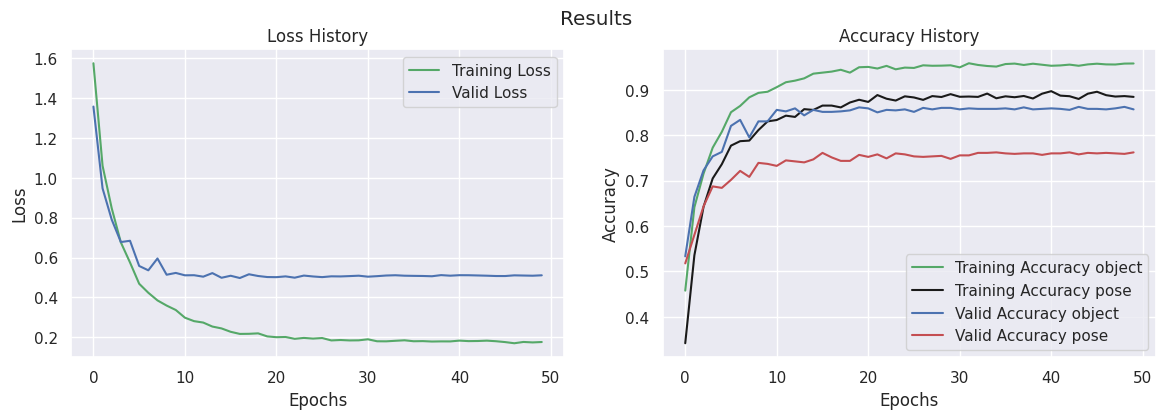

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

best model was trained at epoch: 44
with a validation loss of: 0.50880224 and a validation accuracy of: 86.23347878456116


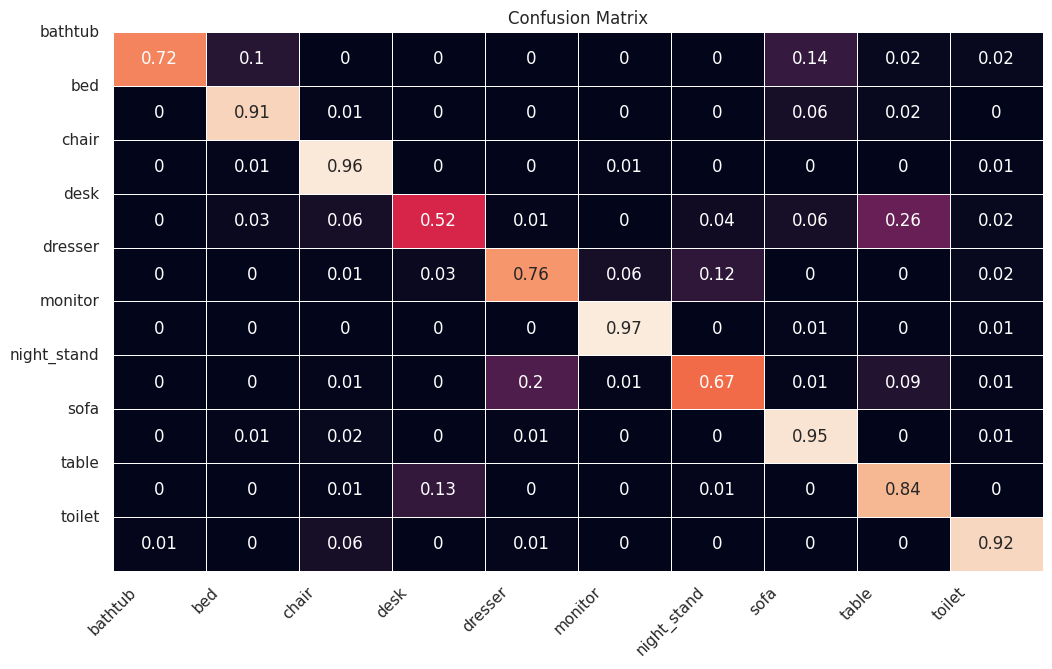

In [ ]:
trainer2.generateConfusionMatrix()

# DMPORION (double-max-pooling ORION)

In [ ]:
class DMPORION(nn.Module):
    def __init__(self):
        super(DMPORION, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.2)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('pool3', torch.nn.MaxPool3d(2)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256,kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool4', torch.nn.MaxPool3d(2))
        ]))

        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

**DMPVoxNet** training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPORION'
}

trainer3 = Network_Trainer(training_hyperparameters)
trainer3.train()

model DMPORION was choosen
62.359375


Train loss: 1.3826756477355957: : 62it [00:26,  2.35it/s]
29it [00:03,  7.79it/s]


epoch:  1 / 50
time: 30.12 seconds
train-loss: 1.53, train-acc-object: 46.80%, train-acc-pose: 38.03%
valid-loss: 1.53, valid-acc-object: 55.73%, valid-acc-pose: 54.63%



Train loss: 0.8740631341934204: : 62it [00:26,  2.38it/s]
29it [00:02, 10.15it/s]


epoch:  2 / 50
time: 28.94 seconds
train-loss: 1.00, train-acc-object: 66.36%, train-acc-pose: 57.08%
valid-loss: 1.30, valid-acc-object: 62.22%, valid-acc-pose: 59.03%



Train loss: 0.7772047519683838: : 62it [00:26,  2.37it/s]
29it [00:02, 11.46it/s]


epoch:  3 / 50
time: 28.73 seconds
train-loss: 0.77, train-acc-object: 73.92%, train-acc-pose: 66.38%
valid-loss: 1.13, valid-acc-object: 73.68%, valid-acc-pose: 67.07%



Train loss: 0.5891434550285339: : 62it [00:26,  2.31it/s]
29it [00:02, 11.43it/s]


epoch:  4 / 50
time: 29.35 seconds
train-loss: 0.61, train-acc-object: 79.64%, train-acc-pose: 71.90%
valid-loss: 0.90, valid-acc-object: 75.88%, valid-acc-pose: 66.96%



Train loss: 0.4459562599658966: : 62it [00:26,  2.37it/s]
29it [00:02, 11.09it/s]


epoch:  5 / 50
time: 28.84 seconds
train-loss: 0.53, train-acc-object: 83.11%, train-acc-pose: 74.62%
valid-loss: 0.85, valid-acc-object: 80.40%, valid-acc-pose: 69.82%



Train loss: 0.41113555431365967: : 62it [00:26,  2.36it/s]
29it [00:02, 11.37it/s]


epoch:  6 / 50
time: 28.84 seconds
train-loss: 0.43, train-acc-object: 86.90%, train-acc-pose: 76.69%
valid-loss: 0.70, valid-acc-object: 84.47%, valid-acc-pose: 71.59%



Train loss: 0.40281742811203003: : 62it [00:26,  2.37it/s]
29it [00:03,  8.61it/s]


epoch:  7 / 50
time: 29.60 seconds
train-loss: 0.39, train-acc-object: 88.05%, train-acc-pose: 78.98%
valid-loss: 0.65, valid-acc-object: 82.60%, valid-acc-pose: 72.36%



Train loss: 0.4234798550605774: : 62it [00:26,  2.37it/s]
29it [00:03,  9.04it/s]


epoch:  8 / 50
time: 29.38 seconds
train-loss: 0.36, train-acc-object: 89.52%, train-acc-pose: 79.54%
valid-loss: 0.64, valid-acc-object: 83.70%, valid-acc-pose: 73.79%



Train loss: 0.27402815222740173: : 62it [00:26,  2.36it/s]
29it [00:02, 11.41it/s]


epoch:  9 / 50
time: 28.79 seconds
train-loss: 0.34, train-acc-object: 89.52%, train-acc-pose: 80.42%
valid-loss: 0.59, valid-acc-object: 84.25%, valid-acc-pose: 75.44%



Train loss: 0.4237288236618042: : 62it [00:26,  2.36it/s]
29it [00:02, 11.24it/s]


epoch: 10 / 50
time: 28.85 seconds
train-loss: 0.32, train-acc-object: 90.05%, train-acc-pose: 81.91%
valid-loss: 0.60, valid-acc-object: 81.94%, valid-acc-pose: 73.46%



Train loss: 0.27906590700149536: : 62it [00:26,  2.32it/s]
29it [00:02, 11.17it/s]


epoch: 11 / 50
time: 29.39 seconds
train-loss: 0.27, train-acc-object: 92.31%, train-acc-pose: 82.96%
valid-loss: 0.54, valid-acc-object: 83.92%, valid-acc-pose: 74.45%



Train loss: 0.30256587266921997: : 62it [00:26,  2.37it/s]
29it [00:03,  9.35it/s]


epoch: 12 / 50
time: 29.30 seconds
train-loss: 0.26, train-acc-object: 92.92%, train-acc-pose: 83.80%
valid-loss: 0.51, valid-acc-object: 85.90%, valid-acc-pose: 74.23%



Train loss: 0.24252885580062866: : 62it [00:26,  2.36it/s]
29it [00:03,  8.41it/s]


epoch: 13 / 50
time: 29.70 seconds
train-loss: 0.24, train-acc-object: 93.17%, train-acc-pose: 84.10%
valid-loss: 0.49, valid-acc-object: 85.24%, valid-acc-pose: 73.46%



Train loss: 0.12012559175491333: : 62it [00:26,  2.37it/s]
29it [00:02, 11.29it/s]


epoch: 14 / 50
time: 28.78 seconds
train-loss: 0.24, train-acc-object: 94.15%, train-acc-pose: 83.95%
valid-loss: 0.50, valid-acc-object: 84.58%, valid-acc-pose: 72.91%



Train loss: 0.24680845439434052: : 62it [00:26,  2.37it/s]
29it [00:02, 11.32it/s]


epoch: 15 / 50
time: 28.76 seconds
train-loss: 0.22, train-acc-object: 93.93%, train-acc-pose: 85.13%
valid-loss: 0.48, valid-acc-object: 87.11%, valid-acc-pose: 75.77%



Train loss: 0.19261622428894043: : 62it [00:26,  2.36it/s]
29it [00:02, 10.94it/s]


epoch: 16 / 50
time: 28.92 seconds
train-loss: 0.21, train-acc-object: 94.71%, train-acc-pose: 86.29%
valid-loss: 0.47, valid-acc-object: 85.46%, valid-acc-pose: 75.22%



Train loss: 0.24160489439964294: : 62it [00:26,  2.35it/s]
29it [00:02, 11.17it/s]


epoch: 17 / 50
time: 28.96 seconds
train-loss: 0.20, train-acc-object: 95.21%, train-acc-pose: 85.86%
valid-loss: 0.46, valid-acc-object: 85.90%, valid-acc-pose: 75.11%



Train loss: 0.16456913948059082: : 62it [00:26,  2.30it/s]
29it [00:03,  8.31it/s]


epoch: 18 / 50
time: 30.42 seconds
train-loss: 0.19, train-acc-object: 95.46%, train-acc-pose: 87.02%
valid-loss: 0.46, valid-acc-object: 85.90%, valid-acc-pose: 75.55%



Train loss: 0.25164341926574707: : 62it [00:26,  2.35it/s]
29it [00:02,  9.78it/s]


epoch: 19 / 50
time: 29.34 seconds
train-loss: 0.19, train-acc-object: 95.06%, train-acc-pose: 86.69%
valid-loss: 0.45, valid-acc-object: 86.23%, valid-acc-pose: 75.44%



Train loss: 0.12314699590206146: : 62it [00:26,  2.35it/s]
29it [00:02, 11.15it/s]


epoch: 20 / 50
time: 28.99 seconds
train-loss: 0.18, train-acc-object: 95.87%, train-acc-pose: 86.59%
valid-loss: 0.45, valid-acc-object: 86.23%, valid-acc-pose: 75.55%



Train loss: 0.1351945996284485: : 62it [00:26,  2.35it/s]
29it [00:02, 10.89it/s]


epoch: 21 / 50
time: 29.04 seconds
train-loss: 0.18, train-acc-object: 95.51%, train-acc-pose: 87.58%
valid-loss: 0.44, valid-acc-object: 86.67%, valid-acc-pose: 75.77%



Train loss: 0.12180674076080322: : 62it [00:26,  2.34it/s]
29it [00:02, 10.95it/s]


epoch: 22 / 50
time: 29.12 seconds
train-loss: 0.17, train-acc-object: 96.09%, train-acc-pose: 86.97%
valid-loss: 0.45, valid-acc-object: 85.57%, valid-acc-pose: 76.43%



Train loss: 0.1009691059589386: : 62it [00:26,  2.35it/s]
29it [00:03,  8.76it/s]


epoch: 23 / 50
time: 29.69 seconds
train-loss: 0.16, train-acc-object: 96.04%, train-acc-pose: 88.41%
valid-loss: 0.44, valid-acc-object: 85.68%, valid-acc-pose: 75.33%



Train loss: 0.2853214740753174: : 62it [00:27,  2.29it/s]
29it [00:02,  9.70it/s]


epoch: 24 / 50
time: 30.12 seconds
train-loss: 0.16, train-acc-object: 95.79%, train-acc-pose: 88.36%
valid-loss: 0.43, valid-acc-object: 87.00%, valid-acc-pose: 75.99%



Train loss: 0.2065664380788803: : 62it [00:26,  2.35it/s]
29it [00:02, 10.96it/s]


epoch: 25 / 50
time: 29.09 seconds
train-loss: 0.16, train-acc-object: 96.42%, train-acc-pose: 87.80%
valid-loss: 0.43, valid-acc-object: 86.89%, valid-acc-pose: 77.09%



Train loss: 0.14037080109119415: : 62it [00:26,  2.34it/s]
29it [00:02, 10.94it/s]


epoch: 26 / 50
time: 29.13 seconds
train-loss: 0.15, train-acc-object: 96.14%, train-acc-pose: 88.61%
valid-loss: 0.43, valid-acc-object: 86.12%, valid-acc-pose: 76.54%



Train loss: 0.18086320161819458: : 62it [00:26,  2.35it/s]
29it [00:02, 10.81it/s]


epoch: 27 / 50
time: 29.12 seconds
train-loss: 0.15, train-acc-object: 96.35%, train-acc-pose: 88.56%
valid-loss: 0.43, valid-acc-object: 86.78%, valid-acc-pose: 76.76%



Train loss: 0.10733684152364731: : 62it [00:26,  2.35it/s]
29it [00:03,  8.39it/s]


epoch: 28 / 50
time: 29.82 seconds
train-loss: 0.15, train-acc-object: 96.45%, train-acc-pose: 88.56%
valid-loss: 0.43, valid-acc-object: 87.00%, valid-acc-pose: 75.99%



Train loss: 0.20841248333454132: : 62it [00:26,  2.35it/s]
29it [00:03,  9.62it/s]


epoch: 29 / 50
time: 29.39 seconds
train-loss: 0.15, train-acc-object: 96.22%, train-acc-pose: 88.71%
valid-loss: 0.43, valid-acc-object: 86.45%, valid-acc-pose: 76.10%



Train loss: 0.129960298538208: : 62it [00:26,  2.32it/s]
29it [00:02, 10.31it/s]


epoch: 30 / 50
time: 29.56 seconds
train-loss: 0.15, train-acc-object: 96.65%, train-acc-pose: 89.14%
valid-loss: 0.44, valid-acc-object: 85.79%, valid-acc-pose: 76.10%



Train loss: 0.11552291363477707: : 62it [00:27,  2.27it/s]
29it [00:02, 10.74it/s]


epoch: 31 / 50
time: 29.99 seconds
train-loss: 0.15, train-acc-object: 96.95%, train-acc-pose: 89.16%
valid-loss: 0.43, valid-acc-object: 86.12%, valid-acc-pose: 76.32%



Train loss: 0.16572894155979156: : 62it [00:26,  2.33it/s]
29it [00:02, 10.89it/s]


epoch: 32 / 50
time: 29.25 seconds
train-loss: 0.15, train-acc-object: 96.47%, train-acc-pose: 89.49%
valid-loss: 0.43, valid-acc-object: 86.56%, valid-acc-pose: 76.76%



Train loss: 0.07415881007909775: : 62it [00:26,  2.34it/s]
29it [00:03,  7.42it/s]


epoch: 33 / 50
time: 30.42 seconds
train-loss: 0.15, train-acc-object: 96.82%, train-acc-pose: 88.89%
valid-loss: 0.43, valid-acc-object: 86.89%, valid-acc-pose: 76.43%



Train loss: 0.06597912311553955: : 62it [00:26,  2.34it/s]
29it [00:02, 10.69it/s]


epoch: 34 / 50
time: 29.19 seconds
train-loss: 0.15, train-acc-object: 96.75%, train-acc-pose: 88.96%
valid-loss: 0.43, valid-acc-object: 86.56%, valid-acc-pose: 76.21%



Train loss: 0.14653915166854858: : 62it [00:26,  2.34it/s]
29it [00:02, 10.63it/s]


epoch: 35 / 50
time: 29.23 seconds
train-loss: 0.15, train-acc-object: 96.60%, train-acc-pose: 89.19%
valid-loss: 0.43, valid-acc-object: 86.56%, valid-acc-pose: 76.65%



Train loss: 0.13129425048828125: : 62it [00:26,  2.32it/s]
29it [00:02, 10.60it/s]


epoch: 36 / 50
time: 29.49 seconds
train-loss: 0.14, train-acc-object: 96.88%, train-acc-pose: 89.62%
valid-loss: 0.43, valid-acc-object: 86.89%, valid-acc-pose: 76.43%



Train loss: 0.10913421213626862: : 62it [00:27,  2.27it/s]
29it [00:02, 10.65it/s]


epoch: 37 / 50
time: 30.08 seconds
train-loss: 0.15, train-acc-object: 96.30%, train-acc-pose: 89.36%
valid-loss: 0.43, valid-acc-object: 86.67%, valid-acc-pose: 76.65%



Train loss: 0.1343991905450821: : 62it [00:26,  2.34it/s]
29it [00:03,  8.08it/s]


epoch: 38 / 50
time: 30.12 seconds
train-loss: 0.14, train-acc-object: 97.20%, train-acc-pose: 89.69%
valid-loss: 0.43, valid-acc-object: 86.56%, valid-acc-pose: 76.43%



Train loss: 0.1469365358352661: : 62it [00:26,  2.34it/s]
29it [00:03,  9.25it/s]


epoch: 39 / 50
time: 29.65 seconds
train-loss: 0.14, train-acc-object: 96.95%, train-acc-pose: 89.49%
valid-loss: 0.43, valid-acc-object: 86.67%, valid-acc-pose: 76.43%



Train loss: 0.13670514523983002: : 62it [00:26,  2.34it/s]
29it [00:02, 10.72it/s]


epoch: 40 / 50
time: 29.24 seconds
train-loss: 0.14, train-acc-object: 96.72%, train-acc-pose: 89.34%
valid-loss: 0.43, valid-acc-object: 86.89%, valid-acc-pose: 76.32%



Train loss: 0.15545731782913208: : 62it [00:26,  2.34it/s]
29it [00:02, 10.74it/s]


epoch: 41 / 50
time: 29.21 seconds
train-loss: 0.14, train-acc-object: 96.88%, train-acc-pose: 89.31%
valid-loss: 0.43, valid-acc-object: 86.78%, valid-acc-pose: 76.32%



Train loss: 0.1375083029270172: : 62it [00:26,  2.32it/s]
29it [00:02, 10.72it/s]


epoch: 42 / 50
time: 29.42 seconds
train-loss: 0.15, train-acc-object: 97.08%, train-acc-pose: 89.04%
valid-loss: 0.43, valid-acc-object: 86.78%, valid-acc-pose: 76.54%



Train loss: 0.21511346101760864: : 62it [00:26,  2.34it/s]
29it [00:03,  7.44it/s]


epoch: 43 / 50
time: 30.41 seconds
train-loss: 0.14, train-acc-object: 97.35%, train-acc-pose: 89.19%
valid-loss: 0.43, valid-acc-object: 86.78%, valid-acc-pose: 76.43%



Train loss: 0.13360294699668884: : 62it [00:27,  2.28it/s]
29it [00:02, 10.89it/s]


epoch: 44 / 50
time: 29.88 seconds
train-loss: 0.14, train-acc-object: 96.90%, train-acc-pose: 89.77%
valid-loss: 0.43, valid-acc-object: 86.89%, valid-acc-pose: 76.43%



Train loss: 0.09379833191633224: : 62it [00:26,  2.32it/s]
29it [00:02, 10.63it/s]


epoch: 45 / 50
time: 29.44 seconds
train-loss: 0.14, train-acc-object: 96.72%, train-acc-pose: 89.44%
valid-loss: 0.43, valid-acc-object: 87.00%, valid-acc-pose: 76.21%



Train loss: 0.13910330832004547: : 62it [00:26,  2.33it/s]
29it [00:02, 10.89it/s]


epoch: 46 / 50
time: 29.26 seconds
train-loss: 0.14, train-acc-object: 96.57%, train-acc-pose: 89.52%
valid-loss: 0.43, valid-acc-object: 87.00%, valid-acc-pose: 76.21%



Train loss: 0.14265581965446472: : 62it [00:26,  2.32it/s]
29it [00:03,  8.27it/s]


epoch: 47 / 50
time: 30.25 seconds
train-loss: 0.14, train-acc-object: 97.10%, train-acc-pose: 89.77%
valid-loss: 0.43, valid-acc-object: 87.11%, valid-acc-pose: 76.10%



Train loss: 0.13928459584712982: : 62it [00:26,  2.32it/s]
29it [00:03,  9.64it/s]


epoch: 48 / 50
time: 29.80 seconds
train-loss: 0.14, train-acc-object: 97.23%, train-acc-pose: 89.74%
valid-loss: 0.43, valid-acc-object: 87.00%, valid-acc-pose: 76.43%



Train loss: 0.10876847803592682: : 62it [00:26,  2.31it/s]
29it [00:02, 10.67it/s]


epoch: 49 / 50
time: 29.52 seconds
train-loss: 0.14, train-acc-object: 96.95%, train-acc-pose: 89.16%
valid-loss: 0.43, valid-acc-object: 87.00%, valid-acc-pose: 76.43%



Train loss: 0.15990319848060608: : 62it [00:27,  2.27it/s]
29it [00:02, 10.62it/s]

epoch: 50 / 50
time: 30.05 seconds
train-loss: 0.14, train-acc-object: 96.93%, train-acc-pose: 89.36%
valid-loss: 0.43, valid-acc-object: 87.11%, valid-acc-pose: 76.43%



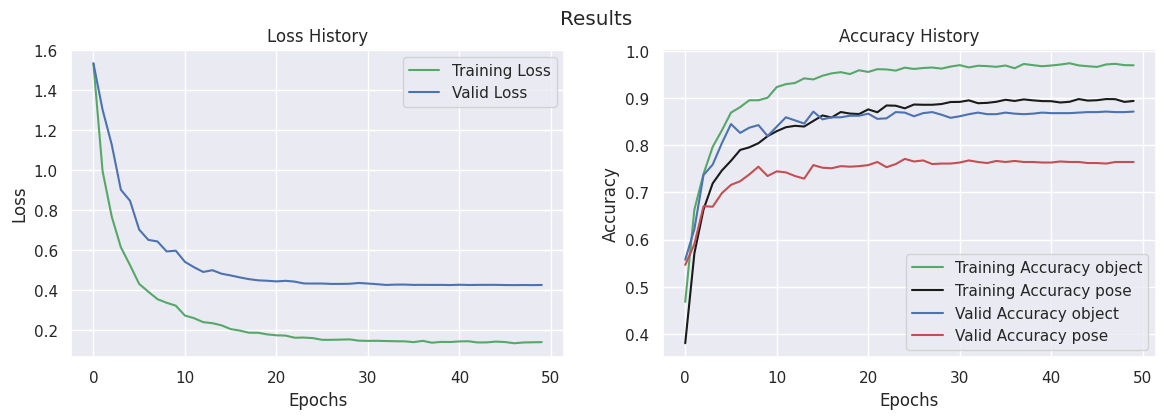

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

best model was trained at epoch: 15
with a validation loss of: 0.4827202 and a validation accuracy of: 87.11453676223755


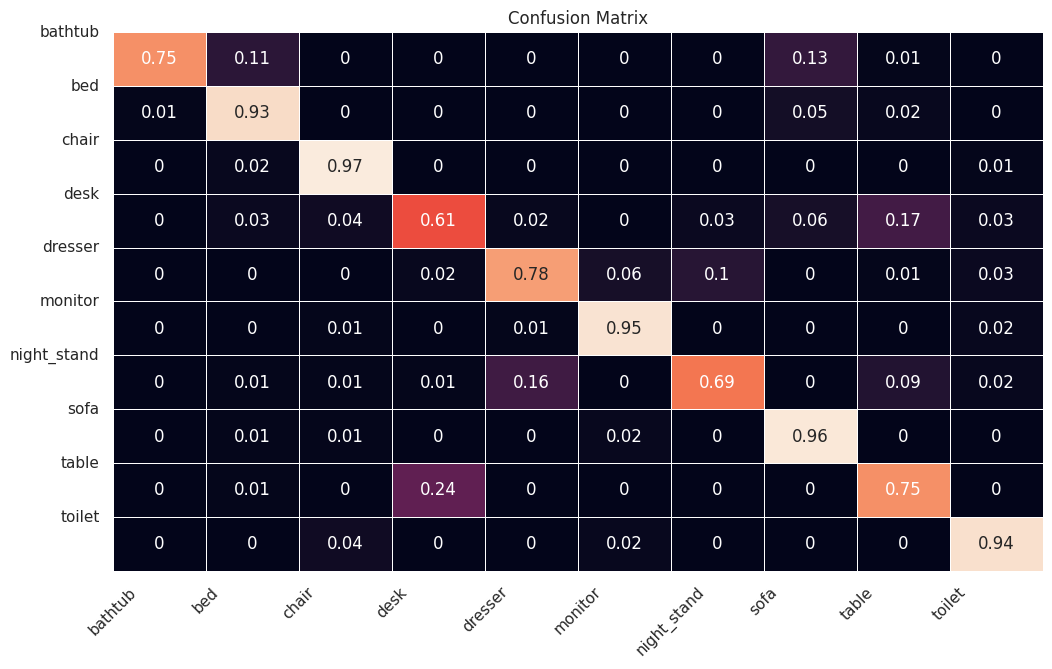

In [ ]:
trainer3.generateConfusionMatrix()

# Network model comparison

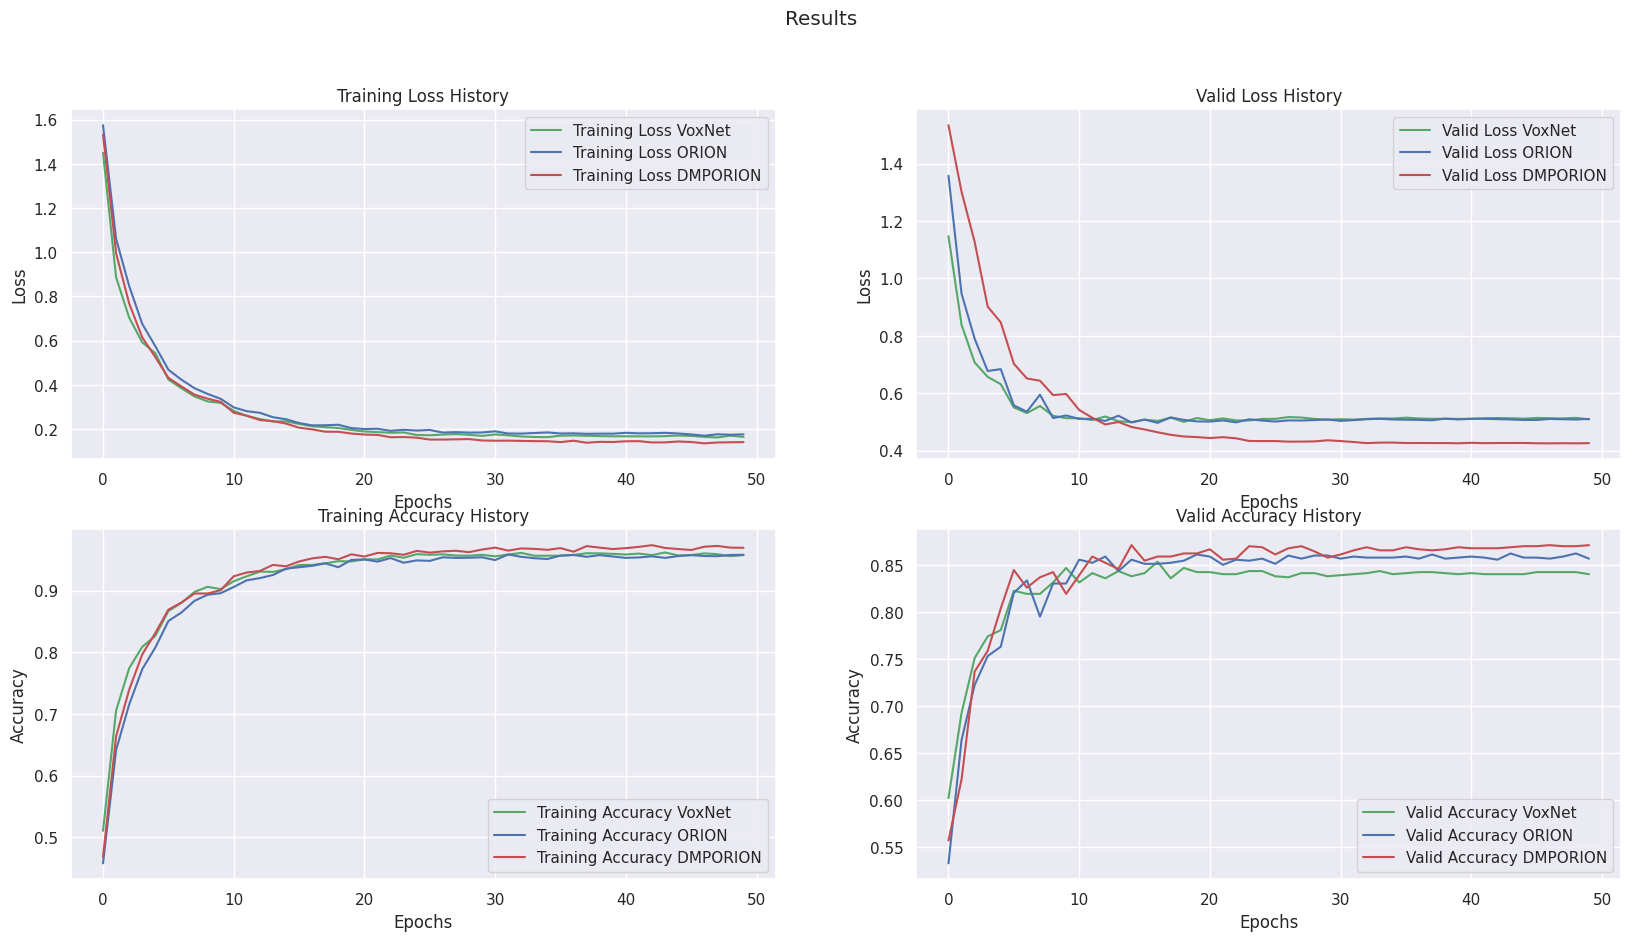

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))

sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')

ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss ORION')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPORION')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()

ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss ORION')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPORION')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc1"].cpu()), 'b', label='Training Accuracy ORION')
ax[1,0].plot(eps, smooth(history3["train_acc1"].cpu()), 'r', label='Training Accuracy DMPORION')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc1"].cpu()), 'b', label='Valid Accuracy ORION')
ax[1,1].plot(eps, smooth(history3["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPORION')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

best model was trained at epoch: 17
with a validation loss of: 0.50365144 and a validation accuracy of: 85.35242080688477
best model was trained at epoch: 44
with a validation loss of: 0.50880224 and a validation accuracy of: 86.23347878456116
best model was trained at epoch: 15
with a validation loss of: 0.4827202 and a validation accuracy of: 87.11453676223755


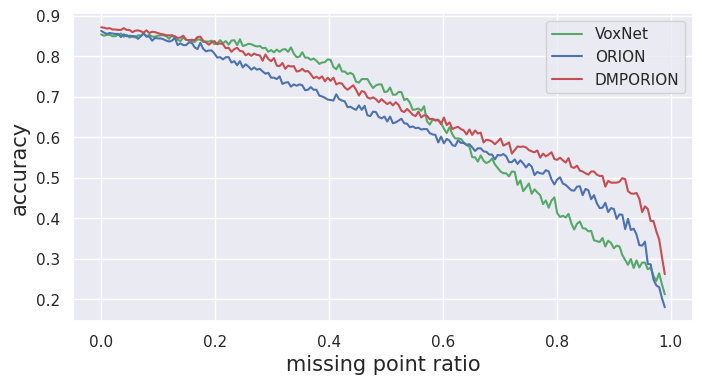

In [ ]:
eps1, acc1 = trainer1.missing_data_test()
eps2, acc2 = trainer2.missing_data_test()
eps3, acc3 = trainer3.missing_data_test()

sns.set_theme()
plt.figure(figsize=(8, 4))
line1 = plt.plot(eps1, smooth(acc1), 'g', label='VoxNet')
line2 = plt.plot(eps2, smooth(acc2), 'b', label='ORION')
line3 = plt.plot(eps3, smooth(acc3), 'r', label='DMPORION')

plt.xlabel("missing point ratio", size=15)
plt.ylabel("accuracy", size=15)
plt.legend()
plt.show()

# Data Augmentation



In [ ]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X_a = {'train': [], 'test': []}
Y_a = {'train': [], 'test': []}
Z_a = {'train': [], 'test': []}

for label1, cl in enumerate(CLASSES):
    for label2, rot in enumerate(ROTATIONS):
        split = 'train'
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
            voxel_index = []
            if 'off' in example:
              mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
              if rot == '0':
                mesh = mesh
              elif rot == '45':
                mesh.rotate(r45)
              elif rot == '90':
                mesh.rotate(r90)
              elif rot == '135':
                mesh.rotate(r135)
              elif rot == '180':
                mesh.rotate(r180)
              elif rot == '225':
                mesh.rotate(r225)
              elif rot == '270':
                mesh.rotate(r270)
              else:
                mesh.rotate(r315)

              mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
              voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

            X_a[split].append(voxel_grid)
            Y_a[split].append(label1)
            Z_a[split].append(label2)

rot = 0
for label1, cl in enumerate(CLASSES):
    split = 'test'
    examples_dir = os.path.join(ROOT, cl, split)
    for example in tqdm(os.listdir(examples_dir)):
        voxel_index = []
        if 'off' in example:
          mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
          if (rot%8)==0:
            mesh = mesh
            rotat = 0
            rot +=1
          elif (rot%8)==1:
            mesh.rotate(r45)
            rotat = 1
            rot +=1
          elif (rot%8)==2:
            mesh.rotate(r90)
            rotat = 2
            rot +=1
          elif (rot%8)==3:
            mesh.rotate(r135)
            rotat = 3
            rot +=1
          elif (rot%8)==4:
            mesh.rotate(r180)
            rotat = 4
            rot +=1
          elif (rot%8)==5:
            mesh.rotate(r225)
            rotat = 5
            rot +=1
          elif (rot%8)==6:
            mesh.rotate(r270)
            rotat = 6
            rot +=1
          else:
            mesh.rotate(r315)
            rotat = 7
            rot +=1
          mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
          voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

          X_a[split].append(voxel_grid)
          Y_a[split].append(label1)
          Z_a[split].append(rotat)


100%|██████████| 101/101 [00:05<00:00, 19.05it/s]


In [ ]:
class VoxNet_Dataset_a(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X_a['train']
          self.label1 = Y_a['train']
      else:
          self.data = X_a['test']
          self.label1 = Y_a['test']

    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):

        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1

In [ ]:
class VoxNet_Trainer_a():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0

      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()

  def initDataset(self):
      self.train_ds = VoxNet_Dataset_a(train=True)
      self.test_ds = VoxNet_Dataset_a(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "ORION":
          self.model = ORION()
          os.mkdir('/content/'+str(self.name_model))
          print("model ORION was chosen")
      else:
        self.model = DMPORION()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPORION was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)

      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.CrossEntropyLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training loss
          train_loss = []
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1 = data[0], data[1]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)

              self.opt.zero_grad()
              pred1 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.loss_fn(pred1, labels1)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu())

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")

          self.lr_scheduler.step()

          #test phase
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):
                inputs_test, labels_test1 = sample[0], sample[1]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                inputs_test = inputs_test.float()

                pred_test1 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.loss_fn(pred_test1, labels_test1)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu())

                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)


          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()


          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          valid_acc_history1.append(total_valid_accuracy1)

          elapsed_time_epoch = time.time() - t

          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1],
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')


          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1),
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1)}

  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))

      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)

  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))

      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')

      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()

      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]

      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()

  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']

      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)

          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0

          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())

      return test_accuracy.compute()

  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)

      return eps, acc

In [ ]:
training_hyperparameters = {
     "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet_a'
}

trainer4 = VoxNet_Trainer_a(training_hyperparameters)
trainer4.train()

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history4 = trainer4.getHistory()
trainer4.showResults()

In [ ]:
trainer4.generateConfusionMatrix()

In [ ]:
class Network_Dataset_a(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X_a['train']
          self.label1 = Y_a['train']
          self.label2 = Z_a['train']
      else:
          self.data = X_a['test']
          self.label1 = Y_a['test']
          self.label2 = Z_a['test']


    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):

        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
class Network_Trainer_a():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0

      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()

  def initDataset(self):
      self.train_ds = Network_Dataset_a(train=True)
      self.test_ds = Network_Dataset_a(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet_a":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "ORION_a":
          self.model = ORION()
          os.mkdir('/content/'+str(self.name_model))
          print("model ORION was chosen")
      else:
        self.model = DMPORION()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPORION was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)

      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.CrossEntropyLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      self.alpha = 2/3


      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training loss
          train_loss = []
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu())
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu())

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")

          self.lr_scheduler.step()

          #test phase
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []
            pred_test2 = []
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()

                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu())

                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)


          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()

          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)


          elapsed_time_epoch = time.time() - t

          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1],
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')


          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2),
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}

  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))

      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)

  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))

      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')

      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()

      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]

      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()

  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']

      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)

          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0

          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())

      return test_accuracy.compute()

  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)

      return eps, acc

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'ORION_a'
}

trainer5 = Network_Trainer_a(training_hyperparameters)
trainer5.train()

model ORION was chosen
499.25


Train loss: 0.7839014530181885: : 499it [03:07,  2.67it/s]
29it [00:05,  5.69it/s]


epoch:  1 / 50
time: 192.26 seconds
train-loss: 1.17, train-acc-object: 61.85%, train-acc-pose: 49.54%
valid-loss: 0.87, valid-acc-object: 69.38%, train-acc-pose: 62.11%



Train loss: 0.7322249412536621: : 499it [03:07,  2.66it/s]
29it [00:04,  7.24it/s]


epoch:  2 / 50
time: 191.41 seconds
train-loss: 0.67, train-acc-object: 79.32%, train-acc-pose: 67.24%
valid-loss: 0.64, valid-acc-object: 77.64%, train-acc-pose: 68.39%



Train loss: 0.5289471745491028: : 499it [03:07,  2.66it/s]
29it [00:04,  7.22it/s]


epoch:  3 / 50
time: 191.96 seconds
train-loss: 0.52, train-acc-object: 84.60%, train-acc-pose: 72.63%
valid-loss: 0.57, valid-acc-object: 79.96%, train-acc-pose: 72.91%



Train loss: 0.3178057372570038: : 499it [03:06,  2.67it/s]
29it [00:04,  5.95it/s]


epoch:  4 / 50
time: 191.89 seconds
train-loss: 0.46, train-acc-object: 86.90%, train-acc-pose: 75.00%
valid-loss: 0.49, valid-acc-object: 83.70%, train-acc-pose: 75.33%



Train loss: 0.3369133174419403: : 499it [03:07,  2.67it/s]
29it [00:03,  7.38it/s]


epoch:  5 / 50
time: 191.07 seconds
train-loss: 0.41, train-acc-object: 88.34%, train-acc-pose: 76.88%
valid-loss: 0.48, valid-acc-object: 83.37%, train-acc-pose: 75.77%



Train loss: 0.42158472537994385: : 499it [03:06,  2.68it/s]
29it [00:03,  7.34it/s]


epoch:  6 / 50
time: 190.42 seconds
train-loss: 0.37, train-acc-object: 89.44%, train-acc-pose: 78.27%
valid-loss: 0.46, valid-acc-object: 84.14%, train-acc-pose: 77.09%



Train loss: 0.34640607237815857: : 499it [03:08,  2.65it/s]
29it [00:04,  6.09it/s]


epoch:  7 / 50
time: 192.88 seconds
train-loss: 0.34, train-acc-object: 90.68%, train-acc-pose: 79.17%
valid-loss: 0.48, valid-acc-object: 83.70%, train-acc-pose: 77.86%



Train loss: 0.25092029571533203: : 499it [03:04,  2.71it/s]
29it [00:03,  7.32it/s]


epoch:  8 / 50
time: 188.36 seconds
train-loss: 0.32, train-acc-object: 91.43%, train-acc-pose: 79.94%
valid-loss: 0.42, valid-acc-object: 85.79%, train-acc-pose: 78.41%



Train loss: 0.2333703637123108: : 499it [03:05,  2.69it/s]
29it [00:03,  7.26it/s]


epoch:  9 / 50
time: 189.80 seconds
train-loss: 0.30, train-acc-object: 91.85%, train-acc-pose: 80.71%
valid-loss: 0.39, valid-acc-object: 86.56%, train-acc-pose: 79.96%



Train loss: 0.3676395118236542: : 499it [03:06,  2.68it/s]
29it [00:04,  6.68it/s]


epoch: 10 / 50
time: 190.76 seconds
train-loss: 0.29, train-acc-object: 92.34%, train-acc-pose: 81.29%
valid-loss: 0.40, valid-acc-object: 87.00%, train-acc-pose: 80.40%



Train loss: 0.19921265542507172: : 499it [03:04,  2.71it/s]
29it [00:04,  5.86it/s]


epoch: 11 / 50
time: 189.38 seconds
train-loss: 0.26, train-acc-object: 93.43%, train-acc-pose: 81.96%
valid-loss: 0.39, valid-acc-object: 86.45%, train-acc-pose: 81.06%



Train loss: 0.28675341606140137: : 499it [03:03,  2.72it/s]
29it [00:04,  6.27it/s]


epoch: 12 / 50
time: 188.04 seconds
train-loss: 0.25, train-acc-object: 93.64%, train-acc-pose: 82.32%
valid-loss: 0.38, valid-acc-object: 87.11%, train-acc-pose: 80.18%



Train loss: 0.3449140191078186: : 499it [03:04,  2.71it/s]
29it [00:04,  5.87it/s]


epoch: 13 / 50
time: 189.07 seconds
train-loss: 0.25, train-acc-object: 93.97%, train-acc-pose: 82.68%
valid-loss: 0.37, valid-acc-object: 87.00%, train-acc-pose: 81.39%



Train loss: 0.27520516514778137: : 499it [03:03,  2.73it/s]
29it [00:04,  6.00it/s]


epoch: 14 / 50
time: 187.96 seconds
train-loss: 0.24, train-acc-object: 94.01%, train-acc-pose: 82.69%
valid-loss: 0.37, valid-acc-object: 87.67%, train-acc-pose: 81.39%



Train loss: 0.20799654722213745: : 499it [03:05,  2.69it/s]
29it [00:03,  7.32it/s]


epoch: 15 / 50
time: 189.42 seconds
train-loss: 0.24, train-acc-object: 94.37%, train-acc-pose: 82.87%
valid-loss: 0.36, valid-acc-object: 88.22%, train-acc-pose: 81.28%



Train loss: 0.39565038681030273: : 499it [03:03,  2.72it/s]
29it [00:03,  7.50it/s]


epoch: 16 / 50
time: 187.14 seconds
train-loss: 0.24, train-acc-object: 94.31%, train-acc-pose: 82.73%
valid-loss: 0.36, valid-acc-object: 88.22%, train-acc-pose: 80.84%



Train loss: 0.2574878931045532: : 499it [03:03,  2.73it/s]
29it [00:03,  7.58it/s]


epoch: 17 / 50
time: 186.88 seconds
train-loss: 0.23, train-acc-object: 94.58%, train-acc-pose: 83.02%
valid-loss: 0.36, valid-acc-object: 88.11%, train-acc-pose: 82.49%



Train loss: 0.2192918062210083: : 499it [03:02,  2.73it/s]
29it [00:03,  7.76it/s]


epoch: 18 / 50
time: 186.59 seconds
train-loss: 0.22, train-acc-object: 94.84%, train-acc-pose: 83.30%
valid-loss: 0.36, valid-acc-object: 88.55%, train-acc-pose: 81.17%



Train loss: 0.16236555576324463: : 499it [03:00,  2.76it/s]
29it [00:03,  7.38it/s]


epoch: 19 / 50
time: 184.77 seconds
train-loss: 0.22, train-acc-object: 94.77%, train-acc-pose: 83.18%
valid-loss: 0.36, valid-acc-object: 88.44%, train-acc-pose: 82.27%



Train loss: 0.2089124470949173: : 499it [03:01,  2.76it/s]
29it [00:04,  6.55it/s]


epoch: 20 / 50
time: 185.53 seconds
train-loss: 0.22, train-acc-object: 94.99%, train-acc-pose: 83.38%
valid-loss: 0.35, valid-acc-object: 88.55%, train-acc-pose: 81.72%



Train loss: 0.13111266493797302: : 499it [03:01,  2.75it/s]
29it [00:04,  5.99it/s]


epoch: 21 / 50
time: 186.28 seconds
train-loss: 0.21, train-acc-object: 95.31%, train-acc-pose: 83.73%
valid-loss: 0.35, valid-acc-object: 88.77%, train-acc-pose: 81.83%



Train loss: 0.1623431146144867: : 499it [02:55,  2.84it/s]
29it [00:03,  7.64it/s]


epoch: 22 / 50
time: 179.56 seconds
train-loss: 0.21, train-acc-object: 95.39%, train-acc-pose: 84.06%
valid-loss: 0.35, valid-acc-object: 88.77%, train-acc-pose: 81.39%



Train loss: 0.23905521631240845: : 499it [02:58,  2.79it/s]
29it [00:04,  6.76it/s]


epoch: 23 / 50
time: 182.99 seconds
train-loss: 0.20, train-acc-object: 95.53%, train-acc-pose: 84.04%
valid-loss: 0.36, valid-acc-object: 88.33%, train-acc-pose: 81.72%



Train loss: 0.22602787613868713: : 499it [02:56,  2.83it/s]
29it [00:03,  7.85it/s]


epoch: 24 / 50
time: 180.01 seconds
train-loss: 0.20, train-acc-object: 95.62%, train-acc-pose: 84.25%
valid-loss: 0.35, valid-acc-object: 88.77%, train-acc-pose: 81.61%



Train loss: 0.30547335743904114: : 499it [02:56,  2.82it/s]
29it [00:03,  7.73it/s]


epoch: 25 / 50
time: 180.71 seconds
train-loss: 0.20, train-acc-object: 95.64%, train-acc-pose: 84.03%
valid-loss: 0.35, valid-acc-object: 89.10%, train-acc-pose: 81.94%



Train loss: 0.20794343948364258: : 499it [02:54,  2.86it/s]
29it [00:03,  8.22it/s]


epoch: 26 / 50
time: 178.20 seconds
train-loss: 0.20, train-acc-object: 95.69%, train-acc-pose: 84.24%
valid-loss: 0.35, valid-acc-object: 88.77%, train-acc-pose: 81.28%



Train loss: 0.203700989484787: : 499it [02:52,  2.89it/s]
29it [00:04,  6.31it/s]


epoch: 27 / 50
time: 177.40 seconds
train-loss: 0.20, train-acc-object: 95.89%, train-acc-pose: 84.34%
valid-loss: 0.35, valid-acc-object: 88.99%, train-acc-pose: 81.39%



Train loss: 0.1652647852897644: : 499it [02:55,  2.85it/s]
29it [00:03,  8.33it/s]


epoch: 28 / 50
time: 178.77 seconds
train-loss: 0.20, train-acc-object: 95.86%, train-acc-pose: 84.26%
valid-loss: 0.35, valid-acc-object: 88.77%, train-acc-pose: 81.94%



Train loss: 0.21417030692100525: : 499it [02:55,  2.85it/s]
29it [00:03,  7.55it/s]


epoch: 29 / 50
time: 178.98 seconds
train-loss: 0.19, train-acc-object: 95.81%, train-acc-pose: 84.25%
valid-loss: 0.35, valid-acc-object: 88.77%, train-acc-pose: 80.84%



Train loss: 0.23472166061401367: : 499it [02:51,  2.91it/s]
29it [00:04,  6.30it/s]


epoch: 30 / 50
time: 176.30 seconds
train-loss: 0.19, train-acc-object: 95.92%, train-acc-pose: 84.35%
valid-loss: 0.34, valid-acc-object: 88.88%, train-acc-pose: 82.38%



Train loss: 0.16651509702205658: : 499it [02:52,  2.90it/s]
29it [00:03,  8.09it/s]


epoch: 31 / 50
time: 175.74 seconds
train-loss: 0.19, train-acc-object: 96.08%, train-acc-pose: 84.62%
valid-loss: 0.35, valid-acc-object: 88.88%, train-acc-pose: 82.71%



Train loss: 0.14152847230434418: : 499it [02:53,  2.87it/s]
29it [00:03,  8.03it/s]


epoch: 32 / 50
time: 177.21 seconds
train-loss: 0.19, train-acc-object: 96.21%, train-acc-pose: 84.58%
valid-loss: 0.35, valid-acc-object: 88.99%, train-acc-pose: 81.72%



Train loss: 0.25288936495780945: : 499it [02:51,  2.90it/s]
29it [00:03,  7.87it/s]


epoch: 33 / 50
time: 175.64 seconds
train-loss: 0.19, train-acc-object: 96.13%, train-acc-pose: 84.43%
valid-loss: 0.34, valid-acc-object: 88.66%, train-acc-pose: 81.94%



Train loss: 0.21987880766391754: : 499it [02:54,  2.86it/s]
29it [00:03,  8.25it/s]


epoch: 34 / 50
time: 177.72 seconds
train-loss: 0.19, train-acc-object: 96.14%, train-acc-pose: 85.12%
valid-loss: 0.34, valid-acc-object: 88.66%, train-acc-pose: 82.27%



Train loss: 0.1857335865497589: : 499it [02:53,  2.87it/s]
29it [00:04,  6.32it/s]


epoch: 35 / 50
time: 178.55 seconds
train-loss: 0.18, train-acc-object: 96.35%, train-acc-pose: 84.69%
valid-loss: 0.35, valid-acc-object: 88.88%, train-acc-pose: 81.94%



Train loss: 0.19902941584587097: : 499it [02:49,  2.95it/s]
29it [00:04,  6.42it/s]


epoch: 36 / 50
time: 173.90 seconds
train-loss: 0.19, train-acc-object: 96.16%, train-acc-pose: 84.85%
valid-loss: 0.35, valid-acc-object: 88.77%, train-acc-pose: 81.61%



Train loss: 0.17110830545425415: : 499it [02:49,  2.95it/s]
29it [00:04,  6.32it/s]


epoch: 37 / 50
time: 173.95 seconds
train-loss: 0.18, train-acc-object: 96.33%, train-acc-pose: 85.26%
valid-loss: 0.35, valid-acc-object: 88.88%, train-acc-pose: 82.27%



Train loss: 0.18826404213905334: : 499it [02:50,  2.93it/s]
29it [00:04,  7.13it/s]


epoch: 38 / 50
time: 174.18 seconds
train-loss: 0.18, train-acc-object: 96.28%, train-acc-pose: 84.72%
valid-loss: 0.34, valid-acc-object: 89.32%, train-acc-pose: 80.95%



Train loss: 0.15252067148685455: : 499it [02:48,  2.97it/s]
29it [00:03,  8.42it/s]


epoch: 39 / 50
time: 171.52 seconds
train-loss: 0.18, train-acc-object: 96.36%, train-acc-pose: 85.04%
valid-loss: 0.35, valid-acc-object: 89.10%, train-acc-pose: 82.05%



Train loss: 0.17991623282432556: : 499it [02:47,  2.97it/s]
29it [00:03,  8.65it/s]


epoch: 40 / 50
time: 171.23 seconds
train-loss: 0.18, train-acc-object: 96.19%, train-acc-pose: 84.99%
valid-loss: 0.35, valid-acc-object: 88.77%, train-acc-pose: 81.83%



Train loss: 0.18571923673152924: : 499it [02:45,  3.01it/s]
29it [00:03,  8.11it/s]


epoch: 41 / 50
time: 169.38 seconds
train-loss: 0.18, train-acc-object: 96.48%, train-acc-pose: 84.80%
valid-loss: 0.35, valid-acc-object: 88.99%, train-acc-pose: 81.83%



Train loss: 0.1548687219619751: : 499it [02:43,  3.05it/s]
29it [00:03,  8.13it/s]


epoch: 42 / 50
time: 167.17 seconds
train-loss: 0.18, train-acc-object: 96.42%, train-acc-pose: 85.20%
valid-loss: 0.35, valid-acc-object: 89.21%, train-acc-pose: 82.38%



Train loss: 0.11606156826019287: : 499it [02:44,  3.04it/s]
29it [00:03,  8.65it/s]


epoch: 43 / 50
time: 167.62 seconds
train-loss: 0.18, train-acc-object: 96.41%, train-acc-pose: 85.12%
valid-loss: 0.35, valid-acc-object: 89.10%, train-acc-pose: 81.83%



Train loss: 0.1645965874195099: : 499it [02:44,  3.04it/s]
29it [00:04,  6.54it/s]


epoch: 44 / 50
time: 168.74 seconds
train-loss: 0.18, train-acc-object: 96.46%, train-acc-pose: 85.00%
valid-loss: 0.35, valid-acc-object: 88.99%, train-acc-pose: 81.72%



Train loss: 0.19470879435539246: : 499it [02:42,  3.08it/s]
29it [00:03,  8.99it/s]


epoch: 45 / 50
time: 165.32 seconds
train-loss: 0.18, train-acc-object: 96.52%, train-acc-pose: 84.97%
valid-loss: 0.35, valid-acc-object: 89.21%, train-acc-pose: 81.61%



Train loss: 0.1436907798051834: : 499it [02:42,  3.06it/s]
29it [00:04,  6.70it/s]


epoch: 46 / 50
time: 167.18 seconds
train-loss: 0.18, train-acc-object: 96.46%, train-acc-pose: 85.26%
valid-loss: 0.34, valid-acc-object: 89.21%, train-acc-pose: 81.83%



Train loss: 0.22990024089813232: : 499it [02:42,  3.07it/s]
29it [00:03,  9.03it/s]


epoch: 47 / 50
time: 165.99 seconds
train-loss: 0.18, train-acc-object: 96.46%, train-acc-pose: 85.03%
valid-loss: 0.35, valid-acc-object: 89.32%, train-acc-pose: 82.05%



Train loss: 0.1642940789461136: : 499it [02:41,  3.10it/s]
29it [00:03,  7.81it/s]


epoch: 48 / 50
time: 164.91 seconds
train-loss: 0.18, train-acc-object: 96.53%, train-acc-pose: 84.99%
valid-loss: 0.35, valid-acc-object: 89.21%, train-acc-pose: 82.38%



Train loss: 0.1981872022151947: : 499it [02:42,  3.08it/s]
29it [00:03,  8.98it/s]


epoch: 49 / 50
time: 165.26 seconds
train-loss: 0.17, train-acc-object: 96.62%, train-acc-pose: 85.05%
valid-loss: 0.35, valid-acc-object: 88.99%, train-acc-pose: 81.83%



Train loss: 0.23038789629936218: : 499it [02:42,  3.08it/s]
29it [00:03,  8.94it/s]

epoch: 50 / 50
time: 165.32 seconds
train-loss: 0.18, train-acc-object: 96.59%, train-acc-pose: 84.92%
valid-loss: 0.34, valid-acc-object: 88.66%, train-acc-pose: 81.61%



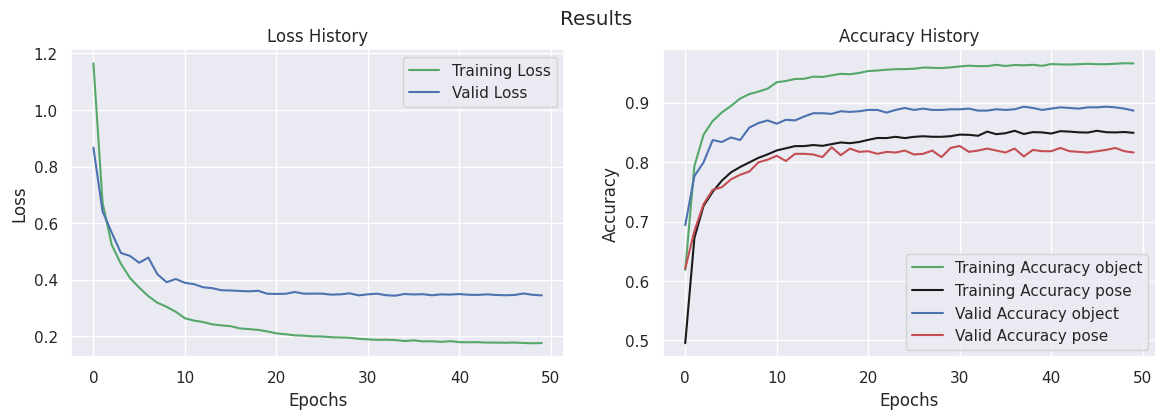

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history5 = trainer5.getHistory()
trainer5.showResults()

best model was trained at epoch: 38
with a validation loss of: 0.34468406 and a validation accuracy of: 89.31717872619629


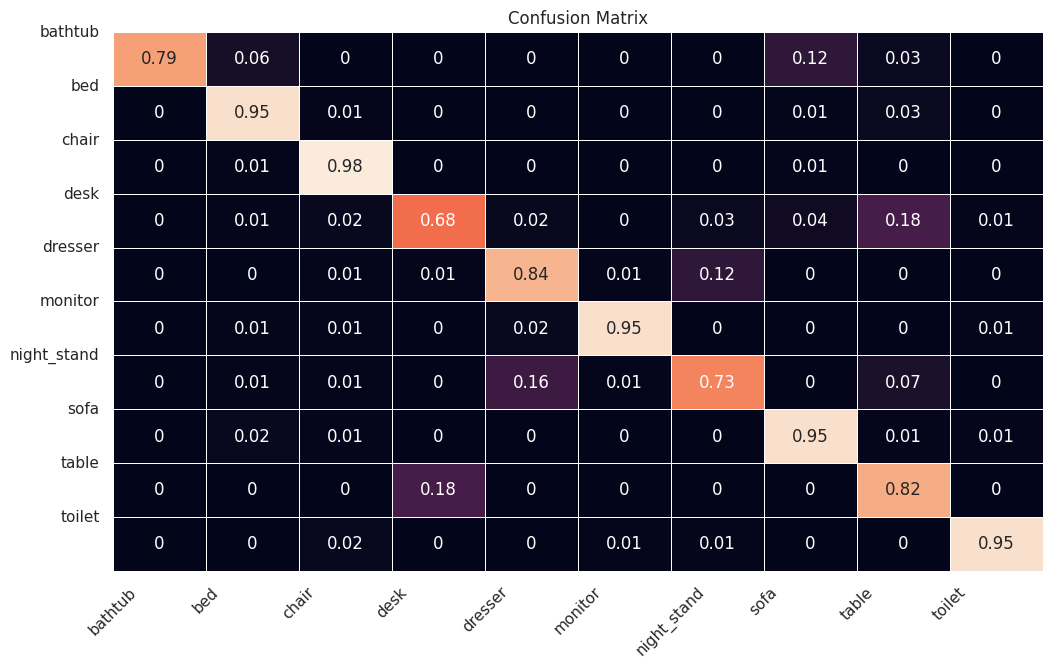

In [ ]:
trainer5.generateConfusionMatrix()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPORION_a'
}

trainer6 = Network_Trainer_a(training_hyperparameters)
trainer6.train()

model DMPORION was choosen
499.25


Train loss: 0.8450281023979187: : 499it [04:10,  1.99it/s]
29it [00:04,  7.24it/s]


epoch:  1 / 50
time: 254.54 seconds
train-loss: 1.08, train-acc-object: 64.66%, train-acc-pose: 51.78%
valid-loss: 1.06, valid-acc-object: 74.23%, train-acc-pose: 64.98%



Train loss: 0.414100706577301: : 499it [04:08,  2.01it/s]
29it [00:04,  6.62it/s]


epoch:  2 / 50
time: 253.06 seconds
train-loss: 0.57, train-acc-object: 82.51%, train-acc-pose: 72.06%
valid-loss: 0.81, valid-acc-object: 81.06%, train-acc-pose: 72.14%



Train loss: 0.31552207469940186: : 499it [04:08,  2.01it/s]
29it [00:04,  6.51it/s]


epoch:  3 / 50
time: 252.65 seconds
train-loss: 0.44, train-acc-object: 86.84%, train-acc-pose: 75.91%
valid-loss: 0.70, valid-acc-object: 81.06%, train-acc-pose: 75.11%



Train loss: 0.49958840012550354: : 499it [04:07,  2.01it/s]
29it [00:04,  6.40it/s]


epoch:  4 / 50
time: 252.37 seconds
train-loss: 0.39, train-acc-object: 88.94%, train-acc-pose: 77.77%
valid-loss: 0.63, valid-acc-object: 85.13%, train-acc-pose: 75.55%



Train loss: 0.29288408160209656: : 499it [04:07,  2.01it/s]
29it [00:04,  6.86it/s]


epoch:  5 / 50
time: 252.06 seconds
train-loss: 0.35, train-acc-object: 90.19%, train-acc-pose: 78.98%
valid-loss: 0.58, valid-acc-object: 86.23%, train-acc-pose: 77.64%



Train loss: 0.3921617269515991: : 499it [04:09,  2.00it/s]
29it [00:04,  7.18it/s]


epoch:  6 / 50
time: 253.92 seconds
train-loss: 0.32, train-acc-object: 91.04%, train-acc-pose: 79.73%
valid-loss: 0.53, valid-acc-object: 88.22%, train-acc-pose: 76.10%



Train loss: 0.3364122211933136: : 499it [04:09,  2.00it/s]
29it [00:04,  6.48it/s]


epoch:  7 / 50
time: 253.79 seconds
train-loss: 0.29, train-acc-object: 92.22%, train-acc-pose: 80.46%
valid-loss: 0.51, valid-acc-object: 86.78%, train-acc-pose: 78.30%



Train loss: 0.2829214036464691: : 499it [04:08,  2.01it/s]
29it [00:04,  6.97it/s]


epoch:  8 / 50
time: 252.47 seconds
train-loss: 0.28, train-acc-object: 92.66%, train-acc-pose: 80.86%
valid-loss: 0.50, valid-acc-object: 87.00%, train-acc-pose: 78.96%



Train loss: 0.2647148072719574: : 499it [04:07,  2.02it/s]
29it [00:03,  7.64it/s]


epoch:  9 / 50
time: 251.26 seconds
train-loss: 0.26, train-acc-object: 93.14%, train-acc-pose: 81.42%
valid-loss: 0.49, valid-acc-object: 85.79%, train-acc-pose: 79.63%



Train loss: 0.4559783935546875: : 499it [04:07,  2.02it/s]
29it [00:03,  7.69it/s]


epoch: 10 / 50
time: 251.22 seconds
train-loss: 0.25, train-acc-object: 93.68%, train-acc-pose: 81.87%
valid-loss: 0.46, valid-acc-object: 88.88%, train-acc-pose: 79.63%



Train loss: 0.17568691074848175: : 499it [04:08,  2.01it/s]
29it [00:03,  7.75it/s]


epoch: 11 / 50
time: 252.32 seconds
train-loss: 0.22, train-acc-object: 94.92%, train-acc-pose: 82.75%
valid-loss: 0.43, valid-acc-object: 89.32%, train-acc-pose: 79.07%



Train loss: 0.19528982043266296: : 499it [04:06,  2.03it/s]
29it [00:03,  7.54it/s]


epoch: 12 / 50
time: 249.99 seconds
train-loss: 0.21, train-acc-object: 95.04%, train-acc-pose: 82.65%
valid-loss: 0.42, valid-acc-object: 87.89%, train-acc-pose: 80.40%



Train loss: 0.2788810729980469: : 499it [04:06,  2.03it/s]
29it [00:04,  6.05it/s]


epoch: 13 / 50
time: 251.20 seconds
train-loss: 0.21, train-acc-object: 95.41%, train-acc-pose: 83.42%
valid-loss: 0.42, valid-acc-object: 88.88%, train-acc-pose: 81.17%



Train loss: 0.19332875311374664: : 499it [04:05,  2.03it/s]
29it [00:04,  7.14it/s]


epoch: 14 / 50
time: 249.49 seconds
train-loss: 0.20, train-acc-object: 95.37%, train-acc-pose: 83.24%
valid-loss: 0.41, valid-acc-object: 87.56%, train-acc-pose: 80.40%



Train loss: 0.12399887293577194: : 499it [04:05,  2.04it/s]
29it [00:03,  7.77it/s]


epoch: 15 / 50
time: 248.92 seconds
train-loss: 0.20, train-acc-object: 95.51%, train-acc-pose: 83.31%
valid-loss: 0.41, valid-acc-object: 89.43%, train-acc-pose: 80.73%



Train loss: 0.16414934396743774: : 499it [04:03,  2.05it/s]
29it [00:04,  6.16it/s]


epoch: 16 / 50
time: 248.14 seconds
train-loss: 0.20, train-acc-object: 95.79%, train-acc-pose: 83.43%
valid-loss: 0.40, valid-acc-object: 89.54%, train-acc-pose: 80.40%



Train loss: 0.25650376081466675: : 499it [04:02,  2.06it/s]
29it [00:03,  8.32it/s]


epoch: 17 / 50
time: 245.95 seconds
train-loss: 0.19, train-acc-object: 95.97%, train-acc-pose: 83.60%
valid-loss: 0.39, valid-acc-object: 87.22%, train-acc-pose: 81.28%



Train loss: 0.17606180906295776: : 499it [03:57,  2.10it/s]
29it [00:03,  8.40it/s]


epoch: 18 / 50
time: 241.46 seconds
train-loss: 0.19, train-acc-object: 96.23%, train-acc-pose: 83.92%
valid-loss: 0.39, valid-acc-object: 89.76%, train-acc-pose: 81.17%



Train loss: 0.2510547339916229: : 499it [03:55,  2.12it/s]
29it [00:03,  8.32it/s]


epoch: 19 / 50
time: 239.28 seconds
train-loss: 0.18, train-acc-object: 96.24%, train-acc-pose: 83.81%
valid-loss: 0.38, valid-acc-object: 88.33%, train-acc-pose: 81.50%



Train loss: 0.12778185307979584: : 499it [03:58,  2.09it/s]
29it [00:03,  8.47it/s]


epoch: 20 / 50
time: 241.73 seconds
train-loss: 0.18, train-acc-object: 96.29%, train-acc-pose: 84.05%
valid-loss: 0.37, valid-acc-object: 89.21%, train-acc-pose: 81.61%



Train loss: 0.12880200147628784: : 499it [03:57,  2.10it/s]
29it [00:03,  8.21it/s]


epoch: 21 / 50
time: 240.84 seconds
train-loss: 0.17, train-acc-object: 96.83%, train-acc-pose: 84.53%
valid-loss: 0.37, valid-acc-object: 88.99%, train-acc-pose: 82.49%



Train loss: 0.2428910732269287: : 499it [03:56,  2.11it/s]
29it [00:03,  8.12it/s]


epoch: 22 / 50
time: 240.12 seconds
train-loss: 0.17, train-acc-object: 96.79%, train-acc-pose: 84.48%
valid-loss: 0.36, valid-acc-object: 89.10%, train-acc-pose: 82.82%



Train loss: 0.17133617401123047: : 499it [03:55,  2.12it/s]
29it [00:03,  7.90it/s]


epoch: 23 / 50
time: 238.76 seconds
train-loss: 0.17, train-acc-object: 96.88%, train-acc-pose: 84.69%
valid-loss: 0.36, valid-acc-object: 89.32%, train-acc-pose: 82.71%



Train loss: 0.14460572600364685: : 499it [03:57,  2.10it/s]
29it [00:03,  8.32it/s]


epoch: 24 / 50
time: 241.42 seconds
train-loss: 0.16, train-acc-object: 97.00%, train-acc-pose: 84.76%
valid-loss: 0.36, valid-acc-object: 89.54%, train-acc-pose: 82.38%



Train loss: 0.1944122165441513: : 499it [03:55,  2.12it/s]
29it [00:03,  8.54it/s]


epoch: 25 / 50
time: 238.69 seconds
train-loss: 0.16, train-acc-object: 97.03%, train-acc-pose: 84.74%
valid-loss: 0.35, valid-acc-object: 90.20%, train-acc-pose: 81.06%



Train loss: 0.19222807884216309: : 499it [03:53,  2.13it/s]
29it [00:03,  8.69it/s]


epoch: 26 / 50
time: 237.12 seconds
train-loss: 0.16, train-acc-object: 96.99%, train-acc-pose: 84.82%
valid-loss: 0.36, valid-acc-object: 89.10%, train-acc-pose: 81.61%



Train loss: 0.16678379476070404: : 499it [03:54,  2.12it/s]
29it [00:04,  6.58it/s]


epoch: 27 / 50
time: 239.39 seconds
train-loss: 0.16, train-acc-object: 96.99%, train-acc-pose: 84.99%
valid-loss: 0.35, valid-acc-object: 90.20%, train-acc-pose: 82.27%



Train loss: 0.15023554861545563: : 499it [03:53,  2.13it/s]
29it [00:04,  6.49it/s]


epoch: 28 / 50
time: 238.48 seconds
train-loss: 0.16, train-acc-object: 97.21%, train-acc-pose: 85.01%
valid-loss: 0.36, valid-acc-object: 88.88%, train-acc-pose: 82.16%



Train loss: 0.19384783506393433: : 499it [03:52,  2.15it/s]
29it [00:03,  7.35it/s]


epoch: 29 / 50
time: 236.53 seconds
train-loss: 0.16, train-acc-object: 97.26%, train-acc-pose: 84.96%
valid-loss: 0.35, valid-acc-object: 89.76%, train-acc-pose: 83.15%



Train loss: 0.12376408278942108: : 499it [03:53,  2.14it/s]
29it [00:03,  8.52it/s]


epoch: 30 / 50
time: 236.49 seconds
train-loss: 0.16, train-acc-object: 97.22%, train-acc-pose: 85.00%
valid-loss: 0.34, valid-acc-object: 90.64%, train-acc-pose: 81.83%



Train loss: 0.24762384593486786: : 499it [03:52,  2.14it/s]
29it [00:03,  8.57it/s]


epoch: 31 / 50
time: 236.26 seconds
train-loss: 0.15, train-acc-object: 97.45%, train-acc-pose: 85.24%
valid-loss: 0.34, valid-acc-object: 89.87%, train-acc-pose: 82.93%



Train loss: 0.19214172661304474: : 499it [03:51,  2.15it/s]
29it [00:04,  6.55it/s]


epoch: 32 / 50
time: 236.07 seconds
train-loss: 0.15, train-acc-object: 97.53%, train-acc-pose: 85.31%
valid-loss: 0.34, valid-acc-object: 89.98%, train-acc-pose: 82.38%



Train loss: 0.12205086648464203: : 499it [03:51,  2.16it/s]
29it [00:03,  8.62it/s]


epoch: 33 / 50
time: 234.69 seconds
train-loss: 0.15, train-acc-object: 97.51%, train-acc-pose: 85.36%
valid-loss: 0.34, valid-acc-object: 90.42%, train-acc-pose: 82.93%



Train loss: 0.14953872561454773: : 499it [03:52,  2.15it/s]
29it [00:03,  8.76it/s]


epoch: 34 / 50
time: 235.71 seconds
train-loss: 0.15, train-acc-object: 97.55%, train-acc-pose: 85.28%
valid-loss: 0.34, valid-acc-object: 90.20%, train-acc-pose: 82.49%



Train loss: 0.12207238376140594: : 499it [03:51,  2.15it/s]
29it [00:04,  6.40it/s]


epoch: 35 / 50
time: 236.26 seconds
train-loss: 0.15, train-acc-object: 97.52%, train-acc-pose: 85.30%
valid-loss: 0.34, valid-acc-object: 90.42%, train-acc-pose: 82.93%



Train loss: 0.13719940185546875: : 499it [03:51,  2.16it/s]
29it [00:03,  8.59it/s]


epoch: 36 / 50
time: 234.87 seconds
train-loss: 0.15, train-acc-object: 97.55%, train-acc-pose: 85.21%
valid-loss: 0.34, valid-acc-object: 89.65%, train-acc-pose: 82.60%



Train loss: 0.12063375860452652: : 499it [03:53,  2.14it/s]
29it [00:03,  8.60it/s]


epoch: 37 / 50
time: 237.06 seconds
train-loss: 0.15, train-acc-object: 97.54%, train-acc-pose: 85.32%
valid-loss: 0.34, valid-acc-object: 89.32%, train-acc-pose: 82.93%



Train loss: 0.1552603840827942: : 499it [03:51,  2.16it/s]
29it [00:03,  8.21it/s]


epoch: 38 / 50
time: 234.69 seconds
train-loss: 0.15, train-acc-object: 97.60%, train-acc-pose: 85.25%
valid-loss: 0.34, valid-acc-object: 90.31%, train-acc-pose: 82.60%



Train loss: 0.15473517775535583: : 499it [03:51,  2.16it/s]
29it [00:04,  6.93it/s]


epoch: 39 / 50
time: 235.43 seconds
train-loss: 0.14, train-acc-object: 97.69%, train-acc-pose: 85.48%
valid-loss: 0.34, valid-acc-object: 89.76%, train-acc-pose: 83.48%



Train loss: 0.08709666132926941: : 499it [03:51,  2.16it/s]
29it [00:03,  8.67it/s]


epoch: 40 / 50
time: 234.82 seconds
train-loss: 0.15, train-acc-object: 97.57%, train-acc-pose: 85.40%
valid-loss: 0.34, valid-acc-object: 90.09%, train-acc-pose: 83.59%



Train loss: 0.1268066018819809: : 499it [03:50,  2.16it/s]
29it [00:04,  6.63it/s]


epoch: 41 / 50
time: 235.32 seconds
train-loss: 0.14, train-acc-object: 97.84%, train-acc-pose: 85.48%
valid-loss: 0.33, valid-acc-object: 89.76%, train-acc-pose: 83.92%



Train loss: 0.1162848025560379: : 499it [03:50,  2.17it/s]
29it [00:03,  8.81it/s]


epoch: 42 / 50
time: 233.58 seconds
train-loss: 0.14, train-acc-object: 97.72%, train-acc-pose: 85.67%
valid-loss: 0.33, valid-acc-object: 89.87%, train-acc-pose: 83.81%



Train loss: 0.11264979094266891: : 499it [03:51,  2.16it/s]
29it [00:03,  8.70it/s]


epoch: 43 / 50
time: 234.65 seconds
train-loss: 0.14, train-acc-object: 97.77%, train-acc-pose: 85.71%
valid-loss: 0.33, valid-acc-object: 90.09%, train-acc-pose: 82.71%



Train loss: 0.11672177910804749: : 499it [03:49,  2.17it/s]
29it [00:04,  6.92it/s]


epoch: 44 / 50
time: 234.02 seconds
train-loss: 0.14, train-acc-object: 97.91%, train-acc-pose: 85.69%
valid-loss: 0.33, valid-acc-object: 90.09%, train-acc-pose: 83.04%



Train loss: 0.17153635621070862: : 499it [03:50,  2.16it/s]
29it [00:03,  8.75it/s]


epoch: 45 / 50
time: 233.82 seconds
train-loss: 0.14, train-acc-object: 97.85%, train-acc-pose: 85.71%
valid-loss: 0.33, valid-acc-object: 89.87%, train-acc-pose: 83.37%



Train loss: 0.19273629784584045: : 499it [03:49,  2.17it/s]
29it [00:04,  6.70it/s]


epoch: 46 / 50
time: 234.02 seconds
train-loss: 0.14, train-acc-object: 97.81%, train-acc-pose: 85.82%
valid-loss: 0.34, valid-acc-object: 89.87%, train-acc-pose: 83.26%



Train loss: 0.1682075411081314: : 499it [03:50,  2.17it/s]
29it [00:03,  8.78it/s]


epoch: 47 / 50
time: 233.51 seconds
train-loss: 0.14, train-acc-object: 97.85%, train-acc-pose: 85.56%
valid-loss: 0.33, valid-acc-object: 89.76%, train-acc-pose: 82.49%



Train loss: 0.15456543862819672: : 499it [03:50,  2.17it/s]
29it [00:04,  6.96it/s]


epoch: 48 / 50
time: 234.21 seconds
train-loss: 0.14, train-acc-object: 97.84%, train-acc-pose: 85.59%
valid-loss: 0.33, valid-acc-object: 90.20%, train-acc-pose: 83.70%



Train loss: 0.09150610119104385: : 499it [03:49,  2.17it/s]
29it [00:03,  8.86it/s]


epoch: 49 / 50
time: 233.05 seconds
train-loss: 0.14, train-acc-object: 97.80%, train-acc-pose: 85.56%
valid-loss: 0.33, valid-acc-object: 90.09%, train-acc-pose: 83.59%



Train loss: 0.20603948831558228: : 499it [03:49,  2.17it/s]
29it [00:03,  8.09it/s]

epoch: 50 / 50
time: 233.45 seconds
train-loss: 0.14, train-acc-object: 97.74%, train-acc-pose: 85.80%
valid-loss: 0.33, valid-acc-object: 89.87%, train-acc-pose: 83.15%



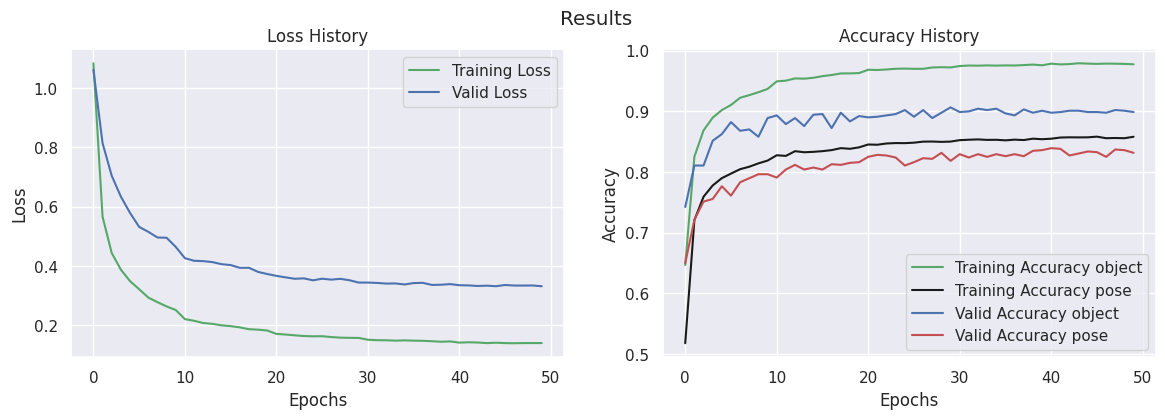

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history6 = trainer6.getHistory()
trainer6.showResults()

best model was trained at epoch: 30
with a validation loss of: 0.3437087 and a validation accuracy of: 90.63876867294312


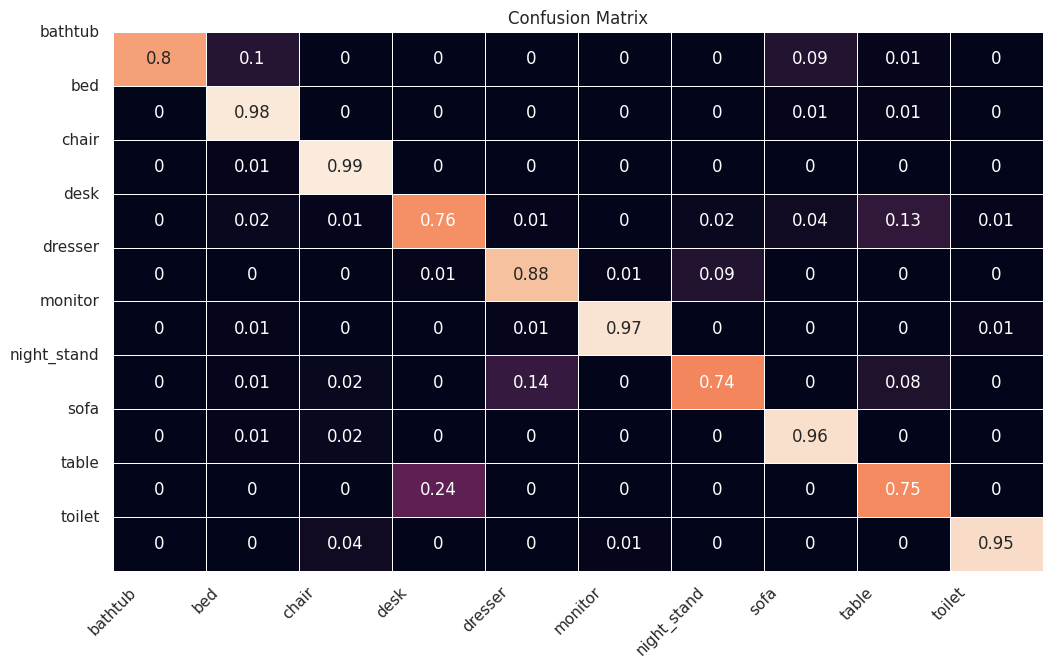

In [ ]:
trainer6.generateConfusionMatrix()

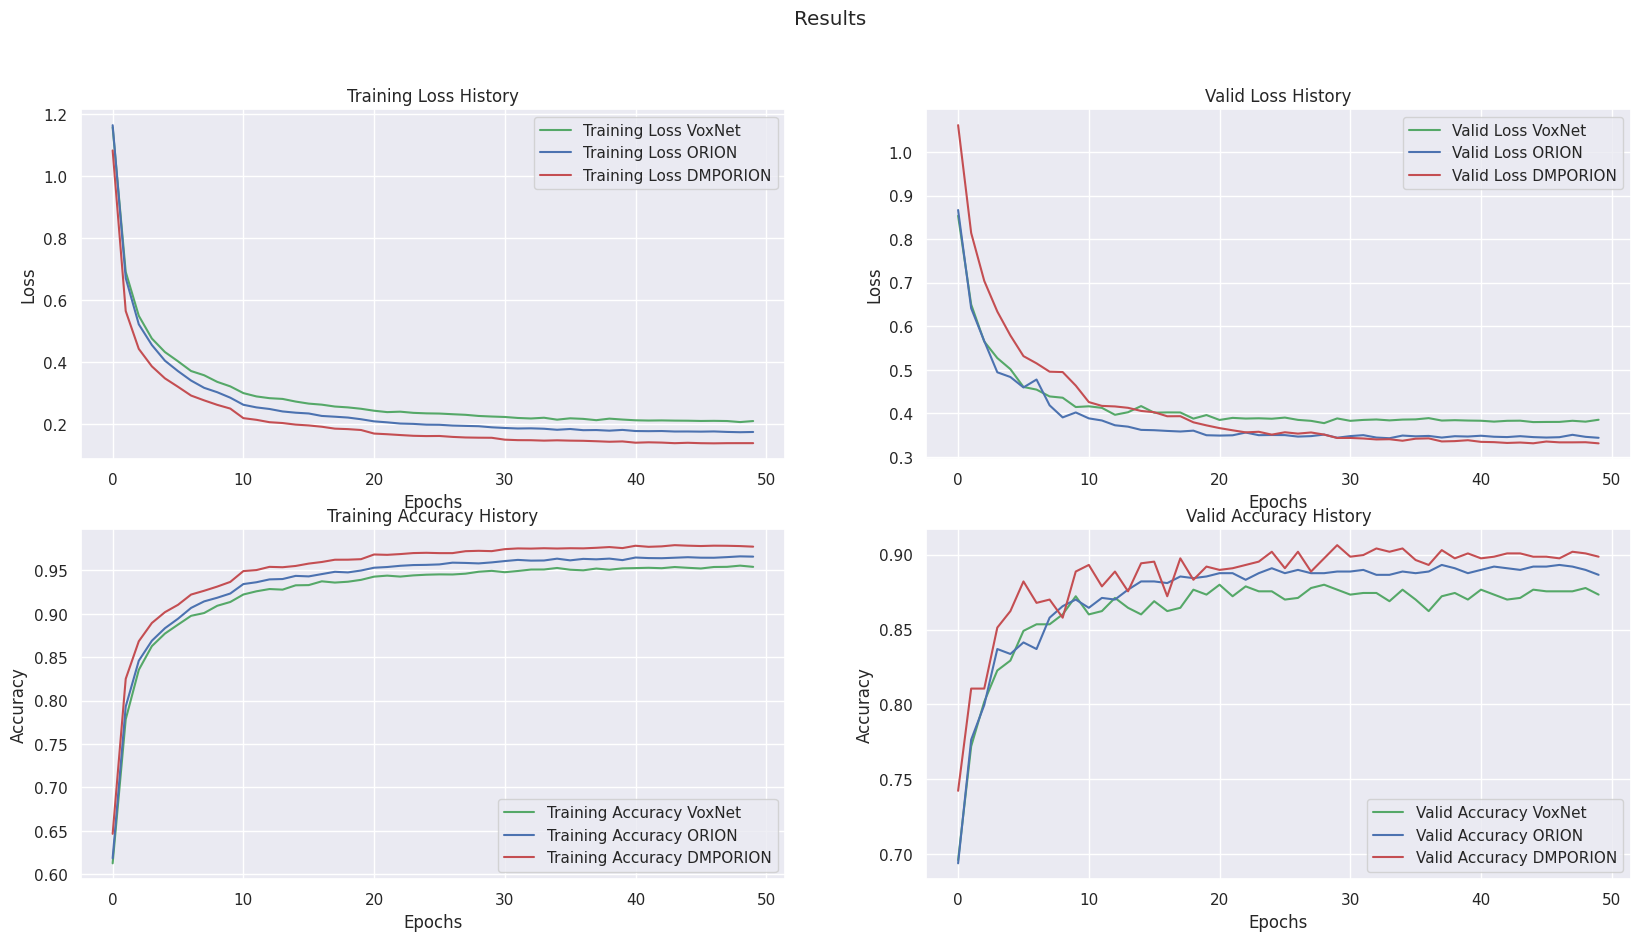

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

eps = range(0, len(history4["train_loss"].cpu()))

sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')

ax[0,0].plot(eps, smooth(history4["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history5["train_loss"].cpu()), 'b', label='Training Loss ORION')
ax[0,0].plot(eps, smooth(history6["train_loss"].cpu()), 'r', label='Training Loss DMPORION')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()

ax[0,1].plot(eps, smooth(history4["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history5["valid_loss"].cpu()), 'b', label='Valid Loss ORION')
ax[0,1].plot(eps, smooth(history6["valid_loss"].cpu()), 'r', label='Valid Loss DMPORION')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history4["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history5["train_acc1"].cpu()), 'b', label='Training Accuracy ORION')
ax[1,0].plot(eps, smooth(history6["train_acc1"].cpu()), 'r', label='Training Accuracy DMPORION')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history4["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history5["valid_acc1"].cpu()), 'b', label='Valid Accuracy ORION')
ax[1,1].plot(eps, smooth(history6["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPORION')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

best model was trained at epoch: 21
with a validation loss of: 0.3850588 and a validation accuracy of: 87.99559473991394
best model was trained at epoch: 38
with a validation loss of: 0.34468406 and a validation accuracy of: 89.31717872619629
best model was trained at epoch: 30
with a validation loss of: 0.3437087 and a validation accuracy of: 90.63876867294312


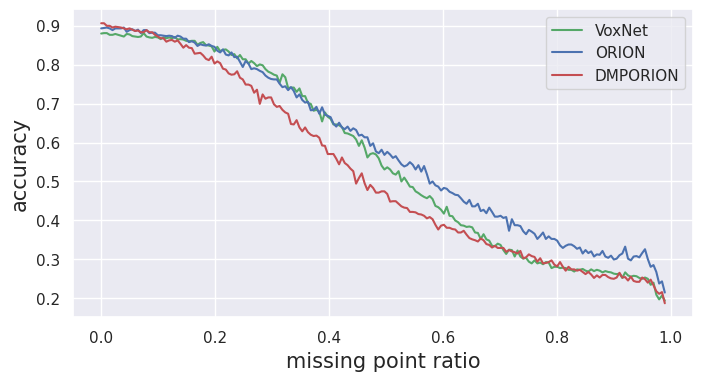

In [ ]:
eps4, acc4 = trainer4.missing_data_test()
eps5, acc5 = trainer5.missing_data_test()
eps6, acc6 = trainer6.missing_data_test()

sns.set_theme()
plt.figure(figsize=(8, 4))
line1 = plt.plot(eps4, smooth(acc4), 'g', label='VoxNet')
line2 = plt.plot(eps5, smooth(acc5), 'b', label='ORION')
line3 = plt.plot(eps6, smooth(acc6), 'r', label='DMPORION')

plt.xlabel("missing point ratio", size=15)
plt.ylabel("accuracy", size=15)
plt.legend()
plt.show()

# PointNet

In [ ]:
import os
import random
import math

!pip install path.py;
from path import Path

path = Path("ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))


    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]]))

        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))

        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]], verts[sampled_faces[i][1]], verts[sampled_faces[i][2]]))

        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])

        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))

        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
class PointNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.best_acc = 0

      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.initModel(hyperparameters)

  def initDataset(self):
      self.train_ds = PointCloudData(path, transform=train_transforms)
      self.test_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      self.model = PointNet()
      os.mkdir('/content/PointNet/')
      print("model PointNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def train(self):
      self.pred_conf, self.y_conf = [], []
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training loss
          train_loss = []
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data['pointcloud'].to(self.device).float(), data['category'].to(self.device)

              self.opt.zero_grad()
              outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))
              loss = pointnetloss(outputs, labels, m3x3, m64x64)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(outputs, 1).cpu(), labels.cpu())

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")

          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):
                inputs_test, labels_test = sample['pointcloud'].to(self.device).float(), sample['category'].to(self.device)

                outputs_test, m3x3, m64x64  = self.model(inputs_test.transpose(1,2))
                loss_test = pointnetloss(outputs_test, labels_test, m3x3, m64x64)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(outputs_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = outputs_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(outputs_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

           # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()

          train_accuracy.reset()
          valid_accuracy.reset()

          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)



          elapsed_time_epoch = time.time() - t

          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")

          ##save best model
          if total_valid_accuracy.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1],
                          'accuracy': total_valid_accuracy},
	                        '/content/PointNet'+'/best_model.pth')


          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history),
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}

  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)

  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))

      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')

      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()

      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)

          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0

          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())

      return test_accuracy.compute()

  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)


      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.0001,
    "data_size": 32,
    "epochs": 25,
    "train_batch_size": 32,
    "valid_batch_size": 64,
}

trainer7 = PointNet_Trainer(training_hyperparameters)
trainer7.train()

model PointNet was chosen
124.71875


Train loss: 0.8631842732429504: : 124it [20:02,  9.70s/it]
15it [03:44, 14.99s/it]


epoch:  1 / 25
time: 1427.10 seconds
train-loss: 1.49, train-acc-object: 51.66%
valid-loss: 1.23, valid-acc-object: 60.35%


Train loss: 0.591437041759491: : 124it [20:09,  9.76s/it]
15it [03:41, 14.78s/it]


epoch:  2 / 25
time: 1431.33 seconds
train-loss: 0.86, train-acc-object: 73.39%
valid-loss: 0.92, valid-acc-object: 72.80%


Train loss: 0.8015580773353577: : 124it [19:50,  9.60s/it]
15it [03:45, 15.05s/it]


epoch:  3 / 25
time: 1416.38 seconds
train-loss: 0.71, train-acc-object: 78.25%
valid-loss: 0.94, valid-acc-object: 63.99%


Train loss: 0.705773115158081: : 124it [20:01,  9.69s/it]
15it [03:45, 15.06s/it]


epoch:  4 / 25
time: 1427.15 seconds
train-loss: 0.62, train-acc-object: 80.80%
valid-loss: 0.86, valid-acc-object: 68.83%


Train loss: 0.6751517057418823: : 124it [19:55,  9.64s/it]
15it [03:44, 14.94s/it]


epoch:  5 / 25
time: 1419.23 seconds
train-loss: 0.51, train-acc-object: 84.12%
valid-loss: 0.71, valid-acc-object: 73.46%


Train loss: 0.603213369846344: : 124it [20:02,  9.70s/it]
15it [03:42, 14.85s/it]


epoch:  6 / 25
time: 1425.64 seconds
train-loss: 0.48, train-acc-object: 84.43%
valid-loss: 0.67, valid-acc-object: 76.54%


Train loss: 0.7722180485725403: : 124it [20:04,  9.71s/it]
15it [03:48, 15.22s/it]


epoch:  7 / 25
time: 1432.63 seconds
train-loss: 0.44, train-acc-object: 86.47%
valid-loss: 0.49, valid-acc-object: 83.92%


Train loss: 0.3020842671394348: : 124it [20:03,  9.70s/it]
15it [03:44, 14.96s/it]


epoch:  8 / 25
time: 1427.77 seconds
train-loss: 0.40, train-acc-object: 87.53%
valid-loss: 0.45, valid-acc-object: 85.90%


Train loss: 0.35341423749923706: : 124it [19:56,  9.65s/it]
15it [03:47, 15.19s/it]


epoch:  9 / 25
time: 1424.25 seconds
train-loss: 0.37, train-acc-object: 88.43%
valid-loss: 0.67, valid-acc-object: 78.08%


Train loss: 0.25213950872421265: : 124it [20:14,  9.79s/it]
15it [03:49, 15.32s/it]


epoch: 10 / 25
time: 1443.80 seconds
train-loss: 0.36, train-acc-object: 88.89%
valid-loss: 0.50, valid-acc-object: 82.27%


Train loss: 0.20233207941055298: : 124it [20:15,  9.80s/it]
15it [03:48, 15.21s/it]


epoch: 11 / 25
time: 1443.57 seconds
train-loss: 0.36, train-acc-object: 88.48%
valid-loss: 0.45, valid-acc-object: 85.13%


Train loss: 0.2511006295681: : 124it [20:09,  9.76s/it]
15it [03:45, 15.05s/it]


epoch: 12 / 25
time: 1435.51 seconds
train-loss: 0.35, train-acc-object: 89.11%
valid-loss: 0.45, valid-acc-object: 84.47%


Train loss: 0.3471516966819763: : 124it [20:32,  9.94s/it]
15it [03:51, 15.45s/it]


epoch: 13 / 25
time: 1463.88 seconds
train-loss: 0.32, train-acc-object: 89.87%
valid-loss: 0.49, valid-acc-object: 82.60%


Train loss: 0.3079020082950592: : 124it [20:15,  9.80s/it]
15it [03:47, 15.18s/it]


epoch: 14 / 25
time: 1442.74 seconds
train-loss: 0.31, train-acc-object: 90.22%
valid-loss: 0.41, valid-acc-object: 86.23%


Train loss: 0.19103120267391205: : 124it [20:01,  9.69s/it]
15it [03:45, 15.05s/it]


epoch: 15 / 25
time: 1427.01 seconds
train-loss: 0.28, train-acc-object: 90.73%
valid-loss: 0.42, valid-acc-object: 85.24%


Train loss: 0.22110579907894135: : 124it [20:12,  9.78s/it]
15it [03:42, 14.82s/it]


epoch: 16 / 25
time: 1434.70 seconds
train-loss: 0.28, train-acc-object: 90.42%
valid-loss: 0.40, valid-acc-object: 85.90%


Train loss: 0.319767564535141: : 124it [19:51,  9.61s/it]
15it [03:44, 14.94s/it]


epoch: 17 / 25
time: 1415.54 seconds
train-loss: 0.27, train-acc-object: 91.51%
valid-loss: 0.46, valid-acc-object: 83.37%


Train loss: 0.2038693130016327: : 124it [20:01,  9.69s/it]
15it [03:43, 14.87s/it]


epoch: 18 / 25
time: 1424.59 seconds
train-loss: 0.27, train-acc-object: 91.26%
valid-loss: 0.48, valid-acc-object: 84.14%


Train loss: 0.2556142508983612: : 124it [19:52,  9.62s/it]
15it [03:42, 14.84s/it]


epoch: 19 / 25
time: 1415.44 seconds
train-loss: 0.26, train-acc-object: 91.81%
valid-loss: 0.45, valid-acc-object: 85.02%


Train loss: 0.4537767469882965: : 124it [19:45,  9.56s/it]
15it [03:43, 14.88s/it]


epoch: 20 / 25
time: 1409.03 seconds
train-loss: 0.25, train-acc-object: 91.83%
valid-loss: 0.44, valid-acc-object: 83.81%


Train loss: 0.22171805799007416: : 124it [19:48,  9.58s/it]
15it [03:42, 14.86s/it]


epoch: 21 / 25
time: 1411.41 seconds
train-loss: 0.25, train-acc-object: 91.91%
valid-loss: 0.37, valid-acc-object: 87.44%


Train loss: 0.17414472997188568: : 124it [20:04,  9.71s/it]
15it [03:45, 15.02s/it]


epoch: 22 / 25
time: 1429.39 seconds
train-loss: 0.24, train-acc-object: 91.91%
valid-loss: 0.35, valid-acc-object: 88.22%


Train loss: 0.33905884623527527: : 124it [19:44,  9.55s/it]
15it [03:40, 14.70s/it]


epoch: 23 / 25
time: 1404.79 seconds
train-loss: 0.23, train-acc-object: 92.06%
valid-loss: 0.38, valid-acc-object: 86.56%


Train loss: 0.33186376094818115: : 124it [20:10,  9.76s/it]
15it [04:33, 18.25s/it]


epoch: 24 / 25
time: 1483.95 seconds
train-loss: 0.23, train-acc-object: 91.78%
valid-loss: 0.38, valid-acc-object: 87.44%


Train loss: 0.4842529594898224: : 124it [19:39,  9.51s/it]
15it [04:00, 16.04s/it]

epoch: 25 / 25
time: 1420.03 seconds
train-loss: 0.23, train-acc-object: 92.14%
valid-loss: 0.39, valid-acc-object: 87.22%


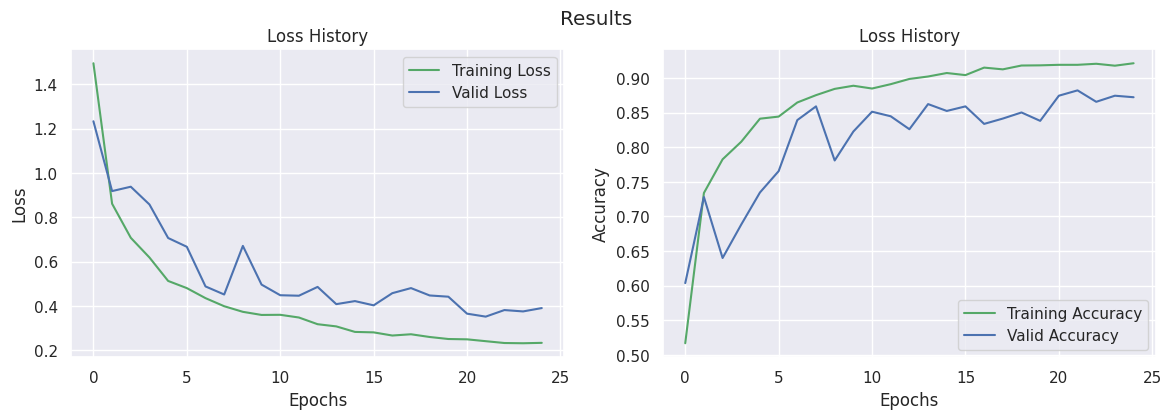

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history7 = trainer7.getHistory()

trainer7.showResults()

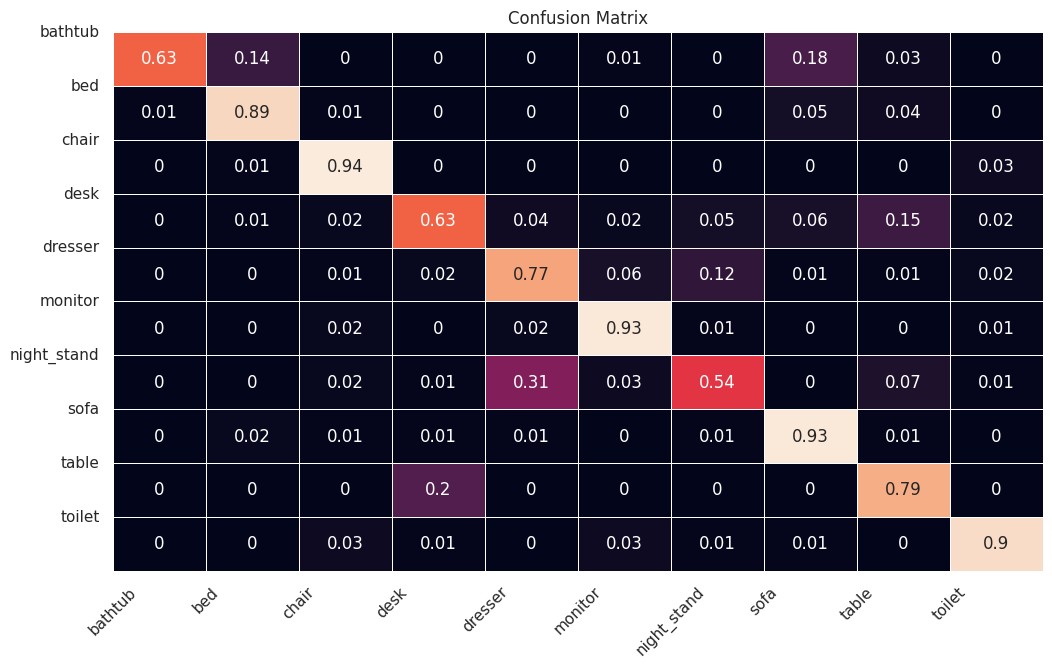

In [ ]:
trainer7.generateConfusionMatrix()

# Download and unzip the dataset ModelNet40



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/ModelNet40.zip";

In [ ]:
!wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2023-05-19 08:16:39--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2023-05-19 08:16:40--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  56.9MB/s    in 53s     

2023-05-19 08:17:32 (37.0 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [ ]:
!unzip -q ModelNet40.zip;

unzip:  cannot find or open ModelNet40.zip, ModelNet40.zip.zip or ModelNet40.zip.ZIP.


In [ ]:
ROOT = '/content/ModelNet40/'
CLASSES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
           'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
           'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
           'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          rot = random.choice(ROTATIONS)
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if rot == '0':
              mesh = mesh
              rotat = 0
            elif rot == '45':
              mesh.rotate(r45)
              rotat = 1
            elif rot == '90':
              mesh.rotate(r90)
              rotat = 2
            elif rot == '135':
              mesh.rotate(r135)
              rotat = 3
            elif rot == '180':
              mesh.rotate(r180)
              rotat = 4
            elif rot == '225':
              mesh.rotate(r225)
              rotat = 5
            elif rot == '270':
              mesh.rotate(r270)
              rotat = 6
            else:
              mesh.rotate(r315)
              rotat = 7
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)


  4%|▍         | 20/515 [00:00<00:14, 33.22it/s]<ipython-input-5-c756dd08d0a1>:54: RuntimeWarning: divide by zero encountered in double_scalars
  mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
  6%|▌         | 31/515 [00:00<00:09, 53.75it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18524 23092 0' not supported.


 26%|██▌       | 132/515 [00:03<00:08, 44.77it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1806 1388 0' not supported.


 39%|███▉      | 200/515 [00:06<00:08, 37.34it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4780 6240 0' not supported.
[Open3D WARNING] Read OFF failed: header keyword 'OFF1479 1440 0' not supported.


 96%|█████████▌| 493/515 [00:17<00:00, 28.01it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF3161 2820 0' not supported.


 19%|█▊        | 165/889 [00:08<00:19, 36.98it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4890 7376 0' not supported.


 40%|███▉      | 352/889 [00:14<00:11, 45.67it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF2938 4636 0' not supported.


 70%|███████   | 624/889 [00:26<00:10, 25.30it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18515 26870 0' not supported.


 80%|████████  | 713/889 [00:28<00:04, 42.35it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF6586 5534 0' not supported.


 78%|███████▊  | 67/86 [00:01<00:00, 61.40it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1' not supported.


100%|██████████| 20/20 [00:00<00:00, 30.25it/s]


# Dataset setup and Trainer fo ModelNet40


In [ ]:
class Network_Dataset40(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']


    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):

        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
class Network_Trainer40():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3

      #Dataset
      self.initDataset()
      self.class_names = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
                          'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
                          'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
                          'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()

  def initDataset(self):
      self.train_ds = Network_Dataset40(train=True)
      self.test_ds = Network_Dataset40(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet40":
          self.model = VoxNet40()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet40 was chosen")
      elif self.name_model == "ORION40":
          self.model = ORION40()
          os.mkdir('/content/'+str(self.name_model))
          print("model ORION40 was chosen")
      else:
        self.model = DMPORION40()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPORION40 was choosen')

      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)

      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.CrossEntropyLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training and validation loss
          train_loss = []
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu())
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu())

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")

          self.lr_scheduler.step()

          #test phase
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []
            pred_test2 = []
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()

                pred_test1, pred_test2 = self.model(inputs_test)
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu())

                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)


          #total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()

          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)


          elapsed_time_epoch = time.time() - t

          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, valid-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          #save best model
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1],
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')


          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2),
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}

  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))

      #compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=self.num_classes, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (20,14))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)

  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))

      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')

      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()

      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]

      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()

  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=40)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']

      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)

          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0

          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())

      return test_accuracy.compute()

  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)

      return eps, acc

#VoxNet with Modelnet40

In [ ]:
class VoxNet40(nn.Module):
    def __init__(self):
        super(VoxNet40, self).__init__()
        n_classes = 40
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))

        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 40,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet40'
}

trainer8 = Network_Trainer40(training_hyperparameters)
trainer8.train()

model VoxNet40 was chosen
143.75


Train loss: 2.639472484588623: : 143it [00:29,  4.86it/s]
77it [00:05, 14.01it/s]


epoch:  1 / 50
time: 34.92 seconds
train-loss: 2.82, train-acc-object: 18.28%, train-acc-pose: 16.40%
valid-loss: 2.52, valid-acc-object: 23.06%, valid-acc-pose: 23.71%



Train loss: 2.257296085357666: : 143it [00:21,  6.72it/s]
77it [00:06, 12.27it/s]


epoch:  2 / 50
time: 27.57 seconds
train-loss: 2.35, train-acc-object: 32.11%, train-acc-pose: 24.40%
valid-loss: 2.18, valid-acc-object: 34.79%, valid-acc-pose: 27.81%



Train loss: 1.8736480474472046: : 143it [00:21,  6.71it/s]
77it [00:06, 12.64it/s]


epoch:  3 / 50
time: 27.43 seconds
train-loss: 2.07, train-acc-object: 40.23%, train-acc-pose: 28.65%
valid-loss: 1.96, valid-acc-object: 42.14%, valid-acc-pose: 30.25%



Train loss: 1.9431395530700684: : 143it [00:21,  6.59it/s]
77it [00:05, 15.29it/s]


epoch:  4 / 50
time: 26.76 seconds
train-loss: 1.89, train-acc-object: 46.06%, train-acc-pose: 32.16%
valid-loss: 1.79, valid-acc-object: 49.29%, valid-acc-pose: 31.10%



Train loss: 1.7733302116394043: : 143it [00:22,  6.31it/s]
77it [00:04, 17.04it/s]


epoch:  5 / 50
time: 27.21 seconds
train-loss: 1.76, train-acc-object: 49.81%, train-acc-pose: 33.82%
valid-loss: 1.67, valid-acc-object: 52.42%, valid-acc-pose: 33.17%



Train loss: 1.632988452911377: : 143it [00:23,  6.09it/s]
77it [00:04, 16.68it/s]


epoch:  6 / 50
time: 28.12 seconds
train-loss: 1.65, train-acc-object: 53.25%, train-acc-pose: 35.66%
valid-loss: 1.56, valid-acc-object: 55.95%, valid-acc-pose: 35.24%



Train loss: 1.7117624282836914: : 143it [00:23,  6.18it/s]
77it [00:04, 16.89it/s]


epoch:  7 / 50
time: 27.72 seconds
train-loss: 1.56, train-acc-object: 56.15%, train-acc-pose: 38.02%
valid-loss: 1.50, valid-acc-object: 59.03%, valid-acc-pose: 36.87%



Train loss: 1.401883602142334: : 143it [00:23,  6.16it/s]
77it [00:04, 16.55it/s]


epoch:  8 / 50
time: 27.88 seconds
train-loss: 1.48, train-acc-object: 58.82%, train-acc-pose: 38.79%
valid-loss: 1.42, valid-acc-object: 61.75%, valid-acc-pose: 37.19%



Train loss: 1.2838778495788574: : 143it [00:22,  6.30it/s]
77it [00:05, 14.38it/s]


epoch:  9 / 50
time: 28.07 seconds
train-loss: 1.42, train-acc-object: 60.92%, train-acc-pose: 41.06%
valid-loss: 1.37, valid-acc-object: 64.60%, valid-acc-pose: 37.31%



Train loss: 1.4652290344238281: : 143it [00:22,  6.50it/s]
77it [00:06, 12.38it/s]


epoch: 10 / 50
time: 28.24 seconds
train-loss: 1.37, train-acc-object: 61.81%, train-acc-pose: 41.15%
valid-loss: 1.33, valid-acc-object: 64.43%, valid-acc-pose: 38.00%



Train loss: 1.4154982566833496: : 143it [00:21,  6.58it/s]
77it [00:06, 11.90it/s]


epoch: 11 / 50
time: 28.23 seconds
train-loss: 1.32, train-acc-object: 64.17%, train-acc-pose: 41.61%
valid-loss: 1.29, valid-acc-object: 67.11%, valid-acc-pose: 39.71%



Train loss: 1.1401736736297607: : 143it [00:21,  6.57it/s]
77it [00:06, 11.85it/s]


epoch: 12 / 50
time: 28.29 seconds
train-loss: 1.27, train-acc-object: 66.12%, train-acc-pose: 42.61%
valid-loss: 1.25, valid-acc-object: 68.78%, valid-acc-pose: 39.63%



Train loss: 1.3024120330810547: : 143it [00:21,  6.57it/s]
77it [00:06, 12.67it/s]


epoch: 13 / 50
time: 27.87 seconds
train-loss: 1.24, train-acc-object: 67.01%, train-acc-pose: 43.48%
valid-loss: 1.22, valid-acc-object: 69.67%, valid-acc-pose: 39.75%



Train loss: 1.2938755750656128: : 143it [00:22,  6.47it/s]
77it [00:05, 14.56it/s]


epoch: 14 / 50
time: 27.40 seconds
train-loss: 1.20, train-acc-object: 67.61%, train-acc-pose: 44.96%
valid-loss: 1.20, valid-acc-object: 69.51%, valid-acc-pose: 41.45%



Train loss: 1.1713306903839111: : 143it [00:22,  6.22it/s]
77it [00:04, 16.42it/s]


epoch: 15 / 50
time: 27.68 seconds
train-loss: 1.18, train-acc-object: 68.75%, train-acc-pose: 44.66%
valid-loss: 1.18, valid-acc-object: 70.32%, valid-acc-pose: 42.10%



Train loss: 1.099199891090393: : 143it [00:23,  6.09it/s]
77it [00:04, 16.34it/s]


epoch: 16 / 50
time: 28.23 seconds
train-loss: 1.16, train-acc-object: 68.85%, train-acc-pose: 45.76%
valid-loss: 1.18, valid-acc-object: 70.56%, valid-acc-pose: 42.51%



Train loss: 0.9790424108505249: : 143it [00:23,  6.09it/s]
77it [00:04, 16.35it/s]


epoch: 17 / 50
time: 28.23 seconds
train-loss: 1.12, train-acc-object: 70.43%, train-acc-pose: 46.90%
valid-loss: 1.15, valid-acc-object: 71.78%, valid-acc-pose: 42.35%



Train loss: 1.1345999240875244: : 143it [00:23,  6.06it/s]
77it [00:04, 16.37it/s]


epoch: 18 / 50
time: 28.32 seconds
train-loss: 1.10, train-acc-object: 71.39%, train-acc-pose: 47.67%
valid-loss: 1.14, valid-acc-object: 71.05%, valid-acc-pose: 43.12%



Train loss: 1.1294445991516113: : 143it [00:23,  6.08it/s]
77it [00:04, 16.35it/s]


epoch: 19 / 50
time: 28.25 seconds
train-loss: 1.07, train-acc-object: 72.22%, train-acc-pose: 48.08%
valid-loss: 1.13, valid-acc-object: 71.99%, valid-acc-pose: 43.48%



Train loss: 0.9581899046897888: : 143it [00:23,  6.10it/s]
77it [00:04, 16.28it/s]


epoch: 20 / 50
time: 28.20 seconds
train-loss: 1.06, train-acc-object: 72.32%, train-acc-pose: 47.71%
valid-loss: 1.13, valid-acc-object: 71.70%, valid-acc-pose: 43.40%



Train loss: 1.129744052886963: : 143it [00:23,  6.08it/s]
77it [00:05, 15.17it/s]


epoch: 21 / 50
time: 28.60 seconds
train-loss: 1.04, train-acc-object: 72.97%, train-acc-pose: 48.42%
valid-loss: 1.09, valid-acc-object: 73.37%, valid-acc-pose: 43.89%



Train loss: 0.7893730401992798: : 143it [00:22,  6.29it/s]
77it [00:05, 13.65it/s]


epoch: 22 / 50
time: 28.39 seconds
train-loss: 1.01, train-acc-object: 73.81%, train-acc-pose: 49.75%
valid-loss: 1.09, valid-acc-object: 73.28%, valid-acc-pose: 43.48%



Train loss: 1.2298780679702759: : 143it [00:22,  6.38it/s]
77it [00:06, 12.40it/s]


epoch: 23 / 50
time: 28.63 seconds
train-loss: 1.00, train-acc-object: 74.26%, train-acc-pose: 49.51%
valid-loss: 1.08, valid-acc-object: 73.16%, valid-acc-pose: 44.99%



Train loss: 1.062112808227539: : 143it [00:22,  6.45it/s]
77it [00:06, 11.92it/s]


epoch: 24 / 50
time: 28.64 seconds
train-loss: 0.99, train-acc-object: 74.51%, train-acc-pose: 49.92%
valid-loss: 1.08, valid-acc-object: 72.47%, valid-acc-pose: 45.55%



Train loss: 0.8417425155639648: : 143it [00:22,  6.45it/s]
77it [00:06, 11.77it/s]


epoch: 25 / 50
time: 28.71 seconds
train-loss: 0.97, train-acc-object: 75.23%, train-acc-pose: 50.09%
valid-loss: 1.08, valid-acc-object: 72.72%, valid-acc-pose: 44.58%



Train loss: 1.2433346509933472: : 143it [00:22,  6.45it/s]
77it [00:06, 11.71it/s]


epoch: 26 / 50
time: 28.76 seconds
train-loss: 0.95, train-acc-object: 75.90%, train-acc-pose: 50.97%
valid-loss: 1.06, valid-acc-object: 73.69%, valid-acc-pose: 45.84%



Train loss: 0.9509657025337219: : 143it [00:22,  6.44it/s]
77it [00:06, 11.67it/s]


epoch: 27 / 50
time: 28.81 seconds
train-loss: 0.94, train-acc-object: 76.39%, train-acc-pose: 51.25%
valid-loss: 1.07, valid-acc-object: 72.72%, valid-acc-pose: 45.72%



Train loss: 0.9614501595497131: : 143it [00:22,  6.41it/s]
77it [00:06, 11.71it/s]


epoch: 28 / 50
time: 28.89 seconds
train-loss: 0.92, train-acc-object: 76.82%, train-acc-pose: 51.29%
valid-loss: 1.06, valid-acc-object: 73.08%, valid-acc-pose: 46.04%



Train loss: 0.7731162309646606: : 143it [00:22,  6.41it/s]
77it [00:06, 11.69it/s]


epoch: 29 / 50
time: 28.93 seconds
train-loss: 0.91, train-acc-object: 77.27%, train-acc-pose: 51.78%
valid-loss: 1.05, valid-acc-object: 74.02%, valid-acc-pose: 46.24%



Train loss: 0.9004551768302917: : 143it [00:22,  6.44it/s]
77it [00:06, 11.66it/s]


epoch: 30 / 50
time: 28.83 seconds
train-loss: 0.90, train-acc-object: 77.05%, train-acc-pose: 51.62%
valid-loss: 1.04, valid-acc-object: 73.33%, valid-acc-pose: 46.77%



Train loss: 0.7379947900772095: : 143it [00:22,  6.40it/s]
77it [00:06, 11.91it/s]


epoch: 31 / 50
time: 28.84 seconds
train-loss: 0.87, train-acc-object: 77.96%, train-acc-pose: 53.33%
valid-loss: 1.03, valid-acc-object: 74.75%, valid-acc-pose: 45.80%



Train loss: 0.9539988040924072: : 143it [00:22,  6.34it/s]
77it [00:06, 11.89it/s]


epoch: 32 / 50
time: 29.06 seconds
train-loss: 0.87, train-acc-object: 78.80%, train-acc-pose: 52.71%
valid-loss: 1.03, valid-acc-object: 74.50%, valid-acc-pose: 46.24%



Train loss: 0.8481316566467285: : 143it [00:22,  6.31it/s]
77it [00:06, 11.93it/s]


epoch: 33 / 50
time: 29.12 seconds
train-loss: 0.85, train-acc-object: 79.06%, train-acc-pose: 54.03%
valid-loss: 1.02, valid-acc-object: 75.36%, valid-acc-pose: 46.65%



Train loss: 0.8843883275985718: : 143it [00:22,  6.33it/s]
77it [00:06, 12.16it/s]


epoch: 34 / 50
time: 28.94 seconds
train-loss: 0.85, train-acc-object: 78.62%, train-acc-pose: 54.56%
valid-loss: 1.02, valid-acc-object: 75.07%, valid-acc-pose: 46.93%



Train loss: 0.7967802286148071: : 143it [00:22,  6.32it/s]
77it [00:06, 12.34it/s]


epoch: 35 / 50
time: 28.89 seconds
train-loss: 0.83, train-acc-object: 79.74%, train-acc-pose: 54.53%
valid-loss: 1.02, valid-acc-object: 75.07%, valid-acc-pose: 46.24%



Train loss: 0.707796037197113: : 143it [00:22,  6.27it/s]
77it [00:06, 12.39it/s]


epoch: 36 / 50
time: 29.06 seconds
train-loss: 0.82, train-acc-object: 79.90%, train-acc-pose: 54.72%
valid-loss: 1.01, valid-acc-object: 75.27%, valid-acc-pose: 47.18%



Train loss: 0.9481551647186279: : 143it [00:23,  6.22it/s]
77it [00:06, 12.32it/s]


epoch: 37 / 50
time: 29.28 seconds
train-loss: 0.81, train-acc-object: 80.36%, train-acc-pose: 55.05%
valid-loss: 1.02, valid-acc-object: 74.71%, valid-acc-pose: 46.65%



Train loss: 0.6814683675765991: : 143it [00:22,  6.24it/s]
77it [00:06, 12.41it/s]


epoch: 38 / 50
time: 29.13 seconds
train-loss: 0.80, train-acc-object: 80.03%, train-acc-pose: 55.07%
valid-loss: 1.01, valid-acc-object: 75.31%, valid-acc-pose: 46.98%



Train loss: 0.7876948714256287: : 143it [00:22,  6.24it/s]
77it [00:06, 12.61it/s]


epoch: 39 / 50
time: 29.06 seconds
train-loss: 0.78, train-acc-object: 80.77%, train-acc-pose: 55.31%
valid-loss: 1.01, valid-acc-object: 75.31%, valid-acc-pose: 47.38%



Train loss: 0.6681662797927856: : 143it [00:23,  6.18it/s]
77it [00:06, 12.52it/s]


epoch: 40 / 50
time: 29.33 seconds
train-loss: 0.78, train-acc-object: 80.82%, train-acc-pose: 56.18%
valid-loss: 1.02, valid-acc-object: 74.71%, valid-acc-pose: 47.02%



Train loss: 0.7090268135070801: : 143it [00:23,  6.00it/s]
77it [00:07, 10.70it/s]


epoch: 41 / 50
time: 31.07 seconds
train-loss: 0.74, train-acc-object: 82.38%, train-acc-pose: 56.84%
valid-loss: 1.00, valid-acc-object: 76.00%, valid-acc-pose: 47.26%



Train loss: 0.8721405267715454: : 143it [00:24,  5.92it/s]
77it [00:07, 10.52it/s]


epoch: 42 / 50
time: 31.50 seconds
train-loss: 0.73, train-acc-object: 82.57%, train-acc-pose: 56.96%
valid-loss: 1.00, valid-acc-object: 76.25%, valid-acc-pose: 47.18%



Train loss: 0.7965844869613647: : 143it [00:23,  6.08it/s]
77it [00:06, 11.69it/s]


epoch: 43 / 50
time: 30.11 seconds
train-loss: 0.73, train-acc-object: 82.56%, train-acc-pose: 57.57%
valid-loss: 1.01, valid-acc-object: 75.80%, valid-acc-pose: 47.02%



Train loss: 0.6113394498825073: : 143it [00:23,  6.00it/s]
77it [00:06, 12.29it/s]


epoch: 44 / 50
time: 30.10 seconds
train-loss: 0.73, train-acc-object: 82.73%, train-acc-pose: 57.60%
valid-loss: 1.01, valid-acc-object: 75.56%, valid-acc-pose: 46.98%



Train loss: 0.5024989247322083: : 143it [00:23,  5.97it/s]
77it [00:05, 12.94it/s]


epoch: 45 / 50
time: 29.93 seconds
train-loss: 0.71, train-acc-object: 82.86%, train-acc-pose: 58.19%
valid-loss: 1.00, valid-acc-object: 76.37%, valid-acc-pose: 47.02%



Train loss: 0.7166872620582581: : 143it [00:24,  5.89it/s]
77it [00:05, 13.79it/s]


epoch: 46 / 50
time: 29.87 seconds
train-loss: 0.71, train-acc-object: 82.94%, train-acc-pose: 57.90%
valid-loss: 0.99, valid-acc-object: 76.21%, valid-acc-pose: 48.15%



Train loss: 0.6839918494224548: : 143it [00:24,  5.79it/s]
77it [00:05, 14.52it/s]


epoch: 47 / 50
time: 30.03 seconds
train-loss: 0.71, train-acc-object: 83.10%, train-acc-pose: 57.58%
valid-loss: 1.00, valid-acc-object: 75.92%, valid-acc-pose: 47.91%



Train loss: 0.7626978754997253: : 143it [00:24,  5.77it/s]
77it [00:05, 15.08it/s]


epoch: 48 / 50
time: 29.91 seconds
train-loss: 0.70, train-acc-object: 83.92%, train-acc-pose: 58.29%
valid-loss: 1.01, valid-acc-object: 75.68%, valid-acc-pose: 48.07%



Train loss: 0.7069406509399414: : 143it [00:24,  5.75it/s]
77it [00:05, 14.83it/s]


epoch: 49 / 50
time: 30.10 seconds
train-loss: 0.69, train-acc-object: 83.64%, train-acc-pose: 59.06%
valid-loss: 1.00, valid-acc-object: 75.92%, valid-acc-pose: 47.71%



Train loss: 0.7098019123077393: : 143it [00:25,  5.71it/s]
77it [00:05, 15.02it/s]

epoch: 50 / 50
time: 30.21 seconds
train-loss: 0.70, train-acc-object: 83.82%, train-acc-pose: 58.53%
valid-loss: 1.00, valid-acc-object: 76.25%, valid-acc-pose: 47.75%



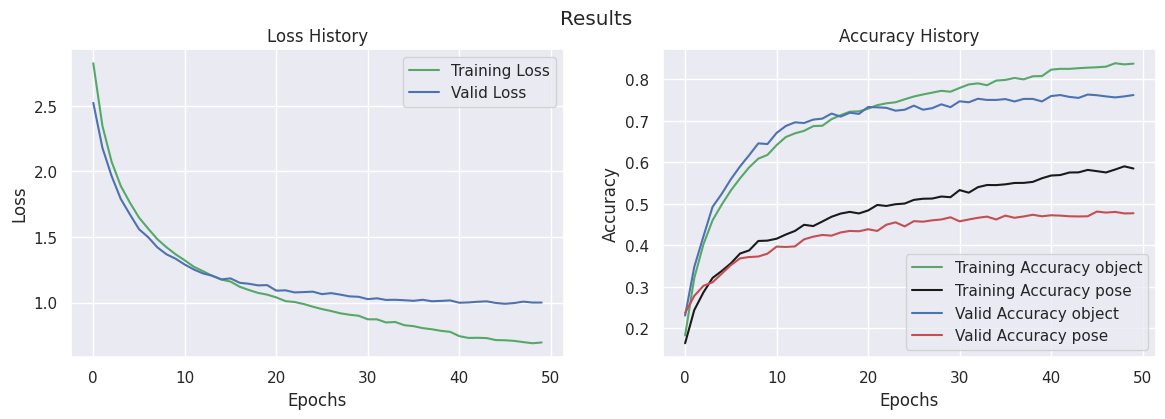

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history8 = trainer8.getHistory()
trainer8.showResults()

best model was trained at epoch: 45
with a validation loss of: 0.99709827 and a validation accuracy of: 76.37028098106384


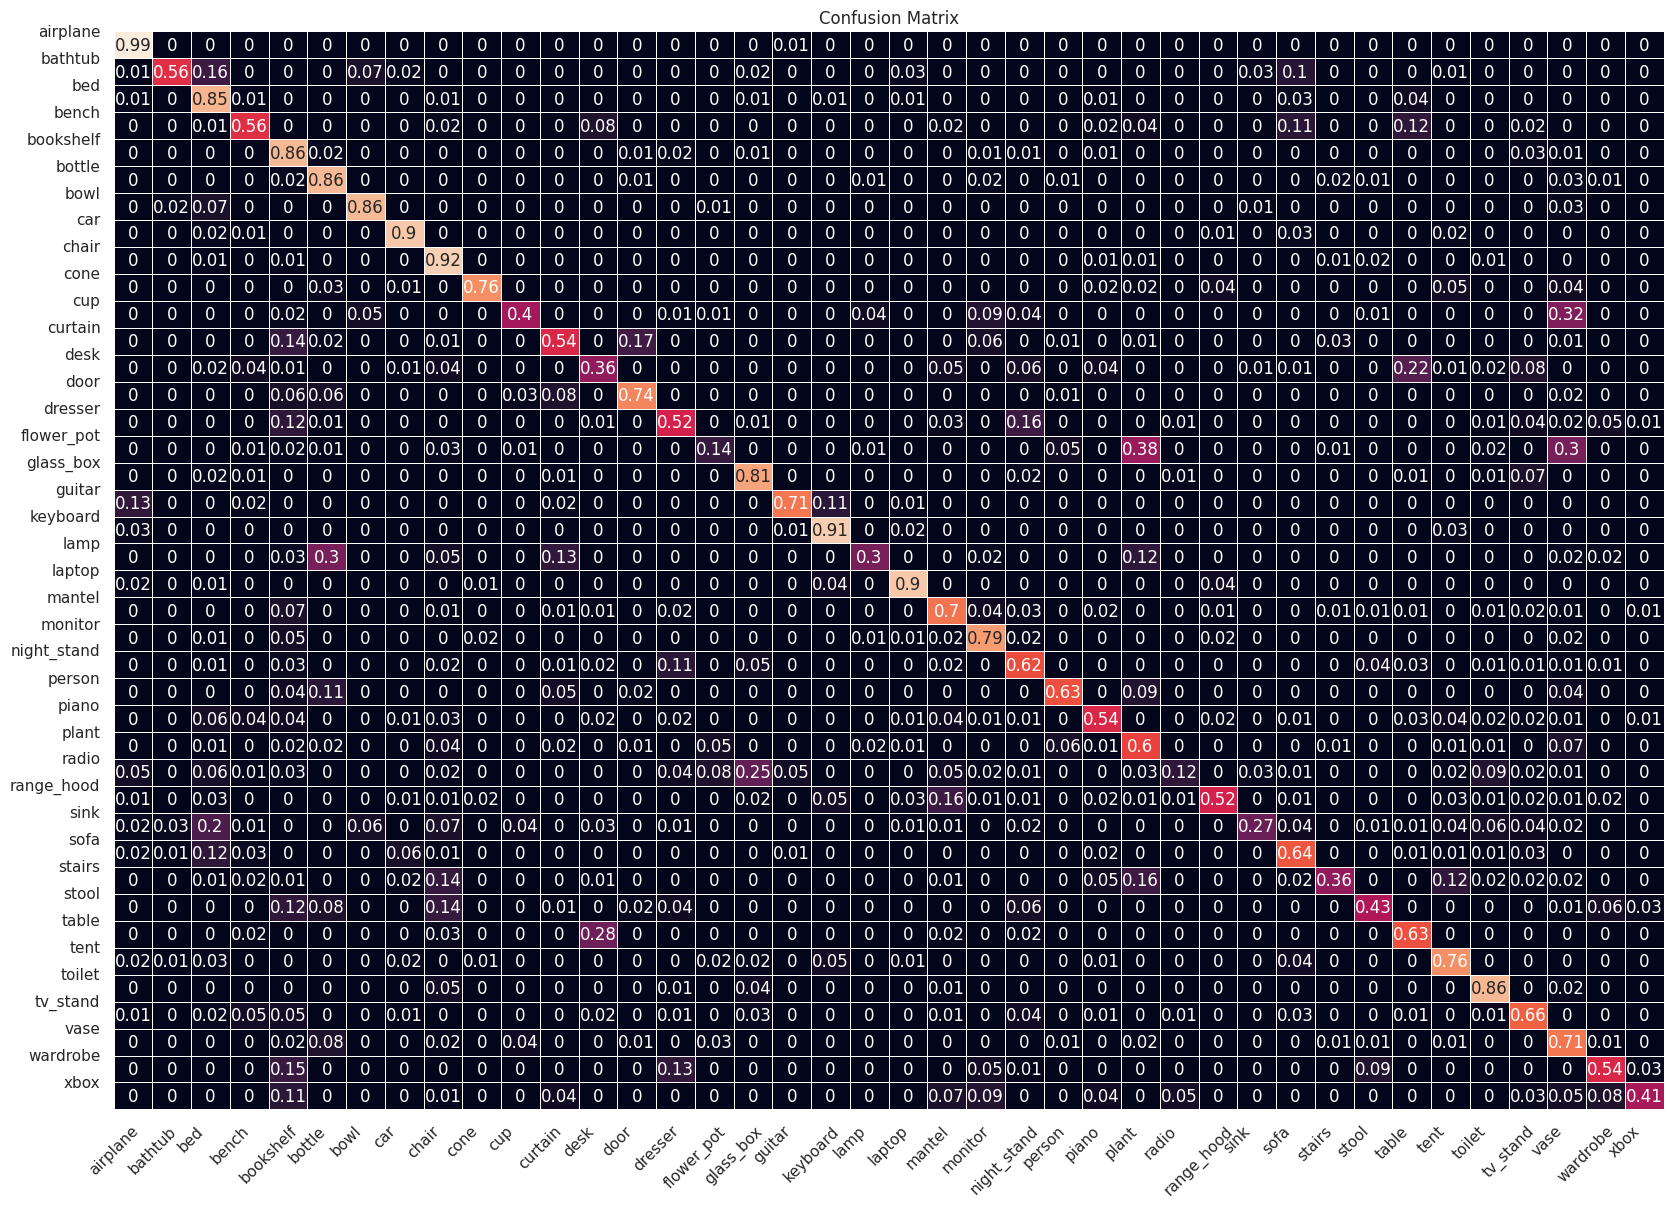

In [ ]:
trainer8.generateConfusionMatrix()

In [ ]:
class ORION40(nn.Module):
    def __init__(self):
        super(ORION40, self).__init__()
        n_classes = 40
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop4', torch.nn.Dropout(p=0.3))
        ]))

        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 40,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'ORION40'
}

trainer9 = Network_Trainer40(training_hyperparameters)
trainer9.train()

model ORION40 was chosen
143.75


Train loss: 2.5794363021850586: : 143it [00:37,  3.83it/s]
77it [00:07, 10.25it/s]


epoch:  1 / 50
time: 44.89 seconds
train-loss: 2.84, train-acc-object: 15.57%, train-acc-pose: 16.24%
valid-loss: 2.70, valid-acc-object: 18.76%, valid-acc-pose: 22.90%



Train loss: 2.483591079711914: : 143it [00:38,  3.74it/s]
77it [00:07,  9.91it/s]


epoch:  2 / 50
time: 46.01 seconds
train-loss: 2.47, train-acc-object: 27.50%, train-acc-pose: 23.39%
valid-loss: 2.44, valid-acc-object: 27.08%, valid-acc-pose: 27.53%



Train loss: 2.1894521713256836: : 143it [00:38,  3.70it/s]
77it [00:07, 10.53it/s]


epoch:  3 / 50
time: 45.97 seconds
train-loss: 2.26, train-acc-object: 32.60%, train-acc-pose: 27.27%
valid-loss: 2.21, valid-acc-object: 32.68%, valid-acc-pose: 28.34%



Train loss: 2.0091347694396973: : 143it [00:39,  3.58it/s]
77it [00:06, 12.75it/s]


epoch:  4 / 50
time: 46.05 seconds
train-loss: 2.08, train-acc-object: 38.58%, train-acc-pose: 30.21%
valid-loss: 2.04, valid-acc-object: 39.14%, valid-acc-pose: 30.17%



Train loss: 1.79715096950531: : 143it [00:40,  3.54it/s]
77it [00:06, 11.90it/s]


epoch:  5 / 50
time: 46.87 seconds
train-loss: 1.94, train-acc-object: 43.45%, train-acc-pose: 32.29%
valid-loss: 1.87, valid-acc-object: 45.15%, valid-acc-pose: 31.75%



Train loss: 1.7144657373428345: : 143it [00:39,  3.58it/s]
77it [00:06, 12.34it/s]


epoch:  6 / 50
time: 46.20 seconds
train-loss: 1.81, train-acc-object: 47.85%, train-acc-pose: 34.76%
valid-loss: 1.74, valid-acc-object: 51.40%, valid-acc-pose: 33.33%



Train loss: 1.4998801946640015: : 143it [00:39,  3.62it/s]
77it [00:07, 10.83it/s]


epoch:  7 / 50
time: 46.62 seconds
train-loss: 1.69, train-acc-object: 50.95%, train-acc-pose: 36.28%
valid-loss: 1.62, valid-acc-object: 54.45%, valid-acc-pose: 34.27%



Train loss: 1.6120383739471436: : 143it [00:38,  3.71it/s]
77it [00:07, 10.00it/s]


epoch:  8 / 50
time: 46.25 seconds
train-loss: 1.61, train-acc-object: 54.40%, train-acc-pose: 36.93%
valid-loss: 1.55, valid-acc-object: 58.10%, valid-acc-pose: 35.89%



Train loss: 1.5628457069396973: : 143it [00:38,  3.72it/s]
77it [00:07, 10.08it/s]


epoch:  9 / 50
time: 46.09 seconds
train-loss: 1.51, train-acc-object: 57.51%, train-acc-pose: 39.37%
valid-loss: 1.47, valid-acc-object: 60.70%, valid-acc-pose: 36.66%



Train loss: 1.30607271194458: : 143it [00:38,  3.68it/s]
77it [00:06, 11.86it/s]


epoch: 10 / 50
time: 45.32 seconds
train-loss: 1.45, train-acc-object: 59.66%, train-acc-pose: 40.31%
valid-loss: 1.39, valid-acc-object: 63.30%, valid-acc-pose: 37.19%



Train loss: 1.4224284887313843: : 143it [00:39,  3.65it/s]
77it [00:06, 12.79it/s]


epoch: 11 / 50
time: 45.26 seconds
train-loss: 1.39, train-acc-object: 61.61%, train-acc-pose: 41.42%
valid-loss: 1.34, valid-acc-object: 65.21%, valid-acc-pose: 38.86%



Train loss: 1.2862244844436646: : 143it [00:39,  3.65it/s]
77it [00:05, 13.07it/s]


epoch: 12 / 50
time: 45.12 seconds
train-loss: 1.34, train-acc-object: 63.07%, train-acc-pose: 42.60%
valid-loss: 1.32, valid-acc-object: 65.94%, valid-acc-pose: 38.77%



Train loss: 1.2516107559204102: : 143it [00:39,  3.64it/s]
77it [00:06, 12.59it/s]


epoch: 13 / 50
time: 45.40 seconds
train-loss: 1.29, train-acc-object: 64.77%, train-acc-pose: 42.86%
valid-loss: 1.26, valid-acc-object: 66.99%, valid-acc-pose: 39.55%



Train loss: 1.2657169103622437: : 143it [00:39,  3.63it/s]
77it [00:07, 10.85it/s]


epoch: 14 / 50
time: 46.50 seconds
train-loss: 1.26, train-acc-object: 65.83%, train-acc-pose: 43.90%
valid-loss: 1.23, valid-acc-object: 67.60%, valid-acc-pose: 40.44%



Train loss: 1.1652767658233643: : 143it [00:39,  3.66it/s]
77it [00:08,  9.62it/s]


epoch: 15 / 50
time: 47.08 seconds
train-loss: 1.22, train-acc-object: 66.82%, train-acc-pose: 44.30%
valid-loss: 1.20, valid-acc-object: 69.14%, valid-acc-pose: 41.41%



Train loss: 1.1186866760253906: : 143it [00:39,  3.65it/s]
77it [00:07, 10.29it/s]


epoch: 16 / 50
time: 46.72 seconds
train-loss: 1.19, train-acc-object: 67.69%, train-acc-pose: 44.70%
valid-loss: 1.18, valid-acc-object: 69.96%, valid-acc-pose: 41.33%



Train loss: 0.9310115575790405: : 143it [00:39,  3.60it/s]
77it [00:06, 12.65it/s]


epoch: 17 / 50
time: 45.84 seconds
train-loss: 1.15, train-acc-object: 68.98%, train-acc-pose: 46.02%
valid-loss: 1.17, valid-acc-object: 69.83%, valid-acc-pose: 42.59%



Train loss: 1.129691481590271: : 143it [00:39,  3.61it/s]
77it [00:06, 12.64it/s]


epoch: 18 / 50
time: 45.75 seconds
train-loss: 1.14, train-acc-object: 69.92%, train-acc-pose: 46.63%
valid-loss: 1.15, valid-acc-object: 71.42%, valid-acc-pose: 42.18%



Train loss: 1.1919140815734863: : 143it [00:39,  3.64it/s]
77it [00:06, 12.52it/s]


epoch: 19 / 50
time: 45.50 seconds
train-loss: 1.11, train-acc-object: 71.00%, train-acc-pose: 46.71%
valid-loss: 1.13, valid-acc-object: 71.09%, valid-acc-pose: 43.97%



Train loss: 0.9768967628479004: : 143it [00:39,  3.66it/s]
77it [00:07, 10.76it/s]


epoch: 20 / 50
time: 46.28 seconds
train-loss: 1.08, train-acc-object: 70.86%, train-acc-pose: 47.36%
valid-loss: 1.11, valid-acc-object: 71.78%, valid-acc-pose: 43.52%



Train loss: 0.9956949353218079: : 143it [00:38,  3.71it/s]
77it [00:07,  9.92it/s]


epoch: 21 / 50
time: 46.32 seconds
train-loss: 1.05, train-acc-object: 72.72%, train-acc-pose: 48.45%
valid-loss: 1.12, valid-acc-object: 72.27%, valid-acc-pose: 43.56%



Train loss: 0.9935569167137146: : 143it [00:38,  3.69it/s]
77it [00:07, 10.13it/s]


epoch: 22 / 50
time: 46.33 seconds
train-loss: 1.03, train-acc-object: 73.13%, train-acc-pose: 48.52%
valid-loss: 1.11, valid-acc-object: 71.94%, valid-acc-pose: 42.92%



Train loss: 1.073124885559082: : 143it [00:39,  3.61it/s]
77it [00:06, 12.17it/s]


epoch: 23 / 50
time: 45.94 seconds
train-loss: 1.02, train-acc-object: 73.71%, train-acc-pose: 49.01%
valid-loss: 1.08, valid-acc-object: 72.80%, valid-acc-pose: 44.42%



Train loss: 0.7412338852882385: : 143it [00:41,  3.42it/s]
77it [00:06, 11.84it/s]


epoch: 24 / 50
time: 48.30 seconds
train-loss: 0.99, train-acc-object: 74.05%, train-acc-pose: 50.07%
valid-loss: 1.07, valid-acc-object: 72.68%, valid-acc-pose: 43.77%



Train loss: 1.061398983001709: : 143it [00:40,  3.49it/s]
77it [00:07,  9.70it/s]


epoch: 25 / 50
time: 48.92 seconds
train-loss: 0.97, train-acc-object: 74.89%, train-acc-pose: 49.79%
valid-loss: 1.06, valid-acc-object: 73.73%, valid-acc-pose: 44.50%



Train loss: 0.8665003180503845: : 143it [00:39,  3.62it/s]
77it [00:08,  9.26it/s]


epoch: 26 / 50
time: 47.85 seconds
train-loss: 0.96, train-acc-object: 74.81%, train-acc-pose: 50.30%
valid-loss: 1.06, valid-acc-object: 73.57%, valid-acc-pose: 43.61%



Train loss: 0.926824688911438: : 143it [00:40,  3.49it/s]
77it [00:06, 11.66it/s]


epoch: 27 / 50
time: 47.62 seconds
train-loss: 0.95, train-acc-object: 75.30%, train-acc-pose: 50.19%
valid-loss: 1.06, valid-acc-object: 73.00%, valid-acc-pose: 44.46%



Train loss: 0.812195897102356: : 143it [00:40,  3.50it/s]
77it [00:06, 11.96it/s]


epoch: 28 / 50
time: 47.29 seconds
train-loss: 0.93, train-acc-object: 76.14%, train-acc-pose: 51.11%
valid-loss: 1.03, valid-acc-object: 74.18%, valid-acc-pose: 45.68%



Train loss: 0.9756723046302795: : 143it [00:40,  3.55it/s]
77it [00:08,  9.45it/s]


epoch: 29 / 50
time: 48.42 seconds
train-loss: 0.91, train-acc-object: 77.07%, train-acc-pose: 51.38%
valid-loss: 1.03, valid-acc-object: 74.06%, valid-acc-pose: 45.23%



Train loss: 0.6987547874450684: : 143it [00:39,  3.63it/s]
77it [00:08,  9.58it/s]


epoch: 30 / 50
time: 47.49 seconds
train-loss: 0.89, train-acc-object: 77.05%, train-acc-pose: 51.90%
valid-loss: 1.04, valid-acc-object: 75.36%, valid-acc-pose: 45.47%



Train loss: 0.8503274321556091: : 143it [00:40,  3.53it/s]
77it [00:06, 12.19it/s]


epoch: 31 / 50
time: 46.84 seconds
train-loss: 0.87, train-acc-object: 78.14%, train-acc-pose: 52.51%
valid-loss: 1.01, valid-acc-object: 75.76%, valid-acc-pose: 46.12%



Train loss: 0.8279589414596558: : 143it [00:40,  3.52it/s]
77it [00:06, 11.77it/s]


epoch: 32 / 50
time: 47.19 seconds
train-loss: 0.87, train-acc-object: 77.84%, train-acc-pose: 52.98%
valid-loss: 1.01, valid-acc-object: 75.76%, valid-acc-pose: 45.27%



Train loss: 0.9569345712661743: : 143it [00:40,  3.53it/s]
77it [00:07,  9.66it/s]


epoch: 33 / 50
time: 48.48 seconds
train-loss: 0.85, train-acc-object: 78.99%, train-acc-pose: 53.80%
valid-loss: 1.02, valid-acc-object: 73.85%, valid-acc-pose: 45.55%



Train loss: 1.0684046745300293: : 143it [00:39,  3.62it/s]
77it [00:08,  9.48it/s]


epoch: 34 / 50
time: 47.62 seconds
train-loss: 0.84, train-acc-object: 78.98%, train-acc-pose: 53.41%
valid-loss: 1.01, valid-acc-object: 75.92%, valid-acc-pose: 46.69%



Train loss: 0.9310139417648315: : 143it [00:40,  3.53it/s]
77it [00:06, 12.03it/s]


epoch: 35 / 50
time: 46.95 seconds
train-loss: 0.82, train-acc-object: 79.63%, train-acc-pose: 53.69%
valid-loss: 0.99, valid-acc-object: 75.40%, valid-acc-pose: 45.43%



Train loss: 0.7140049934387207: : 143it [00:40,  3.55it/s]
77it [00:06, 12.23it/s]


epoch: 36 / 50
time: 46.60 seconds
train-loss: 0.81, train-acc-object: 80.03%, train-acc-pose: 53.23%
valid-loss: 0.99, valid-acc-object: 76.09%, valid-acc-pose: 45.43%



Train loss: 0.8705354928970337: : 143it [00:41,  3.48it/s]
77it [00:08,  9.43it/s]


epoch: 37 / 50
time: 49.32 seconds
train-loss: 0.80, train-acc-object: 80.59%, train-acc-pose: 54.12%
valid-loss: 1.00, valid-acc-object: 76.00%, valid-acc-pose: 46.41%



Train loss: 0.9286928176879883: : 143it [00:39,  3.59it/s]
77it [00:07, 10.00it/s]


epoch: 38 / 50
time: 47.57 seconds
train-loss: 0.78, train-acc-object: 80.78%, train-acc-pose: 55.70%
valid-loss: 0.98, valid-acc-object: 76.57%, valid-acc-pose: 47.30%



Train loss: 0.8744407892227173: : 143it [00:40,  3.53it/s]
77it [00:06, 11.84it/s]


epoch: 39 / 50
time: 47.03 seconds
train-loss: 0.77, train-acc-object: 81.34%, train-acc-pose: 55.16%
valid-loss: 0.99, valid-acc-object: 76.49%, valid-acc-pose: 46.61%



Train loss: 0.9606232047080994: : 143it [00:40,  3.54it/s]
77it [00:06, 11.69it/s]


epoch: 40 / 50
time: 47.05 seconds
train-loss: 0.76, train-acc-object: 82.08%, train-acc-pose: 55.99%
valid-loss: 0.99, valid-acc-object: 76.33%, valid-acc-pose: 46.16%



Train loss: 0.6832382082939148: : 143it [00:40,  3.56it/s]
77it [00:08,  9.53it/s]


epoch: 41 / 50
time: 48.25 seconds
train-loss: 0.72, train-acc-object: 82.89%, train-acc-pose: 56.24%
valid-loss: 0.97, valid-acc-object: 76.94%, valid-acc-pose: 46.49%



Train loss: 0.665596604347229: : 143it [00:39,  3.58it/s]
77it [00:07, 10.34it/s]


epoch: 42 / 50
time: 47.46 seconds
train-loss: 0.71, train-acc-object: 83.23%, train-acc-pose: 56.75%
valid-loss: 0.97, valid-acc-object: 77.55%, valid-acc-pose: 47.71%



Train loss: 0.69233638048172: : 143it [00:40,  3.52it/s]
77it [00:06, 11.62it/s]


epoch: 43 / 50
time: 47.24 seconds
train-loss: 0.71, train-acc-object: 83.59%, train-acc-pose: 56.75%
valid-loss: 0.97, valid-acc-object: 76.94%, valid-acc-pose: 47.71%



Train loss: 0.7718464136123657: : 143it [00:40,  3.52it/s]
77it [00:07, 10.28it/s]


epoch: 44 / 50
time: 48.17 seconds
train-loss: 0.69, train-acc-object: 83.73%, train-acc-pose: 57.48%
valid-loss: 0.97, valid-acc-object: 77.30%, valid-acc-pose: 47.26%



Train loss: 0.8523735404014587: : 143it [00:40,  3.54it/s]
77it [00:08,  9.25it/s]


epoch: 45 / 50
time: 48.77 seconds
train-loss: 0.70, train-acc-object: 83.33%, train-acc-pose: 57.67%
valid-loss: 0.97, valid-acc-object: 77.43%, valid-acc-pose: 47.38%



Train loss: 0.7867828607559204: : 143it [00:41,  3.49it/s]
77it [00:07, 10.92it/s]


epoch: 46 / 50
time: 48.08 seconds
train-loss: 0.70, train-acc-object: 83.48%, train-acc-pose: 58.09%
valid-loss: 0.97, valid-acc-object: 77.22%, valid-acc-pose: 47.14%



Train loss: 0.7764568328857422: : 143it [00:41,  3.44it/s]
77it [00:07, 10.40it/s]


epoch: 47 / 50
time: 49.00 seconds
train-loss: 0.69, train-acc-object: 84.20%, train-acc-pose: 57.92%
valid-loss: 0.96, valid-acc-object: 77.67%, valid-acc-pose: 47.58%



Train loss: 0.6138981580734253: : 143it [00:40,  3.54it/s]
77it [00:08,  9.04it/s]


epoch: 48 / 50
time: 48.98 seconds
train-loss: 0.68, train-acc-object: 83.92%, train-acc-pose: 57.94%
valid-loss: 0.97, valid-acc-object: 77.43%, valid-acc-pose: 46.53%



Train loss: 0.6412783265113831: : 143it [00:41,  3.47it/s]
77it [00:06, 11.45it/s]


epoch: 49 / 50
time: 48.00 seconds
train-loss: 0.67, train-acc-object: 84.34%, train-acc-pose: 58.04%
valid-loss: 0.98, valid-acc-object: 77.10%, valid-acc-pose: 47.26%



Train loss: 0.5264308452606201: : 143it [00:41,  3.47it/s]
77it [00:07, 10.95it/s]

epoch: 50 / 50
time: 48.20 seconds
train-loss: 0.66, train-acc-object: 85.30%, train-acc-pose: 58.61%
valid-loss: 0.97, valid-acc-object: 77.30%, valid-acc-pose: 47.67%



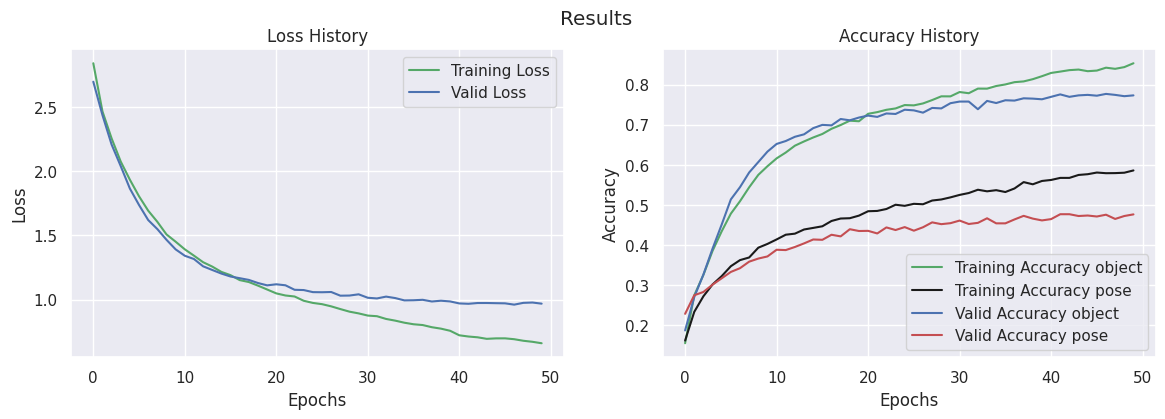

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history9 = trainer9.getHistory()
trainer9.showResults()

best model was trained at epoch: 47
with a validation loss of: 0.9600151 and a validation accuracy of: 77.66950726509094


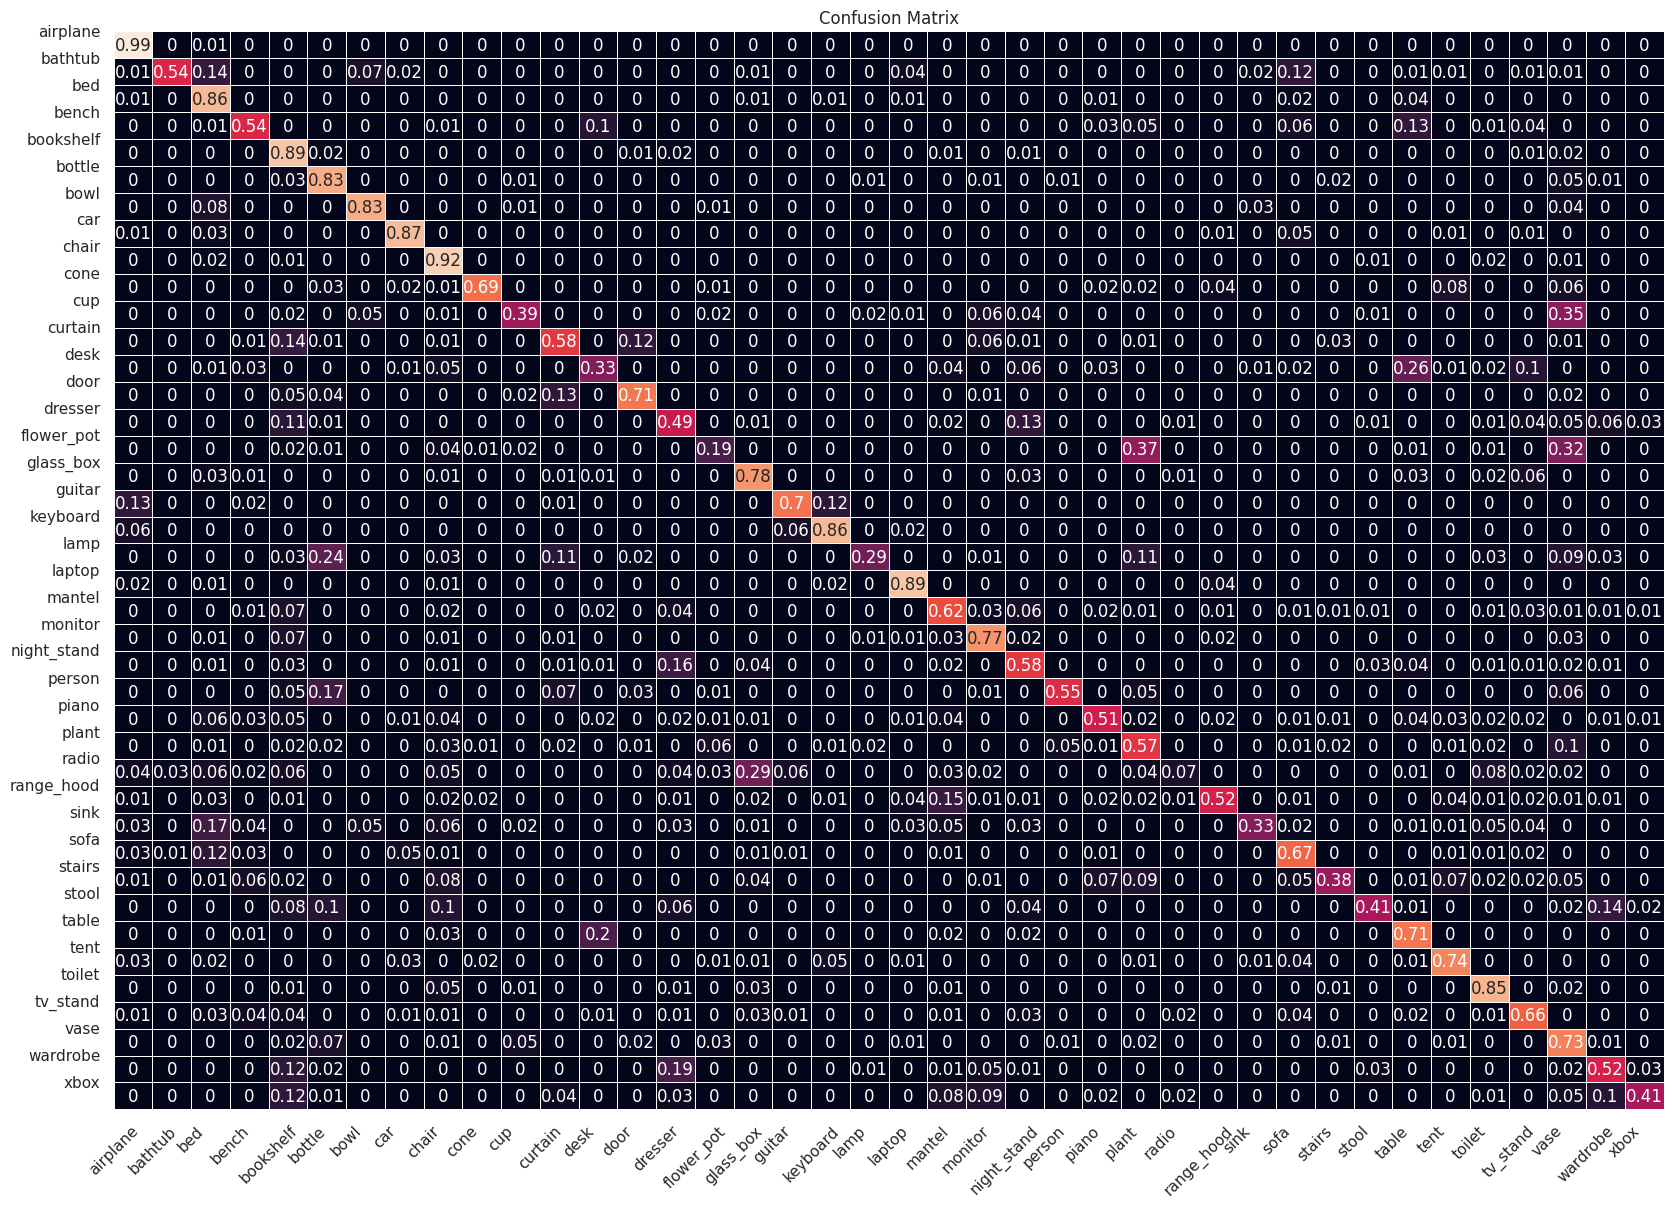

In [ ]:
trainer9.generateConfusionMatrix()

In [ ]:
class DMPORION40(nn.Module):
    def __init__(self):
        super(DMPORION40, self).__init__()
        n_classes = 40
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.2)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('pool3', torch.nn.MaxPool3d(2)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256,kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool4', torch.nn.MaxPool3d(2))
        ]))

        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 40,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPORION40'
}

trainer10 = Network_Trainer40(training_hyperparameters)
trainer10.train()

model DMPORION40 was choosen
143.75


Train loss: 2.6007537841796875: : 143it [01:02,  2.27it/s]
77it [00:08,  8.87it/s]


epoch:  1 / 50
time: 71.68 seconds
train-loss: 2.89, train-acc-object: 15.02%, train-acc-pose: 17.67%
valid-loss: 2.89, valid-acc-object: 17.05%, valid-acc-pose: 25.05%



Train loss: 2.2490553855895996: : 143it [01:02,  2.28it/s]
77it [00:08,  8.93it/s]


epoch:  2 / 50
time: 71.49 seconds
train-loss: 2.43, train-acc-object: 29.09%, train-acc-pose: 24.16%
valid-loss: 2.64, valid-acc-object: 29.44%, valid-acc-pose: 27.89%



Train loss: 1.8577162027359009: : 143it [01:02,  2.28it/s]
77it [00:08,  9.53it/s]


epoch:  3 / 50
time: 70.86 seconds
train-loss: 2.13, train-acc-object: 37.03%, train-acc-pose: 29.65%
valid-loss: 2.50, valid-acc-object: 38.77%, valid-acc-pose: 29.88%



Train loss: 1.7861034870147705: : 143it [01:03,  2.26it/s]
77it [00:07, 10.06it/s]


epoch:  4 / 50
time: 70.98 seconds
train-loss: 1.91, train-acc-object: 43.73%, train-acc-pose: 32.67%
valid-loss: 2.32, valid-acc-object: 44.70%, valid-acc-pose: 33.66%



Train loss: 1.634441614151001: : 143it [01:03,  2.26it/s]
77it [00:07, 10.86it/s]


epoch:  5 / 50
time: 70.44 seconds
train-loss: 1.73, train-acc-object: 48.99%, train-acc-pose: 36.31%
valid-loss: 2.17, valid-acc-object: 52.01%, valid-acc-pose: 36.22%



Train loss: 1.7281687259674072: : 143it [01:03,  2.26it/s]
77it [00:07, 10.50it/s]


epoch:  6 / 50
time: 70.49 seconds
train-loss: 1.60, train-acc-object: 53.67%, train-acc-pose: 38.33%
valid-loss: 2.09, valid-acc-object: 56.80%, valid-acc-pose: 37.35%



Train loss: 1.5209040641784668: : 143it [01:03,  2.26it/s]
77it [00:07,  9.70it/s]


epoch:  7 / 50
time: 71.25 seconds
train-loss: 1.51, train-acc-object: 55.89%, train-acc-pose: 40.33%
valid-loss: 1.95, valid-acc-object: 58.99%, valid-acc-pose: 37.72%



Train loss: 1.4176430702209473: : 143it [01:02,  2.28it/s]
77it [00:08,  8.95it/s]


epoch:  8 / 50
time: 71.39 seconds
train-loss: 1.44, train-acc-object: 59.23%, train-acc-pose: 41.53%
valid-loss: 1.89, valid-acc-object: 59.72%, valid-acc-pose: 38.86%



Train loss: 1.3169803619384766: : 143it [01:03,  2.27it/s]
77it [00:08,  8.56it/s]


epoch:  9 / 50
time: 72.04 seconds
train-loss: 1.35, train-acc-object: 61.51%, train-acc-pose: 41.96%
valid-loss: 1.80, valid-acc-object: 63.58%, valid-acc-pose: 39.34%



Train loss: 1.069357991218567: : 143it [01:02,  2.28it/s]
77it [00:08,  8.78it/s]


epoch: 10 / 50
time: 71.47 seconds
train-loss: 1.29, train-acc-object: 63.63%, train-acc-pose: 42.78%
valid-loss: 1.75, valid-acc-object: 65.21%, valid-acc-pose: 39.99%



Train loss: 0.9814124703407288: : 143it [01:03,  2.26it/s]
77it [00:09,  8.52it/s]


epoch: 11 / 50
time: 72.23 seconds
train-loss: 1.24, train-acc-object: 65.85%, train-acc-pose: 43.41%
valid-loss: 1.67, valid-acc-object: 65.81%, valid-acc-pose: 39.95%



Train loss: 1.1317996978759766: : 143it [01:03,  2.26it/s]
77it [00:08,  8.67it/s]


epoch: 12 / 50
time: 72.22 seconds
train-loss: 1.19, train-acc-object: 67.25%, train-acc-pose: 44.62%
valid-loss: 1.60, valid-acc-object: 67.84%, valid-acc-pose: 41.09%



Train loss: 1.290245532989502: : 143it [01:03,  2.26it/s]
77it [00:08,  8.61it/s]


epoch: 13 / 50
time: 72.21 seconds
train-loss: 1.14, train-acc-object: 69.08%, train-acc-pose: 45.29%
valid-loss: 1.60, valid-acc-object: 68.98%, valid-acc-pose: 42.43%



Train loss: 1.1250460147857666: : 143it [01:03,  2.27it/s]
77it [00:08,  8.62it/s]


epoch: 14 / 50
time: 71.98 seconds
train-loss: 1.11, train-acc-object: 70.74%, train-acc-pose: 45.68%
valid-loss: 1.51, valid-acc-object: 69.02%, valid-acc-pose: 42.27%



Train loss: 1.218995213508606: : 143it [01:03,  2.27it/s]
77it [00:08,  8.65it/s]


epoch: 15 / 50
time: 71.96 seconds
train-loss: 1.08, train-acc-object: 71.44%, train-acc-pose: 46.35%
valid-loss: 1.55, valid-acc-object: 70.73%, valid-acc-pose: 43.85%



Train loss: 1.1152865886688232: : 143it [01:04,  2.22it/s]
77it [00:09,  8.18it/s]


epoch: 16 / 50
time: 73.73 seconds
train-loss: 1.05, train-acc-object: 72.32%, train-acc-pose: 46.90%
valid-loss: 1.49, valid-acc-object: 70.24%, valid-acc-pose: 43.08%



Train loss: 0.9224662780761719: : 143it [01:04,  2.21it/s]
77it [00:08,  9.32it/s]


epoch: 17 / 50
time: 73.04 seconds
train-loss: 1.02, train-acc-object: 73.56%, train-acc-pose: 47.51%
valid-loss: 1.45, valid-acc-object: 71.99%, valid-acc-pose: 43.44%



Train loss: 1.0348045825958252: : 143it [01:04,  2.20it/s]
77it [00:08,  9.62it/s]


epoch: 18 / 50
time: 72.94 seconds
train-loss: 0.99, train-acc-object: 74.34%, train-acc-pose: 47.96%
valid-loss: 1.41, valid-acc-object: 70.60%, valid-acc-pose: 43.00%



Train loss: 1.0999021530151367: : 143it [01:04,  2.22it/s]
77it [00:07, 10.09it/s]


epoch: 19 / 50
time: 72.16 seconds
train-loss: 0.97, train-acc-object: 75.07%, train-acc-pose: 48.84%
valid-loss: 1.37, valid-acc-object: 73.57%, valid-acc-pose: 44.34%



Train loss: 0.7919425964355469: : 143it [01:05,  2.20it/s]
77it [00:07, 10.22it/s]


epoch: 20 / 50
time: 72.60 seconds
train-loss: 0.94, train-acc-object: 75.83%, train-acc-pose: 48.82%
valid-loss: 1.34, valid-acc-object: 74.67%, valid-acc-pose: 45.11%



Train loss: 0.756999135017395: : 143it [01:04,  2.22it/s]
77it [00:07,  9.72it/s]


epoch: 21 / 50
time: 72.47 seconds
train-loss: 0.93, train-acc-object: 76.05%, train-acc-pose: 48.71%
valid-loss: 1.30, valid-acc-object: 73.57%, valid-acc-pose: 45.35%



Train loss: 0.9670132398605347: : 143it [01:04,  2.22it/s]
77it [00:08,  9.25it/s]


epoch: 22 / 50
time: 72.88 seconds
train-loss: 0.91, train-acc-object: 76.88%, train-acc-pose: 49.41%
valid-loss: 1.33, valid-acc-object: 74.14%, valid-acc-pose: 45.55%



Train loss: 0.888299822807312: : 143it [01:04,  2.22it/s]
77it [00:08,  9.05it/s]


epoch: 23 / 50
time: 73.03 seconds
train-loss: 0.89, train-acc-object: 77.66%, train-acc-pose: 49.74%
valid-loss: 1.29, valid-acc-object: 75.03%, valid-acc-pose: 46.04%



Train loss: 0.6385823488235474: : 143it [01:04,  2.21it/s]
77it [00:09,  8.52it/s]


epoch: 24 / 50
time: 73.88 seconds
train-loss: 0.88, train-acc-object: 78.00%, train-acc-pose: 50.33%
valid-loss: 1.27, valid-acc-object: 74.91%, valid-acc-pose: 45.11%



Train loss: 1.0872623920440674: : 143it [01:04,  2.20it/s]
77it [00:08,  8.69it/s]


epoch: 25 / 50
time: 73.75 seconds
train-loss: 0.87, train-acc-object: 78.37%, train-acc-pose: 51.06%
valid-loss: 1.26, valid-acc-object: 75.40%, valid-acc-pose: 45.72%



Train loss: 1.1526753902435303: : 143it [01:04,  2.21it/s]
77it [00:08,  8.78it/s]


epoch: 26 / 50
time: 73.58 seconds
train-loss: 0.84, train-acc-object: 79.27%, train-acc-pose: 50.68%
valid-loss: 1.22, valid-acc-object: 76.21%, valid-acc-pose: 46.04%



Train loss: 0.8008736371994019: : 143it [01:04,  2.20it/s]
77it [00:08,  8.71it/s]


epoch: 27 / 50
time: 73.77 seconds
train-loss: 0.83, train-acc-object: 79.23%, train-acc-pose: 51.60%
valid-loss: 1.25, valid-acc-object: 75.64%, valid-acc-pose: 46.45%



Train loss: 0.6869089603424072: : 143it [01:05,  2.19it/s]
77it [00:08,  8.98it/s]


epoch: 28 / 50
time: 73.93 seconds
train-loss: 0.82, train-acc-object: 79.55%, train-acc-pose: 52.23%
valid-loss: 1.23, valid-acc-object: 75.92%, valid-acc-pose: 45.68%



Train loss: 0.7830386161804199: : 143it [01:04,  2.20it/s]
77it [00:08,  9.02it/s]


epoch: 29 / 50
time: 73.48 seconds
train-loss: 0.80, train-acc-object: 80.93%, train-acc-pose: 51.80%
valid-loss: 1.24, valid-acc-object: 75.56%, valid-acc-pose: 46.53%



Train loss: 0.6600584387779236: : 143it [01:04,  2.20it/s]
77it [00:08,  8.62it/s]


epoch: 30 / 50
time: 73.81 seconds
train-loss: 0.79, train-acc-object: 81.04%, train-acc-pose: 52.60%
valid-loss: 1.17, valid-acc-object: 78.03%, valid-acc-pose: 45.72%



Train loss: 0.9733536839485168: : 143it [01:04,  2.21it/s]
77it [00:08,  9.00it/s]


epoch: 31 / 50
time: 73.42 seconds
train-loss: 0.78, train-acc-object: 81.42%, train-acc-pose: 52.48%
valid-loss: 1.18, valid-acc-object: 77.39%, valid-acc-pose: 46.20%



Train loss: 0.8784537315368652: : 143it [01:04,  2.21it/s]
77it [00:08,  8.77it/s]


epoch: 32 / 50
time: 73.58 seconds
train-loss: 0.76, train-acc-object: 81.81%, train-acc-pose: 52.25%
valid-loss: 1.17, valid-acc-object: 76.98%, valid-acc-pose: 47.22%



Train loss: 0.943922758102417: : 143it [01:05,  2.18it/s]
77it [00:08,  8.76it/s]


epoch: 33 / 50
time: 74.31 seconds
train-loss: 0.74, train-acc-object: 82.57%, train-acc-pose: 53.20%
valid-loss: 1.16, valid-acc-object: 78.20%, valid-acc-pose: 47.79%



Train loss: 0.7083671689033508: : 143it [01:05,  2.19it/s]
77it [00:08,  8.81it/s]


epoch: 34 / 50
time: 74.15 seconds
train-loss: 0.74, train-acc-object: 82.57%, train-acc-pose: 53.85%
valid-loss: 1.11, valid-acc-object: 77.06%, valid-acc-pose: 47.42%



Train loss: 0.7798804640769958: : 143it [01:06,  2.14it/s]
77it [00:08,  9.05it/s]


epoch: 35 / 50
time: 75.32 seconds
train-loss: 0.74, train-acc-object: 82.51%, train-acc-pose: 54.28%
valid-loss: 1.14, valid-acc-object: 76.74%, valid-acc-pose: 47.34%



Train loss: 0.5466619729995728: : 143it [01:07,  2.12it/s]
77it [00:08,  9.53it/s]


epoch: 36 / 50
time: 75.45 seconds
train-loss: 0.71, train-acc-object: 83.38%, train-acc-pose: 53.85%
valid-loss: 1.11, valid-acc-object: 78.08%, valid-acc-pose: 48.03%



Train loss: 0.8749217987060547: : 143it [01:05,  2.17it/s]
77it [00:07,  9.79it/s]


epoch: 37 / 50
time: 73.66 seconds
train-loss: 0.70, train-acc-object: 83.87%, train-acc-pose: 54.79%
valid-loss: 1.12, valid-acc-object: 77.79%, valid-acc-pose: 48.07%



Train loss: 0.8022060394287109: : 143it [01:05,  2.19it/s]
77it [00:07,  9.81it/s]


epoch: 38 / 50
time: 73.26 seconds
train-loss: 0.70, train-acc-object: 83.95%, train-acc-pose: 54.82%
valid-loss: 1.06, valid-acc-object: 78.93%, valid-acc-pose: 47.95%



Train loss: 0.7244232892990112: : 143it [01:05,  2.18it/s]
77it [00:07,  9.82it/s]


epoch: 39 / 50
time: 73.43 seconds
train-loss: 0.68, train-acc-object: 84.21%, train-acc-pose: 55.42%
valid-loss: 1.05, valid-acc-object: 78.28%, valid-acc-pose: 47.62%



Train loss: 0.7497467994689941: : 143it [01:06,  2.17it/s]
77it [00:07,  9.82it/s]


epoch: 40 / 50
time: 73.90 seconds
train-loss: 0.68, train-acc-object: 84.36%, train-acc-pose: 55.39%
valid-loss: 1.07, valid-acc-object: 78.85%, valid-acc-pose: 47.34%



Train loss: 0.540608823299408: : 143it [01:05,  2.17it/s]
77it [00:07,  9.90it/s]


epoch: 41 / 50
time: 73.70 seconds
train-loss: 0.63, train-acc-object: 86.34%, train-acc-pose: 57.28%
valid-loss: 1.03, valid-acc-object: 79.17%, valid-acc-pose: 47.71%



Train loss: 0.7371928691864014: : 143it [01:05,  2.18it/s]
77it [00:07, 10.03it/s]


epoch: 42 / 50
time: 73.37 seconds
train-loss: 0.62, train-acc-object: 86.56%, train-acc-pose: 57.30%
valid-loss: 1.00, valid-acc-object: 79.98%, valid-acc-pose: 47.75%



Train loss: 0.6131070852279663: : 143it [01:05,  2.17it/s]
77it [00:07,  9.63it/s]


epoch: 43 / 50
time: 73.95 seconds
train-loss: 0.60, train-acc-object: 87.19%, train-acc-pose: 58.13%
valid-loss: 1.01, valid-acc-object: 79.29%, valid-acc-pose: 47.34%



Train loss: 0.435749351978302: : 143it [01:06,  2.16it/s]
77it [00:08,  9.51it/s]


epoch: 44 / 50
time: 74.36 seconds
train-loss: 0.59, train-acc-object: 87.53%, train-acc-pose: 57.71%
valid-loss: 1.00, valid-acc-object: 79.98%, valid-acc-pose: 48.23%



Train loss: 0.7187778949737549: : 143it [01:06,  2.16it/s]
77it [00:08,  9.37it/s]


epoch: 45 / 50
time: 74.32 seconds
train-loss: 0.59, train-acc-object: 87.30%, train-acc-pose: 57.33%
valid-loss: 1.01, valid-acc-object: 79.25%, valid-acc-pose: 47.75%



Train loss: 0.48435813188552856: : 143it [01:05,  2.18it/s]
77it [00:08,  9.24it/s]


epoch: 46 / 50
time: 73.99 seconds
train-loss: 0.58, train-acc-object: 88.09%, train-acc-pose: 59.05%
valid-loss: 1.00, valid-acc-object: 79.50%, valid-acc-pose: 48.27%



Train loss: 0.4602024555206299: : 143it [01:05,  2.19it/s]
77it [00:08,  8.83it/s]


epoch: 47 / 50
time: 74.17 seconds
train-loss: 0.58, train-acc-object: 87.83%, train-acc-pose: 58.61%
valid-loss: 0.99, valid-acc-object: 79.82%, valid-acc-pose: 48.56%



Train loss: 0.5820044279098511: : 143it [01:05,  2.18it/s]
77it [00:09,  8.35it/s]


epoch: 48 / 50
time: 74.83 seconds
train-loss: 0.57, train-acc-object: 88.02%, train-acc-pose: 58.82%
valid-loss: 0.99, valid-acc-object: 80.23%, valid-acc-pose: 47.34%



Train loss: 0.7531259059906006: : 143it [01:05,  2.19it/s]
77it [00:09,  8.05it/s]


epoch: 49 / 50
time: 74.90 seconds
train-loss: 0.56, train-acc-object: 88.41%, train-acc-pose: 58.64%
valid-loss: 0.98, valid-acc-object: 79.82%, valid-acc-pose: 47.10%



Train loss: 0.4684634208679199: : 143it [01:05,  2.20it/s]
77it [00:09,  8.04it/s]

epoch: 50 / 50
time: 74.71 seconds
train-loss: 0.57, train-acc-object: 88.52%, train-acc-pose: 58.73%
valid-loss: 0.97, valid-acc-object: 79.62%, valid-acc-pose: 48.52%



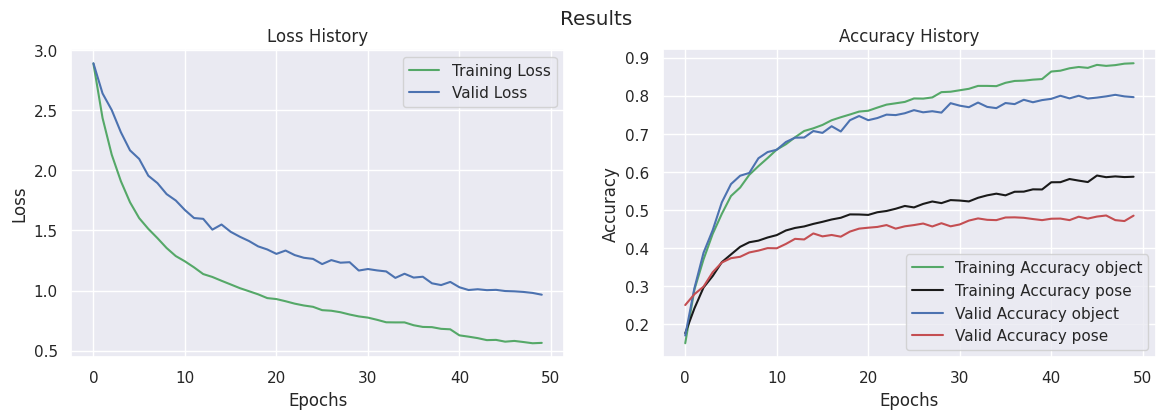

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

history10 = trainer10.getHistory()
trainer10.showResults()

best model was trained at epoch: 48
with a validation loss of: 0.98864955 and a validation accuracy of: 80.22736310958862


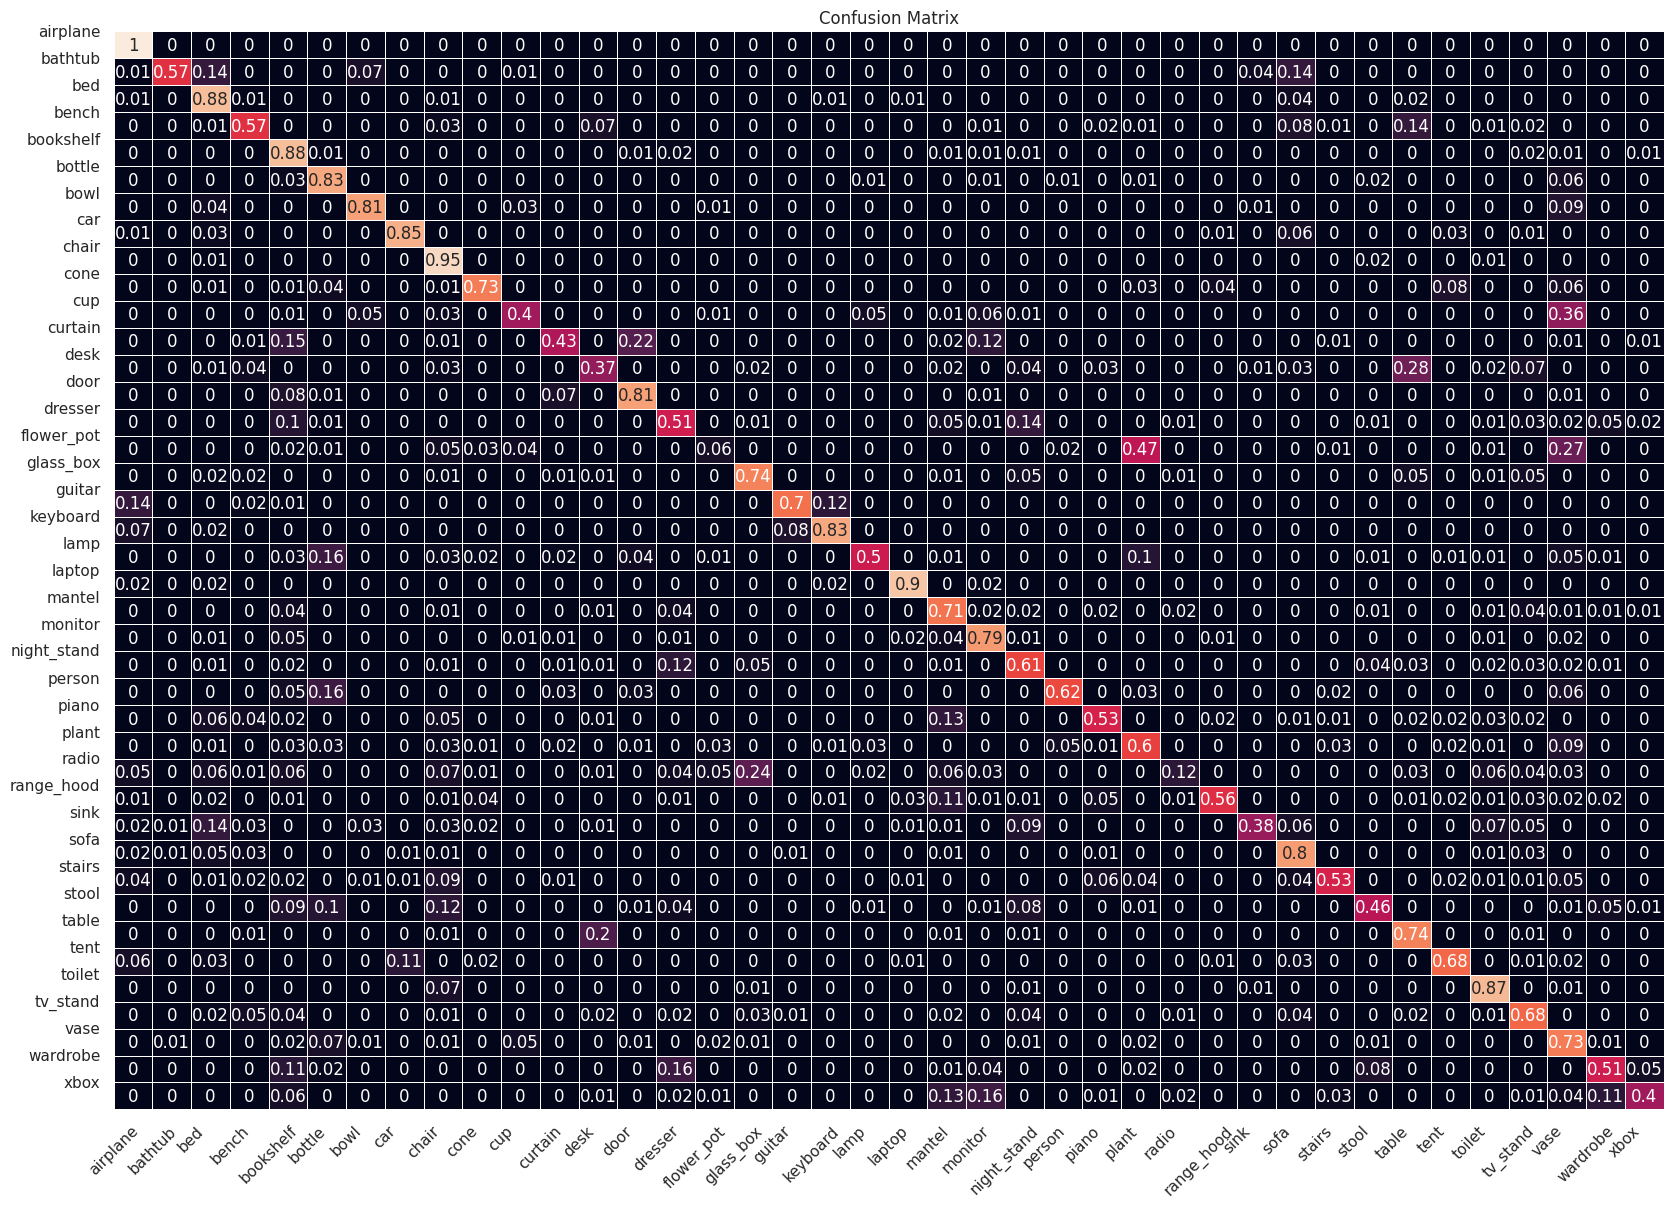

In [ ]:
trainer10.generateConfusionMatrix()

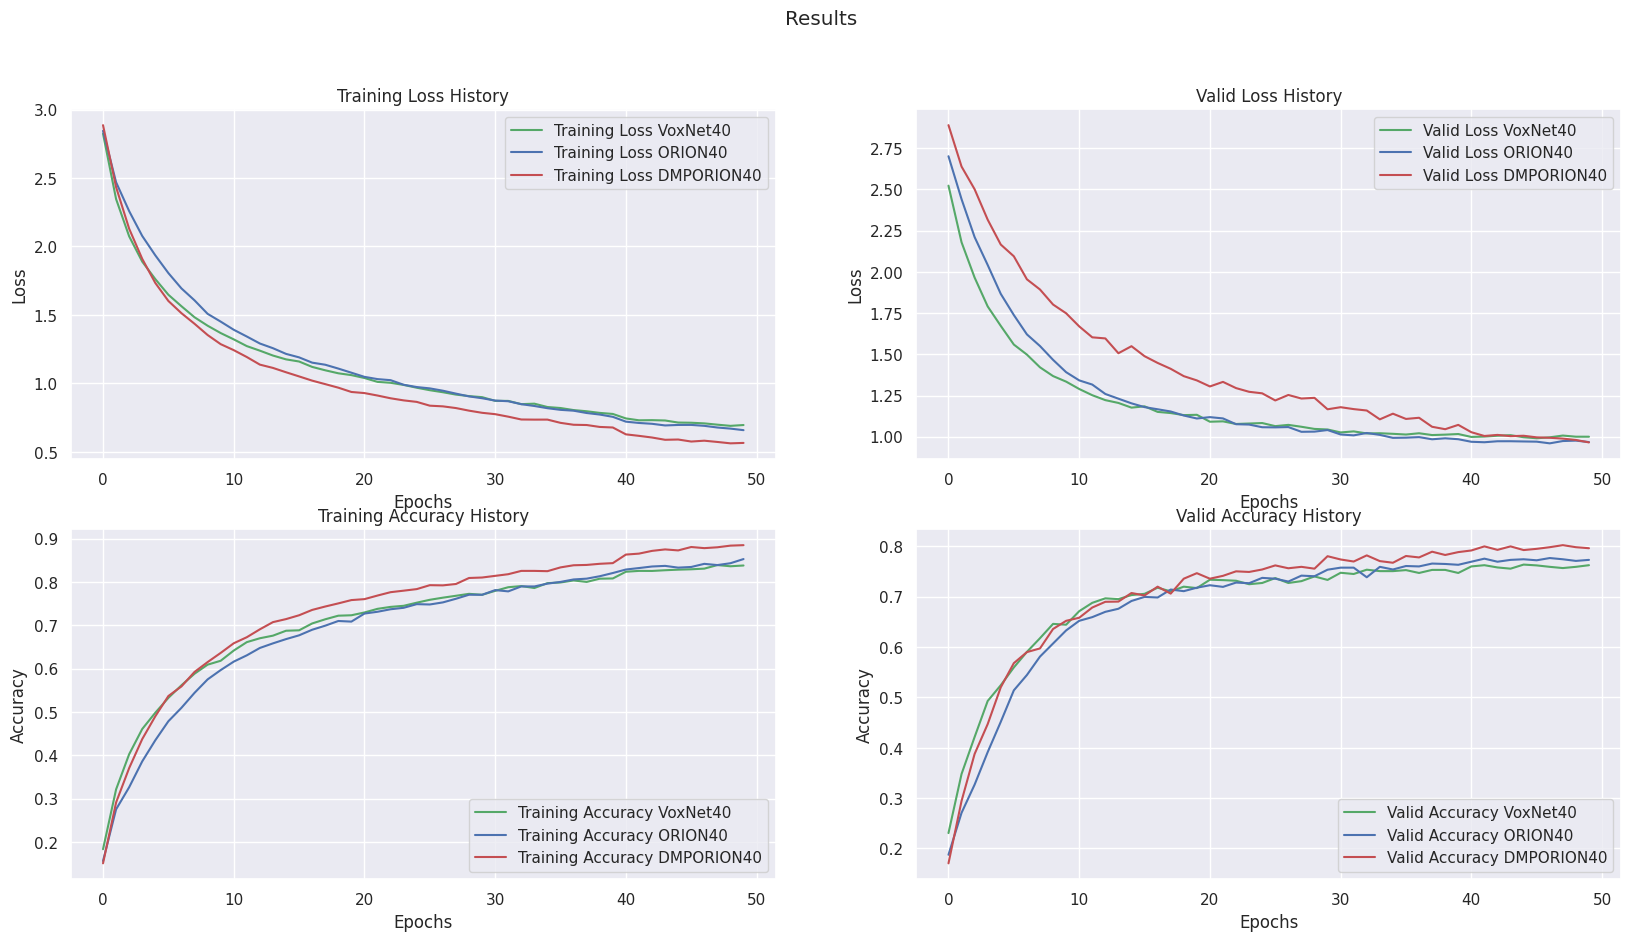

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val

    return smoothed

eps = range(0, len(history8["train_loss"].cpu()))

sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')

ax[0,0].plot(eps, smooth(history8["train_loss"].cpu()), 'g', label='Training Loss VoxNet40')
ax[0,0].plot(eps, smooth(history9["train_loss"].cpu()), 'b', label='Training Loss ORION40')
ax[0,0].plot(eps, smooth(history10["train_loss"].cpu()), 'r', label='Training Loss DMPORION40')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()

ax[0,1].plot(eps, smooth(history8["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet40')
ax[0,1].plot(eps, smooth(history9["valid_loss"].cpu()), 'b', label='Valid Loss ORION40')
ax[0,1].plot(eps, smooth(history10["valid_loss"].cpu()), 'r', label='Valid Loss DMPORION40')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history8["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet40')
ax[1,0].plot(eps, smooth(history9["train_acc1"].cpu()), 'b', label='Training Accuracy ORION40')
ax[1,0].plot(eps, smooth(history10["train_acc1"].cpu()), 'r', label='Training Accuracy DMPORION40')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history8["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet40')
ax[1,1].plot(eps, smooth(history9["valid_acc1"].cpu()), 'b', label='Valid Accuracy ORION40')
ax[1,1].plot(eps, smooth(history10["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPORION40')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

best model was trained at epoch: 45
with a validation loss of: 0.99709827 and a validation accuracy of: 76.37028098106384
best model was trained at epoch: 47
with a validation loss of: 0.9600151 and a validation accuracy of: 77.66950726509094
best model was trained at epoch: 48
with a validation loss of: 0.98864955 and a validation accuracy of: 80.22736310958862


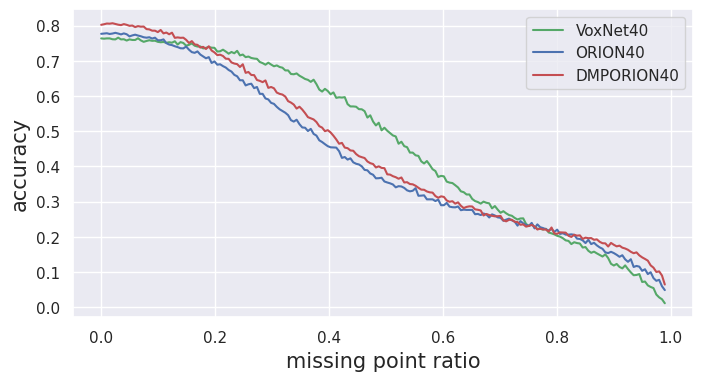

In [ ]:
eps7, acc7 = trainer8.missing_data_test()
eps8, acc8 = trainer9.missing_data_test()
eps9, acc9 = trainer10.missing_data_test()

sns.set_theme()
plt.figure(figsize=(8, 4))
line1 = plt.plot(eps7, smooth(acc7), 'g', label='VoxNet40')
line2 = plt.plot(eps8, smooth(acc8), 'b', label='ORION40')
line3 = plt.plot(eps9, smooth(acc9), 'r', label='DMPORION40')

plt.xlabel("missing point ratio", size=15)
plt.ylabel("accuracy", size=15)
plt.legend()
plt.show()